# Полный словарь признаков, используемых в модели

Ниже приведено исчерпывающее описание всех фич, формируемых в feature generation-скрипте.

---

## 1. Базовые и идентификационные признаки

Эта группа задаёт фундамент операции: кто, когда и с какой суммой участвовал.  
Без неё невозможно построить агрегаты, выделить клиентов, отследить историю или связать операции между собой.  
Используется как опорный слой для последующих расчётов.

| Признак | Описание |
|--------|----------|
| `txn_id` | Уникальный идентификатор операции: SHA-256 от `date`, `debit_inn`, `credit_inn`, `amount`, `purpose`. |
| `date` | Дата операции, нормализованная до начала суток. |
| `debit_inn` / `credit_inn` | ИНН отправителя / получателя. |
| `debit_amount` / `credit_amount` | Суммы дебетовой / кредитовой части операции (пустые → `0.0`). |
| `amount` | Итоговая сумма операции (объединённый дебет/кредит). |
| `log_amount` | Логарифм суммы: `log1p(amount.clip(lower=1))`. |

---

## 2. Календарно-временные признаки

Позволяют учитывать сезонность и ритм поведения: будни/выходные, конец месяца, пики активности.  
Типичные паттерны — платежи по расписанию, зарплаты, налоги, массовые переводы в фиксированные даты.  
Помогают отличать нормальные повторяющиеся циклы от аномальной активности.

| Признак | Описание |
|--------|----------|
| `day_of_week` | День недели (0 = понедельник). |
| `is_weekend` | 1, если суббота/воскресенье. |
| `is_month_end` | Признак конца месяца. |
| `month` | Номер месяца. |
| `weekofyear` | ISO-номер недели. |

---

## 3. Признаки суммы и округления

Нужны для фиксации подозрительных структур сумм: крупные ровные числа часто встречаются при схемах вывода средств, транзите, обналичивании или дроблении.  
Позволяют легко выделять операции с повышенной «токсичностью» по форме суммы.


| Признак | Описание |
|--------|----------|
| `is_round_10k` | Сумма кратна 10 000. |
| `is_round_100k` | Сумма кратна 100 000. |
| `is_round_large` | 1, если сумма круглая по одному из критериев выше. |

---

## 4. Низкоуровневые текстовые признаки

Эта группа оценивает структуру назначения: длина, количество цифр, верхний регистр.  
Помогает выявлять машинно-сгенерированные назначения, массовые шаблоны или токсичную лексику до NLP-анализа.  
Полезна при фильтрации аномальных текстов и подготовке к более сложным методам.


| Признак | Описание |
|--------|----------|
| `purpose` | Исходный текст назначения. |
| `purpose_len` | Количество символов. |
| `purpose_digits_ratio` | Доля цифр в тексте. |
| `purpose_upper_ratio` | Доля заглавных букв. |

---

## 5. Суточная активность клиента

Характеризует операционное поведение в течение дня: сколько транзакций, на какие суммы, насколько операция выделяется на фоне дневного потока.  
Критично для поиска неестественных всплесков, дробления сумм, подмены слоя активности.  
Используется и в антифроде, и при скоринге клиента.


| Признак | Описание |
|--------|----------|
| `daily_total_debit` / `daily_total_credit` | Суточный объём дебетовых / кредитовых операций. |
| `daily_debit_txn_count` / `daily_credit_txn_count` | Суточное число операций по дебету / кредиту. |
| `daily_debit_percent` / `daily_credit_percent` | Доля операции в суточном обороте клиента. |

---

## 6. Интервалы между операциями

Отражают «ритм» клиента: регулярность перевода средств, перерывы в активности.  
Аномалии — резкие паузы или наоборот резкие серии транзакций — часто коррелируют с подозрительными операциями.  
Позволяют детектировать «разогрев» счета или переход к нетипичному режиму работы.


| Признак | Описание |
|--------|----------|
| `days_since_last_db` | Дней с момента предыдущей операции данного `debit_inn`. |
| `days_since_last_cr` | Дней с момента предыдущей операции данного `credit_inn`. |

---

## 7. Скользящие агрегаты по дебету (7 / 14 / 30 / 90 дней)

Дают долгосрочный поведенческий профиль по каждому ИНН.  
Скользящие суммы, частоты, средние и перцентили фиксируют:  
- устойчивый уровень активности,  
- естественные колебания,  
- степень волатильности.  
Это фундамент временных моделей и база для всплесков/аномалий.


Для `W ∈ {7, 14, 30, 90}`:

| Признак | Описание |
|--------|----------|
| `debit_roll_sum_Wd` | Сумма дебетовых операций за окно. |
| `debit_roll_cnt_Wd` | Количество активных дней за окно. |
| `debit_roll_mean_Wd` | Среднесуточный объём. |
| `debit_roll_std_Wd` | Стандартное отклонение суточных объёмов. |
| `debit_roll_p95_Wd` | 95-й перцентиль суточных объёмов. |

---

## 8. Скользящие агрегаты по кредиту (7 / 14 / 30 / 90 дней)

Фокусируются на динамике: насколько последние дни отличаются от предыдущих периодов.  
Нужны для выявления резких изменений: выбросы, изменение стиля работы, активизация схем.  
Важный слой антифрод-логики: позволяет ловить всплески до того, как они станут очевидны по суммам.


Аналогично дебету:

| Признак | Описание |
|--------|----------|
| `credit_roll_sum_Wd` | Сумма кредитовых операций за окно. |
| `credit_roll_cnt_Wd` | Число активных дней. |
| `credit_roll_mean_Wd` | Среднесуточный объём. |
| `credit_roll_std_Wd` | Стандартное отклонение объёмов. |
| `credit_roll_p95_Wd` | 95-й перцентиль объёмов. |

---

## 9. Всплески и ускорения активности

Отслеживает появление новых получателей.  
ЕСЛИ клиент вдруг начинает работать с большим количеством новых ИНН — это чаще всего триггер риска (обнал, транзит, технические счета).  
30-дневное окно сглаживает шум и даёт устойчивую метрику.


| Признак | Описание |
|--------|----------|
| `debit_amount_spike_7d` / `credit_amount_spike_7d` | Сравнение 7-дневной суммы с нормализованным месячным уровнем. |
| `debit_tx_spike_7d` / `credit_tx_spike_7d` | Сравнение частоты операций (7d vs 30d). |
| `debit_accel` / `credit_accel` | Ускорение активности (7d vs 14d). |
| `debit_to_p95_90` / `credit_to_p95_90` | Уровень последних 7 дней относительно типичных максимумов 90-дневного окна. |

---

## 10. Новизна контрагентов

Выделяют поведение, характерное для транзита: в тот же день пришли деньги → в тот же день ушли.  
`net_flow_ratio_7d` показывает направленность потоков (сбор / распыление).  
Крайне важная группа для антифрода и AML.

| Признак | Описание |
|--------|----------|
| `debit_new_counterparty_30d` | Доля транзакций с новыми получателями за последние 30 дней (rolling). |

---

## 11. Транзитные и балансные признаки

Даёт сводный портрет клиента за всю историю: масштабы работы, стабильность, число партнёров, характер потоков.  
Используется:  
- для сравнения клиентов между собой,  
- при поиске аномалий в разрезе «клиент, а не операция»,  
- при расчёте риск-оценок на уровне сущности.  
Формирует долгосрочную базовую линию поведения.

| Признак | Описание |
|--------|----------|
| `transit_flag_same_day` | Признак транзита: входящие и исходящие операции в тот же день. |
| `net_flow_ratio_7d` | Баланс потоков за 7 дней в диапазоне [-1; 1]. |

---

## 12. Глобальный профиль ИНН — отправитель (`debit_inn`)

Позволяют выделять скрытую семантику назначения транзакции.  
Используются для:  
- детекции платежей с высоким юридическим/экономическим риском (займ, долг, крипта, агентские услуги),  
- кластеризации операций,  
- подаваемых в ансамбли моделей как плотное числовое представление текста.  
Основа текстового поведенческого анализа.

| Признак | Описание |
|--------|----------|
| `debit_inn_total_amount` | Общая сумма операций. |
| `debit_inn_mean_amount` | Средняя сумма операции. |
| `debit_inn_std_amount` | Стандартное отклонение сумм. |
| `debit_inn_median_amount` | Медиана сумм. |
| `debit_inn_unique_partners` | Число уникальных получателей. |
| `debit_inn_txn_count` | Количество операций. |
| `debit_inn_active_days` | Количество дней с активностью. |

---

## 13. Глобальный профиль ИНН — получатель (`credit_inn`)

Формируют финальный слой детекции: оценки редкости, графовые связи, исторический риск.  
Это уже не сырые фичи, а выводы моделей более высокого уровня.  
Используются для интегрального скоринга операции и композитного AML-анализа.

| Признак | Описание |
|--------|----------|
| `credit_inn_total_amount` | Общая сумма операций. |
| `credit_inn_mean_amount` | Средняя сумма. |
| `credit_inn_std_amount` | Стандартное отклонение сумм. |
| `credit_inn_median_amount` | Медиана сумм. |
| `credit_inn_unique_partners` | Число уникальных отправителей. |
| `credit_inn_txn_count` | Количество операций. |
| `credit_inn_active_days` | Количество дней активности. |

---

## 14. Текстовые признаки высокого уровня (TF-IDF + SVD)

Эта группа отвечает за извлечение скрытого смыслового содержания из назначения платежа.  
В отличие от простых текстовых статистик (длина, цифры, заглавные буквы), здесь уже применяется полноценная текстовая модель:

- **TF-IDF** позволяет уловить морфологию и типичные шаблоны назначения — устойчивые фразы, номера документов, служебные паттерны.
- **SVD-компоненты** сжимают высокоразмерный TF-IDF в компактное числовое представление (до 50 признаков), пригодное для моделей и устойчивое к шуму.
- **`purpose_stopword_high`** фиксирует наличие юридически и экономически значимых терминов («займ», «долг», «обнал», «крипто», «USDT», «BTC»), которые часто встречаются в рискованных транзакциях.

Группа критична для AML/антифрода, потому что назначение платежа часто содержит ключевую информацию о природе операции — и именно текстовая семантика позволяет отделять легитимные переводы от рискованных.

| Признак | Описание |
|--------|----------|
| `purpose_clean` | Нормализованный текст назначения. |
| `purpose_stopword_high` | Индикатор подозрительных паттернов (займ, долг, наличные, крипта, BTC/USDT и др.). |
| `purpose_svd_1 ... purpose_svd_k` | Компоненты SVD над TF-IDF (символьные 3–5-граммы), максимум 50 компонент. |

---

## 15. Модельные и интегральные признаки риска (в коде не рассчитываются)

Эта группа — верхний слой фичей, формируемый уже не прямыми вычислениями, а дополнительными моделями.  
Задача — агрегировать информацию из поведения, текстов, графа связей и истории в числовые оценки риска.

| Признак | Описание |
|--------|----------|
| `hbos_score`, `copod_score` | Глобальные outlier-оценки. |
| `iforest_score_debit`, `iforest_score_credit` | Индивидуальные оценки аномальности. |
| `txn_risk_score` | Интегральный поведенческий риск операции. |
| `txn_node_risk` | Графовая оценка риска связи. |
| `history_risk_*` | Исторические статистики риска с байесовским сглаживанием. |
| `overall_risk` | Итоговый агрегированный риск. |

---

# Конец словаря



# Пояснение к архитектуре и логике расчета риска в ИИ-агенте анализа транзакций

## 1. Цель проекта

Цель разработки — создание интеллектуального агента, способного автоматически оценивать риск банковских операций и выявлять признаки подозрительных транзакций.  
Агент должен обеспечивать интерпретируемую, юридически обоснованную и количественно корректную оценку степени риска.

Система анализирует каждую операцию по нескольким независимым слоям, каждый из которых отвечает за свой аспект поведения клиента и контекста сделки.  
Результаты объединяются в итоговую интегральную метрику — `overall_risk`, которая отражает совокупную степень подозрительности операции.

---

## 2. Логика построения пайплайна

### 2.1 Поведенческий слой (Behavior Layer)

**Назначение —** выявление аномалий в поведении конкретного клиента (ИНН) по операциям дебета и кредита.  
Анализ проводится раздельно по ролям (дебет / кредит), чтобы учесть специфику входящих и исходящих операций.

**Используемый метод:**  
- **IsolationForest** — модель поиска аномалий, основанная на принципе изоляции наблюдений.  
  Чем меньше разбиений нужно, чтобы "отделить" операцию от остальной массы данных,  
  тем выше вероятность, что она является аномальной.

**Признаки анализа:**  
- объёмы и частота операций (`roll_cnt_30d`, `roll_mean_30d`, `roll_std_30d`);  
- краткосрочные всплески активности (`amount_spike_ratio_7d`, `tx_rate_spike_7d`);  
- волатильность и нестабильность (`amount_volatility_30d`);  
- календарные контекстные признаки (`is_weekend`, `is_month_end`).

**Результат:**  
- Для каждой транзакции формируется индивидуальный поведенческий риск:  
  `iforest_score_debit` (по исходящим операциям) и `iforest_score_credit` (по входящим).  
- Эти оценки отражают **внутриклиентскую аномальность** и служат основой интегрального поведенческого показателя `txn_risk_score`.  
- Операции с высокими значениями считаются поведенчески подозрительными и передаются в следующие уровни анализа.

---

### 2.2 Глобальный слой (Global Layer)

**Назначение —** оценка редкости и статистической нетипичности операции относительно всей выборки транзакций.  
Этот слой нужен для ситуаций, когда у клиента недостаточно исторических данных для построения надёжной индивидуальной модели.  
Он позволяет определить, насколько операция выглядит необычно **в масштабе всех клиентов банка**.

**Используемые методы:**

- **HBOS (Histogram-Based Outlier Score)** — оценивает, насколько значение признаков транзакции  
  попадает в редкие (малонаселённые) области распределения по гистограммам признаков.

- **COPOD (Copula-Based Outlier Detection)** — вычисляет вероятность того, что наблюдение  
  лежит на краю многомерного распределения признаков (через копулу распределения).

Обе модели основаны на статистических методах без обучения на метках,  
что позволяет использовать их для **неразмеченных транзакционных данных**.

**Признаки анализа:**  
- базовые суммы (`amount`), агрегаты по окнам (`*_roll_*`),  
- показатели активности (`daily_*`, `days_since_last_*`),  
- показатели концентрации потоков (`fan_in/out`, `in_out_ratio_30d`),  
- признаки округлённости сумм (`round_large_amount`),  
- календарные факторы (`day_of_week`, `is_weekend`, `is_month_end`),  
- текстовые характеристики назначения (`purpose_stopword_high`, `purpose_svd_1–50`).

**Результат:**  
- Для каждой транзакции рассчитываются `hbos_score` и `copod_score`.  
- Их среднее значение образует интегральный показатель `global_score`,  
  отражающий степень статистической нетипичности операции.  
- Этот показатель используется в интеграционной ячейке для балансировки с индивидуальными (IsolationForest) оценками.  

**Интерпретация:**  
Глобальный слой — это **референсное поле статистической "нормы"**,  
которое позволяет выявлять редкие транзакции даже у новых клиентов,  
для которых нет достаточной индивидуальной истории.

---

### 2.3 Графовый слой (Graph Layer)

**Назначение —** анализ структуры связей между контрагентами для выявления нетипичных взаимодействий между организациями.  
Если поведенческие модели отвечают на вопрос **«как ведёт себя клиент»**,  
то графовый слой отвечает на вопрос **«с кем и насколько естественно он взаимодействует»**.

---

#### Основная идея

Граф формируется по парам ИНН, участвующим в транзакциях:  
каждая вершина графа — это **участник (ИНН)**,  
а каждое ребро — **финансовая связь между двумя организациями**.  
Модель учится восстанавливать структуру связей, выделяя те, что не вписываются в нормальные закономерности сети.

---

#### Модель: Graph Convolutional Autoencoder (GCN-AE)

Используется **графовый автокодировщик**, основанный на сверточных операциях по графу.  
Каждому узлу присваивается векторное представление (эмбеддинг) \( z_i \), которое отражает его позицию и связи в сети.  
Модель обучается восстанавливать вероятности связей между узлами.  
Если вероятность \( p_{ij} = \sigma(z_i^\top z_j) \) низка, связь между организациями считается **аномальной**.

Аномальность связи вычисляется как:
\[
R_{\text{graph}}(i,j) = 1 - \sigma(z_i^\top z_j)
\]
где \( \sigma \) — сигмоидальная функция активации, а \( z_i, z_j \) — эмбеддинги узлов.

---

#### Признаки узлов и связей

- **Признаки узлов (node features):**  
  усреднённые агрегированные показатели активности ИНН — суммы, частоты, волатильность, поведенческие метрики, текстовые рисковые признаки.  
  Эти данные описывают **внутренний профиль организации**, отражая, насколько типично она действует в сети.

- **Признаки связей (edge features):**  
  фактическое существование или отсутствие транзакций между ИНН.  
  Модель не использует количественные атрибуты рёбер напрямую,  
  но оценивает их "естественность" через совместимость узловых эмбеддингов.  
  Таким образом, ребро — это проверка гипотезы «должны ли эти два участника быть связаны».

---

#### Логика обучения

Модель обучается восстанавливать реальные рёбра, отличая их от случайных (негативных) пар узлов.  
Функция потерь минимизирует бинарную кросс-энтропию:
\[
\mathcal{L} = \text{BCE}\bigl(\{(i,j)\!\in\!E\},1\bigr) + \text{BCE}\bigl(\{(u,v)\!\notin\!E\},0\bigr)
\]
Тем самым формируются эмбеддинги, в которых близкие узлы — те, чьи связи подтверждаются статистикой.

---

#### Узловые метрики (агрегация риска)

1. **Edge-based score** — средний риск по всем связям узла:  
   \[
   S_{\text{edge}}(i)=\frac{1}{\deg(i)}\sum_{j\in \mathcal{N}(i)} R_{\text{graph}}(i,j)
   \]
   показывает, насколько подозрительны связи компании в целом.

2. **Isolation score** — косинусное отличие узла от его окружения:  
   \[
   S_{\text{iso}}(i)=1-\frac{1}{\deg(i)}\sum_{j\in \mathcal{N}(i)} \cos(z_i,z_j)
   \]
   измеряет изолированность компании в латентном пространстве сети.

3. **Итоговый узловой риск:**  
   \[
   S_{\text{node}}(i)=0.5 \cdot S_{\text{edge}}(i) + 0.5 \cdot S_{\text{iso}}(i)
   \]
   — интегральная оценка сетевой подозрительности ИНН.

---

#### Интерпретация

- **Для связи (рёбра)** — `txn_node_risk` отражает риск аномальности пары «отправитель–получатель».  
  Высокий показатель говорит о редкой, слабосогласованной или искусственной связи.  

- **Для узла (ИНН)** — `node_score` показывает общее отклонение компании от закономерностей сети.  
  Узлы с высоким риском часто являются **промежуточными звеньями транзитных цепочек**  
  или участниками нетипичных схем взаимодействий.

---

#### Почему графовый слой необходим

1. Поведенческие модели рассматривают транзакции изолированно и не фиксируют сетевых аномалий.  
2. Реальные схемы вывода средств или фиктивных операций часто строятся **через связи между несколькими организациями**,  
   где каждая по отдельности выглядит нормально.  
3. Графовый слой выявляет аномалии **структурного характера** — редкие или искусственные связи, изолированные кластеры,  
   разрывы в топологии сети.  

Таким образом, он дополняет поведенческие и глобальные модели,  
добавляя **сетевой контекст**, без которого невозможно достоверно оценить реальную степень риска.


---

### 2.4 Исторический слой (Memory Layer)
Назначение — учет истории поведения клиента.  
При расчете учитывается число прошлых операций и усредненный риск клиента.  
Для стабилизации оценки используется **байесовское сглаживание**:

\[
\text{history\_risk} = \frac{n}{n + K} \cdot \bar{r}_{client} + \frac{K}{n + K} \cdot \bar{r}_{global}
\]

Где:
- \( n \) — количество транзакций клиента;  
- \( \bar{r}_{client} \) — средний риск клиента;  
- \( \bar{r}_{global} \) — средний риск по всей базе;  
- \( K \) — параметр сглаживания.

Такое сглаживание предотвращает переоценку риска клиентов с малым числом операций и делает оценку устойчивой.

---

### 2.5 Интеграционный слой (Fusion Layer)
Назначение — объединение результатов всех предыдущих слоёв в единую итоговую метрику `overall_risk`.

Общая формула:

\[
R_{overall} = w_b \cdot R_{behavior} + w_g \cdot R_{graph} + w_h \cdot R_{history}
\]

С ограничениями:

\[
w_b \ge 0.6,\quad w_g \le 0.25,\quad w_h \le 0.15,\quad w_b + w_g + w_h = 1
\]

Поведенческий риск всегда имеет наибольший вес, поскольку отражает индивидуальные особенности клиента.  
Графовый и исторический риски корректируют итоговую оценку, усиливая подозрительность при наличии сетевых связей или накопленных негативных паттернов.

---

### 2.6 Модель доверия (коэффициент α)
Для адаптации веса индивидуальной модели в зависимости от объема данных используется логарифмическое доверие:

\[
\alpha = 0.35 + 0.5 \cdot \frac{\log(1+n)}{\log(1+n_{max})}, \quad \text{clip}[0.35, 0.85]
\]

где:
- \( n \) — количество транзакций у конкретного клиента,  
- \( n_{max} \) — максимальное количество транзакций в выборке.

Такое выражение обеспечивает плавный рост доверия: увеличение уверенности с ростом данных, но с замедлением прироста (эффект убывающей отдачи).

---

### 2.7 Юридический слой (Legal Reasoning Layer)
Назначение — интерпретация результатов анализа в контексте законодательства РФ.  
Используется языковая модель **GigaChat-2**, которой передаются аналитические признаки и рассчитанный риск.  
На выходе формируется юридически обоснованное заключение:
- уровень риска (красный, жёлтый, зелёный),
- квалификация операции,
- ссылка на нормативные акты (115-ФЗ, 127-ФЗ, 375-П, 4453-У),
- рекомендации для специалиста финмониторинга.

---

## 3. Обоснование выбора подходов и математических выражений

1. **Байесовское сглаживание** выбрано, поскольку классическое среднее нестабильно при малом числе данных.  
   Использование сглаженной формулы обеспечивает устойчивость оценки и предотвращает случайные выбросы.

2. **Логарифмическое доверие (α)** отражает реальный процесс накопления знаний: прирост уверенности при увеличении наблюдений нелинеен.  
   Первые операции существенно повышают доверие, но при большом объеме эффект снижается.

3. **Взвешивание рисков (blending)** позволяет объединить независимые источники сигналов — поведенческий, графовый и исторический.  
   Ограничения на веса гарантируют доминирование актуальной информации над накопленной и контекстной.

4. **Графовый анализ** необходим, так как значительная часть сомнительных схем проявляется только через сеть взаимосвязанных компаний, что невозможно увидеть по отдельным операциям.

5. **Юридический слой** добавлен для обеспечения интерпретируемости и связи с нормативными актами, что критически важно в сфере комплаенса и ПОД/ФТ.

---





In [1]:
# Необхоидимые импорты
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import networkx as nx

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

import hashlib
np.random.seed(42)

In [3]:
df = pd.read_excel('data/final_risk_data.xlsx')

In [4]:
import pandas as pd
import numpy as np
import hashlib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

######################################################################
# 0. Базовая подготовка и нормализация таблицы
######################################################################

def make_txn_id(row):
    parts = [
        str(row.get('date', '')),
        str(row.get('debit_inn', '')),
        str(row.get('credit_inn', '')),
        str(row.get('amount', '')),
        str(row.get('purpose', ''))
    ]
    raw = "||".join(parts)
    return hashlib.sha256(raw.encode('utf-8')).hexdigest()

df = pd.read_excel("data/final_risk_data.xlsx")

df['date'] = pd.to_datetime(df['date']).dt.normalize()

for col in ['debit_amount', 'credit_amount']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['amount'] = df['debit_amount'].fillna(df['credit_amount'])
df['debit_amount'] = df['debit_amount'].fillna(0.0)
df['credit_amount'] = df['credit_amount'].fillna(0.0)

if 'txn_id' not in df:
    df['txn_id'] = df.apply(make_txn_id, axis=1)

df = df.sort_values(['date', 'txn_id']).reset_index(drop=True)


######################################################################
# 1. Базовые фичи операции
######################################################################

df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

df['log_amount'] = np.log1p(df['amount'].clip(lower=1))
df['is_round_10k'] = (df['amount'] % 10000 == 0).astype(int)
df['is_round_100k'] = (df['amount'] % 100000 == 0).astype(int)
df['is_round_large'] = ((df['is_round_10k'] == 1) | (df['is_round_100k'] == 1)).astype(int)

df["purpose_len"] = df["purpose"].astype(str).str.len()
df["purpose_digits_ratio"] = (
    df["purpose"].astype(str).str.count(r"\d") / (df["purpose_len"] + 1e-6)
)
df["purpose_upper_ratio"] = (
    df["purpose"].astype(str).str.count(r"[A-ZА-Я]") / (df["purpose_len"] + 1e-6)
)


######################################################################
# 2. Суточные агрегаты и относительные доли
######################################################################

df["daily_total_debit"] = df.groupby(['debit_inn', 'date'])['amount'].transform('sum')
df["daily_total_credit"] = df.groupby(['credit_inn', 'date'])['amount'].transform('sum')

df["daily_debit_txn_count"] = df.groupby(['debit_inn', 'date'])['amount'].transform(lambda s: (s > 0).sum())
df["daily_credit_txn_count"] = df.groupby(['credit_inn', 'date'])['amount'].transform(lambda s: (s > 0).sum())

df["daily_debit_percent"] = (
    df["amount"] / df["daily_total_debit"].replace(0, np.nan)
).fillna(0.0)

df["daily_credit_percent"] = (
    df["amount"] / df["daily_total_credit"].replace(0, np.nan)
).fillna(0.0)


######################################################################
# 3. Интервалы между операциями
######################################################################

df["days_since_last_db"] = (
    df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
)

df["days_since_last_cr"] = (
    df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)
)


######################################################################
# 4. Роллинги по ИНН (7/14/30/90)
######################################################################

def add_rolling_side(df, side, amt_col, windows=(7, 14, 30, 90)):
    inn_col = f"{side}_inn"
    parts = []
    
    need = df[[inn_col, "date", amt_col]].copy()
    need[amt_col] = need[amt_col].fillna(0.0)

    for inn, sub in need.groupby(inn_col):
        daily = (
            sub.groupby("date")[amt_col]
            .sum()
            .to_frame("amt_day")
            .sort_index()
        )

        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0)
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)
        daily.index.name = "date"

        for W in windows:
            daily[f"{side}_roll_sum_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_cnt_{W}d"] = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"{side}_roll_std_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"{side}_roll_p95_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)

        daily = daily.reset_index()
        daily[inn_col] = inn
        parts.append(daily)

    rolls = pd.concat(parts, ignore_index=True)
    return df.merge(rolls, on=["date", inn_col], how="left")

WINDOWS = (7, 14, 30, 90)
df = add_rolling_side(df, "debit", "debit_amount", windows=WINDOWS)
df = add_rolling_side(df, "credit", "credit_amount", windows=WINDOWS)


######################################################################
# 5. Всплески и ускорения
######################################################################

df["debit_amount_spike_7d"] = df["debit_roll_sum_7d"] / (df["debit_roll_sum_30d"] / 4 + 1e-6)
df["credit_amount_spike_7d"] = df["credit_roll_sum_7d"] / (df["credit_roll_sum_30d"] / 4 + 1e-6)

df["debit_tx_spike_7d"] = df["debit_roll_cnt_7d"] / (df["debit_roll_cnt_30d"] / 4 + 1e-6)
df["credit_tx_spike_7d"] = df["credit_roll_cnt_7d"] / (df["credit_roll_cnt_30d"] / 4 + 1e-6)

df["debit_accel"] = (
    (df["debit_roll_sum_7d"] - df["debit_roll_sum_14d"]) /
    (df["debit_roll_sum_14d"] + 1e-6)
).clip(-10, 10)

df["credit_accel"] = (
    (df["credit_roll_sum_7d"] - df["credit_roll_sum_14d"]) /
    (df["credit_roll_sum_14d"] + 1e-6)
).clip(-10, 10)

df["debit_to_p95_90"] = df["debit_roll_sum_7d"] / (df["debit_roll_p95_90d"] + 1e-6)
df["credit_to_p95_90"] = df["credit_roll_sum_7d"] / (df["credit_roll_p95_90d"] + 1e-6)


######################################################################
# 6. Новизна контрагентов по дням
######################################################################

def rolling_new_counterparty(gr):
    seen = set()
    flags = []
    for c in gr["credit_inn"]:
        flags.append(0 if c in seen else 1)
        seen.add(c)
    return pd.Series(flags, index=gr.index).rolling(30, min_periods=1).mean()

df["debit_new_counterparty_30d"] = (
    df.sort_values(["debit_inn", "date", "txn_id"])
      .groupby("debit_inn", group_keys=False)
      .apply(rolling_new_counterparty)
      .fillna(0.0)
)


######################################################################
# 7. Транзитные признаки
######################################################################

df["transit_flag_same_day"] = (
    (df["days_since_last_cr"] == 0) &
    (df["daily_total_credit"] > 0) &
    (df["daily_total_debit"] > 0)
).astype(int)

df["net_flow_ratio_7d"] = (
    (df["credit_roll_sum_7d"] - df["debit_roll_sum_7d"]) /
    (df["credit_roll_sum_7d"] + df["debit_roll_sum_7d"] + 1e-6)
).clip(-1, 1)


######################################################################
# 8. Глобальный профиль ИНН (entity profile)
######################################################################

def build_entity_profile(df, inn_col, amt_col):
    prof = df.groupby(inn_col).agg(
        total_amount=(amt_col, 'sum'),
        mean_amount=(amt_col, 'mean'),
        std_amount=(amt_col, 'std'),
        median_amount=(amt_col, 'median'),
        unique_partners=('credit_inn' if inn_col=='debit_inn' else 'debit_inn', 'nunique'),
        txn_count=(amt_col, lambda s: (s > 0).sum()),
        active_days=('date', 'nunique')
    ).fillna(0.0)
    prof.columns = [f"{inn_col}_{c}" for c in prof.columns]
    return prof

prof_debit = build_entity_profile(df, 'debit_inn', 'debit_amount')
prof_credit = build_entity_profile(df, 'credit_inn', 'credit_amount')

df = df.merge(prof_debit, on="debit_inn", how="left")
df = df.merge(prof_credit, on="credit_inn", how="left")


######################################################################
# 9. Текстовые признаки с TF-IDF + SVD
######################################################################

PATTERNS = [
    r"\bзайм\w*\b", r"\bдолг\w*\b", r"\bобнал\w*\b", r"\bналич\w*\b",
    r"\bперевод\w*\W*карт", r"\bвознагражд\w*\b", r"\bагентск\w*\b",
    r"\bдарен\w*\b", r"\bкрипт\w*\b", r"\bbtc\b", r"\busdt\b"
]
RE_PAT = re.compile("|".join(PATTERNS), flags=re.IGNORECASE)

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

df["purpose_clean"] = df["purpose"].astype(str).apply(clean_text)
df["purpose_stopword_high"] = df["purpose_clean"].str.contains(RE_PAT, na=False)

texts = df["purpose_clean"].tolist()
tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3, 5), min_df=1)
X_tfidf = tfidf.fit_transform(texts)

k = min(50, X_tfidf.shape[1] - 1, X_tfidf.shape[0] - 1)
svd = TruncatedSVD(n_components=k, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

for i in range(X_svd.shape[1]):
    df[f"purpose_svd_{i+1}"] = X_svd[:, i]


######################################################################
# Финиш
######################################################################

print("Feature generation completed.")
df.head()


Feature generation completed.


,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,purpose_svd_41,purpose_svd_42,purpose_svd_43,purpose_svd_44,purpose_svd_45,purpose_svd_46,purpose_svd_47,purpose_svd_48,purpose_svd_49,purpose_svd_50
0,2019-01-02,44b1631eab5c0928,e45bf36ee9a65bca,54f018fd8c1d9ec6,d15c1f90d498ed35,5291a4925af8e942,ac50b92c56f08dac,0.0,8987.48,"По счету № ТЕЦ 11156575 от 21.12,2118г за това...",...,-0.019449,-0.081768,-0.047928,-0.020043,-0.028268,0.080150,0.021400,-0.072372,-0.019867,-0.036055
1,2019-01-02,44b1631eab5c0928,e45bf36ee9a65bca,54f018fd8c1d9ec6,d15c1f90d498ed35,5291a4925af8e942,ac50b92c56f08dac,0.0,6242.07,"По счету № ТЕЦ 11157727 от 24.12,2118г за това...",...,-0.019801,-0.074483,-0.058912,-0.030159,-0.052114,0.059936,0.034339,-0.060919,-0.022402,-0.049025
2,2019-01-02,4a261bca73fc8feb,e8cd47f15926e96e,e71c487a21c1c4ef,d15c1f90d498ed35,58f7e73d31d13f63,ac50b92c56f08dac,0.0,40060.82,По счету №163329.163331. от 28.12.2118г 161342...,...,-0.035317,-0.059547,-0.042330,-0.052632,-0.043467,0.010549,0.013168,-0.005990,0.000538,-0.062685
3,2019-01-03,a6134aca7dedebf1,4e4947ef893accba,5959612c37e4cb25,d15c1f90d498ed35,27754919fb1f7eca,ac50b92c56f08dac,0.0,12302.94,оплата счета № 155466 от 18.12.18 на сумму 793...,...,0.041625,-0.020765,0.005807,0.020593,0.030504,0.030264,0.007954,0.118425,-0.081659,-0.029423
4,2019-01-03,6c5bf85056f310cc,76b1b25b8700878b,8f0624281a2154fc,d15c1f90d498ed35,a3a1c2d7963de8f9,ac50b92c56f08dac,0.0,10058.57,Оплата с/ф №157181 от 22/12/18 за товар. Сумма...,...,0.063701,-0.010564,0.015829,-0.024569,-0.040560,-0.012782,0.049803,-0.001840,-0.023422,-0.016639


## Блок графового анализа связей

Этот блок оценивает связь между ИНН как ребро графа и вычисляет для него риск с учётом структуры сети, поведения пары и аномальности самих узлов. Позволяет выявлять нетипичные или искусственные связи, которые не вписываются в общую топологию и динамику транзакций.


In [5]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import math
import networkx as nx

g = np.random.default_rng(42)
np.random.seed(42)

# -----------------------------------------------------
# 1. Подготовка данных
# -----------------------------------------------------

df_in = df.copy()
df_in = df_in.dropna(subset=['debit_inn','credit_inn'])
df_in['date'] = pd.to_datetime(df_in['date'])

# Собираем инн в один список
inn_series = pd.concat([df_in['debit_inn'], df_in['credit_inn']], ignore_index=True)
# Уникальные инн (будущие узлы графа)
unique_inn = pd.Index(inn_series.dropna().unique())
# Словарь ИНН->числовой ID узла графа
inn2id = {i: idx for idx, i in enumerate(unique_inn)}
# Количество узлов графа
num_nodes = len(unique_inn)

# Преобразуем концы ребер
df_in["u"] = df_in["debit_inn"].map(inn2id).astype("Int64")
df_in["v"] = df_in["credit_inn"].map(inn2id).astype("Int64")
# Удаляем замыкания на себя
df_in = df_in[df_in["u"] != df_in["v"]].copy()

# Все ребра
src_all = df_in["u"].astype(int).values
dst_all = df_in["v"].astype(int).values
# Строим массив уникальных ребер графа
all_edges_unique = np.unique(np.stack([src_all, dst_all], 0), axis=1)

# Степень узлов по всему графу
deg_all = np.bincount(
    np.concatenate([src_all, dst_all]) if len(src_all) else np.array([], dtype=int),
    minlength=num_nodes
)

# -----------------------------------------------------
# 2. Node features (по всей выписке, без train/val/test)
# -----------------------------------------------------

exclude = {
    'date','debit_account','debit_name','debit_inn','credit_account',
    'credit_name','credit_inn','purpose','u','v'
}
exclude |= {f"purpose_svd_{i}" for i in range(1,51)}

num_cols = [c for c in df_in.columns
            if c not in exclude and pd.api.types.is_numeric_dtype(df_in[c])]

def rb_aggs(gb):
    """ median + mean — устойчивые агрегаты """
    return gb[num_cols].agg(['median','mean']).swaplevel(0,1,axis=1)

# агрегаты по узлам как отправителям/получателям
agg_deb = rb_aggs(df_in.groupby('debit_inn')).reindex(unique_inn, fill_value=0.0)
agg_crd = rb_aggs(df_in.groupby('credit_inn')).reindex(unique_inn, fill_value=0.0)

feat = pd.concat([
    agg_deb.add_suffix('_debit'),
    agg_crd.add_suffix('_credit'),
], axis=1)

# общая степень узла в графе
feat['deg_all'] = deg_all

scaler = StandardScaler()
X = scaler.fit_transform(feat.values.astype(np.float32))   # [num_nodes, d_features]

# простой узловой "outlier score": чем дальше от центра — тем подозрительнее
node_outlier_raw = np.sqrt((X**2).mean(axis=1))
if node_outlier_raw.max() > node_outlier_raw.min():
    node_outlier = (node_outlier_raw - node_outlier_raw.min()) / (node_outlier_raw.max() - node_outlier_raw.min() + 1e-6)
else:
    node_outlier = np.zeros_like(node_outlier_raw)

# -----------------------------------------------------
# 3. Структурные эвристики через множества (по всему графу)
# -----------------------------------------------------

nbr = defaultdict(set)
for u, v in all_edges_unique.T:
    u = int(u); v = int(v)
    nbr[u].add(v); nbr[v].add(u)

def structural_feats(u, v):
    Nu = nbr.get(u, set()); Nv = nbr.get(v, set())
    cn = len(Nu & Nv)
    union = len(Nu | Nv)
    jacc = cn / union if union else 0.0

    aa = 0.0; ra = 0.0
    for w in (Nu & Nv):
        dw = len(nbr.get(w, set()))
        if dw > 1:
            aa += 1.0 / math.log(dw)
            ra += 1.0 / dw

    pa = len(Nu) * len(Nv)
    return cn, jacc, aa, ra, math.log1p(pa)

def batch_struct_feats(E):
    if E.size == 0:
        return np.zeros((0,5), np.float32)
    out = np.zeros((E.shape[1],5), np.float32)
    for i,(u,v) in enumerate(E.T):
        out[i] = structural_feats(int(u), int(v))
    m, s = out.mean(0), out.std(0)+1e-6
    return ((out-m)/s).astype(np.float32)

# -----------------------------------------------------
# 4. Edge features: sum, freq, round, text, temporal recency
# -----------------------------------------------------

def build_edge_features(df_edges, all_pairs):
    df_e = df_edges.copy()

    # подготовка базовых фич
    df_e["log_amt"] = np.log1p(np.abs(df_e["amount"]))
    df_e["round10k"]  = ((df_e["amount"].abs() % 10000)  == 0).astype(int)
    df_e["round100k"] = ((df_e["amount"].abs() % 100000) == 0).astype(int)

    df_e["purp_len"] = df_e.get("purpose_len", 0)
    df_e["digits_r"] = df_e.get("purpose_digits_ratio", 0.0)

    # temporal recency
    df_e = df_e.sort_values(["u","v","date"])
    df_e["days_since_prev"] = df_e.groupby(["u","v"])["date"].diff().dt.days.fillna(9999)

    # агрегации
    agg = (df_e.groupby(["u","v"])
            .agg(
                e_amt_mean=("log_amt","mean"),
                e_amt_max=("log_amt","max"),
                e_freq=("log_amt","size"),
                e_round10k=("round10k","mean"),
                e_round100k=("round100k","mean"),
                e_purp_len=("purp_len","mean"),
                e_digits_r=("digits_r","mean"),
                e_recency=("days_since_prev","mean")
            )
            .reset_index())

    edge_dict = {
        (int(r.u), int(r.v)): np.array([
            r.e_amt_mean, r.e_amt_max, np.log1p(r.e_freq),
            r.e_round10k, r.e_round100k,
            r.e_purp_len, r.e_digits_r, r.e_recency
        ], dtype=np.float32)
        for r in agg.itertuples()
    }

    U = all_pairs[0]; V = all_pairs[1]
    out = np.zeros((U.size, 8), np.float32)
    for i,(u,v) in enumerate(zip(U,V)):
        out[i] = edge_dict.get((int(u),int(v)), np.zeros(8,np.float32))

    m, s = out.mean(0), out.std(0)+1e-6
    return ((out-m)/s).astype(np.float32)

# считаем edge-фичи по всей выписке
edge_feat_all = build_edge_features(df_in, all_edges_unique)

# -----------------------------------------------------
# 5. Построение графа в networkx и структурные метрики
# -----------------------------------------------------

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
# рёбра — по всей выписке
for u, v in all_edges_unique.T:
    G.add_edge(int(u), int(v))

# если граф пустой, отработаем безопасно
if G.number_of_edges() == 0:
    edge_score = np.zeros(all_edges_unique.shape[1], dtype=np.float32)
else:
    # jaccard, adamic-adar, preferential attachment по всем уникальным рёбрам
    ebunch = [tuple(e) for e in all_edges_unique.T]

    jacc_dict = { (u,v):coef for u,v,coef in nx.jaccard_coefficient(G, ebunch) }
    adar_dict = { (u,v):coef for u,v,coef in nx.adamic_adar_index(G, ebunch) }
    pa_dict   = { (u,v):coef for u,v,coef in nx.preferential_attachment(G, ebunch) }

    # центральности узлов (Pagerank + betweenness приближённо)
    pr = nx.pagerank(G, alpha=0.9)
    bt = nx.betweenness_centrality(G, k=min(200, G.number_of_nodes()))

    pr_arr = np.array([pr.get(i,0.0) for i in range(num_nodes)], dtype=np.float32)
    bt_arr = np.array([bt.get(i,0.0) for i in range(num_nodes)], dtype=np.float32)

    # нормируем центральности
    def norm01(a):
        a = np.asarray(a, dtype=np.float32)
        if a.max() > a.min():
            return (a - a.min()) / (a.max() - a.min() + 1e-6)
        return np.zeros_like(a)

    pr_n = norm01(pr_arr)
    bt_n = norm01(bt_arr)

    # комбинированный node-risk (из node_outlier + centralities)
    node_risk = norm01(0.5*node_outlier + 0.3*pr_n + 0.2*bt_n)

    # структурные признаки по all_edges_unique, дополнительно к batch_struct_feats
    struct_local = batch_struct_feats(all_edges_unique)  # [E,5]

    E = all_edges_unique
    jacc_list = []
    adar_list = []
    pa_list   = []

    for u, v in E.T:
        tup = (int(u), int(v))
        jacc_list.append(jacc_dict.get(tup, 0.0))
        adar_list.append(adar_dict.get(tup, 0.0))
        pa_list.append(pa_dict.get(tup, 0.0))

    jacc_arr = np.array(jacc_list, dtype=np.float32)
    adar_arr = np.array(adar_list, dtype=np.float32)
    pa_arr   = np.log1p(np.array(pa_list, dtype=np.float32))

    # нормируем до нуля-среднего/единичн.СКО
    def zscore(a):
        m, s = a.mean(), a.std()
        if s == 0:
            return np.zeros_like(a, dtype=np.float32)
        return ((a - m) / (s + 1e-6)).astype(np.float32)

    jacc_z = zscore(jacc_arr)
    adar_z = zscore(adar_arr)
    pa_z   = zscore(pa_arr)

    # node part: средний риск двух концов
    u_idx = E[0]
    v_idx = E[1]
    risk_node = 0.5 * (node_risk[u_idx] + node_risk[v_idx])

    # structural part: комбинация локальных (из batch_struct_feats) и глобальных (nx)
    # struct_local: [cn, jacc_local, aa_local, ra_local, log_pa_local]
    risk_struct_local = (
        -struct_local[:,1] +   # низкий локальный jaccard
         struct_local[:,2] +   # aa
         struct_local[:,3] +   # ra
         struct_local[:,4]     # log_pa
    )

    risk_struct_global = (
        -jacc_z +              # низкий глобальный jaccard
         adar_z +              # глобальный adamic-adar
         pa_z                  # глобальный PA
    )

    risk_struct = 0.5 * risk_struct_local + 0.5 * risk_struct_global

    # edge features: [mean, max, log_freq, round10k, round100k, purp_len, digits_r, recency]
    edge_all = edge_feat_all
    risk_edge = (
        edge_all[:,2] +                    # log_freq
        edge_all[:,3] + edge_all[:,4] +    # круглые суммы
        edge_all[:,6] -                    # digits ratio
        edge_all[:,7]                      # чем ближе по времени (меньше recency), тем выше риск
    )

    # итоговый скор
    risk_raw = 0.4 * risk_node + 0.3 * risk_struct + 0.3 * risk_edge

    r_min, r_max = risk_raw.min(), risk_raw.max()
    if r_max > r_min:
        edge_score = (risk_raw - r_min) / (r_max - r_min + 1e-6)
    else:
        edge_score = np.zeros_like(risk_raw, dtype=np.float32)

# edge_score: чем ВЫШЕ, тем подозрительнее связь ИНН–ИНН
left  = unique_inn.values[all_edges_unique[0]]
right = unique_inn.values[all_edges_unique[1]]
edge_keys = pd.MultiIndex.from_arrays([left, right], names=['debit_inn','credit_inn'])
edge_df = pd.DataFrame({'edge_score': edge_score}, index=edge_keys).groupby(level=[0,1]).mean()

edge_df = edge_df.sort_values('edge_score', ascending=False)
display(edge_df.head(30))

print("Scoring complete.")

# -----------------------------------------------------
# 6. Перенос graph_edge_score и graph_node_score в основной df
# -----------------------------------------------------

# 6.1. edge → graph_edge_score (по паре debit_inn, credit_inn)
edge_df_reset = edge_df.reset_index()  # debit_inn, credit_inn, edge_score

# приведём типы к строкам для надёжного merge
edge_df_reset["debit_inn"]  = edge_df_reset["debit_inn"].astype(str)
edge_df_reset["credit_inn"] = edge_df_reset["credit_inn"].astype(str)

df["debit_inn"]  = df["debit_inn"].astype(str)
df["credit_inn"] = df["credit_inn"].astype(str)

df = df.merge(edge_df_reset,
              on=["debit_inn","credit_inn"],
              how="left")

df.rename(columns={"edge_score": "graph_edge_score"}, inplace=True)

# 6.2. node → graph_node_score (по ИНН как узлу)

node_acc = np.zeros(num_nodes, dtype=np.float64)
node_cnt = np.zeros(num_nodes, dtype=np.int64)

for (u, v), sc in zip(all_edges_unique.T, edge_score):
    node_acc[u] += sc; node_cnt[u] += 1
    node_acc[v] += sc; node_cnt[v] += 1

node_score = node_acc / np.maximum(node_cnt, 1)

node_tbl = pd.DataFrame({
    "inn": unique_inn.values.astype(str),
    "graph_node_score": node_score,
})

df = df.merge(
    node_tbl.rename(columns={"inn": "debit_inn",
                             "graph_node_score": "graph_node_score_debit"}),
    on="debit_inn",
    how="left"
)

df = df.merge(
    node_tbl.rename(columns={"inn": "credit_inn",
                             "graph_node_score": "graph_node_score_credit"}),
    on="credit_inn",
    how="left"
)

df["graph_node_score"] = np.nanmax(
    np.stack([
        df["graph_node_score_debit"].values,
        df["graph_node_score_credit"].values
    ], axis=1),
    axis=1
)

df.drop(columns=["graph_node_score_debit","graph_node_score_credit"], inplace=True)

print("Графовые признаки добавлены в df:",
      "graph_edge_score" in df.columns,
      "graph_node_score" in df.columns)


edge_score
debit_inn        credit_inn                  
7153371d56f4ebf6 ac50b92c56f08dac    1.000000
ac50b92c56f08dac b70dc8f18639110d    0.990143
83e74fd36cfedc09 ac50b92c56f08dac    0.962777
73940e19f70126c4 ac50b92c56f08dac    0.956357
ac50b92c56f08dac 7d65e62c29d9f12a    0.945488
                 ef1e66c213698fdc    0.941643
26c96bdafe1d36eb ac50b92c56f08dac    0.892259
ac50b92c56f08dac c021d9791a1adc52    0.890177
                 e3b689f5397ec9b9    0.869941
                 6a0e58513fc2f3cb    0.867225
                 7fb45df96f63ab19    0.858984
                 f4efb233746f625b    0.844967
                 c73c7d4b3aadb022    0.843596
                 58e6d8ab8c4dbf39    0.824619
                 2fa1a5c620cf1cd6    0.817820
                 a59368c4af7a1a39    0.817265
                 1868a7e06b40e4a5    0.787049
92623404d0a08ffe ac50b92c56f08dac    0.777258
ce931e9611101422 ac50b92c56f08dac    0.774243
c604ec2353b44b8f ac50b92c56f08dac    0.773979
ac50b92c56f08dac 9260307a8efe2dc8    0.773882
b11dd198183f9225 ac50b92c56f08dac    0.773833
ac50b92c56f08dac def85c8cebce39b9    0.771172
                 c43bf25457df0422    0.771123
                 25c968cf65aba204    0.770771
                 c2854a5571c9f3a0    0.769265
                 a10b3526bb8e685e    0.767853
                 ed1ddec6b55f5329    0.760285
                 f099570e85fce4f7    0.757502
b97fec19dbf7f00f ac50b92c56f08dac    0.756819

Scoring complete.
Графовые признаки добавлены в df: True True


In [6]:
# ==============================================================
# Версия с использованием графовой нейросети
# ==============================================================

# import pandas as pd, numpy as np, torch, torch.nn.functional as F
# from torch import nn
# from torch_geometric.nn import SAGEConv, JumpingKnowledge
# from sklearn.preprocessing import StandardScaler
# from tqdm.auto import tqdm
# import math

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# g = np.random.default_rng(42)
# torch.manual_seed(42)
# np.random.seed(42)

# # -----------------------------------------------------
# # 1. Подготовка данных
# # -----------------------------------------------------

# df_in = df.copy()
# df_in = df_in.dropna(subset=['debit_inn','credit_inn'])
# df_in['date'] = pd.to_datetime(df_in['date'])

# inn_series = pd.concat([df_in['debit_inn'], df_in['credit_inn']], ignore_index=True)
# unique_inn = pd.Index(inn_series.dropna().unique())
# inn2id = {i: idx for idx, i in enumerate(unique_inn)}
# num_nodes = len(unique_inn)

# df_in["u"] = df_in["debit_inn"].map(inn2id).astype("Int64")
# df_in["v"] = df_in["credit_inn"].map(inn2id).astype("Int64")
# df_in = df_in[df_in["u"] != df_in["v"]].copy()

# src_all = df_in["u"].astype(int).values
# dst_all = df_in["v"].astype(int).values
# all_edges_unique = np.unique(np.stack([src_all, dst_all], 0), axis=1)

# # -----------------------------------------------------
# # 2. Train/Val/Test сплит (temporal)
# # -----------------------------------------------------

# D0 = df_in['date'].quantile(0.70)
# D1 = df_in['date'].quantile(0.85)

# df_train = df_in[df_in['date'] <= D0].copy()
# df_val   = df_in[(df_in['date'] > D0) & (df_in['date'] <= D1)].copy()
# df_test  = df_in[df_in['date'] > D1].copy()

# def unique_pairs(df_):
#     if len(df_) == 0:
#         return np.zeros((0,2), int)
#     p = np.unique(np.stack([df_["u"].values, df_["v"].values],1), axis=0)
#     return p[p[:,0] != p[:,1]]

# pos_tr = unique_pairs(df_train)
# pos_val = unique_pairs(df_val)
# pos_te  = unique_pairs(df_test)

# deg_tr = np.bincount(
#     np.concatenate([pos_tr[:,0], pos_tr[:,1]]) if len(pos_tr) else np.array([],dtype=int),
#     minlength=num_nodes
# )

# mask_tr = (deg_tr[pos_tr[:,0]] >= 1) & (deg_tr[pos_tr[:,1]] >= 1)
# pos_tr = pos_tr[mask_tr]

# # Make training edge_index (undirected)
# if len(pos_tr):
#     ei_tr = np.concatenate([pos_tr.T, pos_tr[:,[1,0]].T], axis=1)
# else:
#     ei_tr = np.empty((2,0), int)

# edge_index_tr = torch.tensor(ei_tr, dtype=torch.long, device=device)

# enc_all_pairs = set(int(u)*num_nodes + int(v) for u,v in np.vstack([pos_tr,pos_val,pos_te]))


# # -----------------------------------------------------
# # 3. Node features (на основе TRAIN)
# # -----------------------------------------------------

# exclude = {
#     'date','debit_account','debit_name','debit_inn','credit_account',
#     'credit_name','credit_inn','purpose','u','v'
# }
# exclude |= {f"purpose_svd_{i}" for i in range(1,51)}

# num_cols = [c for c in df_train.columns
#             if c not in exclude and pd.api.types.is_numeric_dtype(df_train[c])]

# def rb_aggs(gb):
#     """ median + mean — устойчивые агрегаты """
#     return gb[num_cols].agg(['median','mean']).swaplevel(0,1,axis=1)

# agg_deb = rb_aggs(df_train.groupby('debit_inn')).reindex(unique_inn, fill_value=0.0)
# agg_crd = rb_aggs(df_train.groupby('credit_inn')).reindex(unique_inn, fill_value=0.0)

# feat = pd.concat([
#     agg_deb.add_suffix('_debit'),
#     agg_crd.add_suffix('_credit'),
# ], axis=1)

# feat['deg_tr'] = deg_tr

# scaler = StandardScaler()
# X = scaler.fit_transform(feat.values.astype(np.float32))
# x = torch.tensor(X, dtype=torch.float32, device=device)


# # -----------------------------------------------------
# # 4. Structural heuristics
# # -----------------------------------------------------

# from collections import defaultdict
# nbr = defaultdict(set)
# for u,v in pos_tr:
#     nbr[u].add(v); nbr[v].add(u)

# def structural_feats(u, v):
#     Nu = nbr.get(u, set()); Nv = nbr.get(v, set())
#     cn = len(Nu & Nv)
#     union = len(Nu | Nv)
#     jacc = cn / union if union else 0.0

#     aa = 0.0; ra = 0.0
#     for w in (Nu & Nv):
#         dw = len(nbr.get(w, set()))
#         if dw > 1:
#             aa += 1.0 / math.log(dw)
#             ra += 1.0 / dw

#     pa = len(Nu) * len(Nv)
#     return cn, jacc, aa, ra, math.log1p(pa)

# def batch_struct_feats(E):
#     if E.size == 0:
#         return np.zeros((0,5), np.float32)
#     out = np.zeros((E.shape[1],5), np.float32)
#     for i,(u,v) in enumerate(E.T):
#         out[i] = structural_feats(int(u), int(v))
#     m, s = out.mean(0), out.std(0)+1e-6
#     return ((out-m)/s).astype(np.float32)


# # -----------------------------------------------------
# # 5. Edge features: sum, freq, round, text, temporal recency
# # -----------------------------------------------------

# def build_edge_features(df_edges, all_pairs):
#     df_e = df_edges.copy()

#     # подготовка базовых фич
#     df_e["log_amt"] = np.log1p(np.abs(df_e["amount"]))
#     df_e["round10k"]  = ((df_e["amount"].abs() % 10000)  == 0).astype(int)
#     df_e["round100k"] = ((df_e["amount"].abs() % 100000) == 0).astype(int)

#     df_e["purp_len"] = df_e.get("purpose_len", 0)
#     df_e["digits_r"] = df_e.get("purpose_digits_ratio", 0.0)

#     # temporal recency
#     df_e = df_e.sort_values(["u","v","date"])
#     df_e["days_since_prev"] = df_e.groupby(["u","v"])["date"].diff().dt.days.fillna(9999)

#     # агрегации
#     agg = (df_e.groupby(["u","v"])
#             .agg(
#                 e_amt_mean=("log_amt","mean"),
#                 e_amt_max=("log_amt","max"),
#                 e_freq=("log_amt","size"),
#                 e_round10k=("round10k","mean"),
#                 e_round100k=("round100k","mean"),
#                 e_purp_len=("purp_len","mean"),
#                 e_digits_r=("digits_r","mean"),
#                 e_recency=("days_since_prev","mean")
#             )
#             .reset_index())

#     edge_dict = {
#         (int(r.u), int(r.v)): np.array([
#             r.e_amt_mean, r.e_amt_max, np.log1p(r.e_freq),
#             r.e_round10k, r.e_round100k,
#             r.e_purp_len, r.e_digits_r, r.e_recency
#         ], dtype=np.float32)
#         for r in agg.itertuples()
#     }

#     U = all_pairs[0]; V = all_pairs[1]
#     out = np.zeros((U.size, 8), np.float32)
#     for i,(u,v) in enumerate(zip(U,V)):
#         out[i] = edge_dict.get((int(u),int(v)), np.zeros(8,np.float32))

#     m, s = out.mean(0), out.std(0)+1e-6
#     return ((out-m)/s).astype(np.float32)


# edge_feat_train = build_edge_features(df_train, all_edges_unique)

# uv2idx = {(int(u),int(v)): i for i,(u,v) in enumerate(all_edges_unique.T)}
# edge_feat_train_t = torch.tensor(edge_feat_train, dtype=torch.float32, device=device)


# # -----------------------------------------------------
# # 6. Hard Negative Sampling
# # -----------------------------------------------------

# def hard_negative_sampling(k):
#     if len(pos_tr) == 0 or k == 0:
#         return np.zeros((2,0), int)
#     cand = np.stack([
#         g.integers(0, num_nodes, size=k),
#         g.integers(0, num_nodes, size=k)
#     ], 0)

#     enc = cand[0]*num_nodes + cand[1]
#     mask = np.array([e not in enc_all_pairs for e in enc])
#     cand = cand[:, mask]
#     if cand.shape[1] > k:
#         cand = cand[:, :k]
#     return cand


# # -----------------------------------------------------
# # 7. Модель: GraphSAGE + JKNet + DropEdge
# # -----------------------------------------------------

# class Encoder(nn.Module):
#     def __init__(self, d_in, d_hid=128, d_out=64, layers=3, dropedge=0.15):
#         super().__init__()
#         self.layers = layers
#         self.dropedge = dropedge
#         self.convs = nn.ModuleList()
#         self.convs.append(SAGEConv(d_in, d_hid, normalize=True))
#         for _ in range(layers-2):
#             self.convs.append(SAGEConv(d_hid, d_hid, normalize=True))
#         self.convs.append(SAGEConv(d_hid, d_out, normalize=True))

#         self.jk = JumpingKnowledge(mode="cat")
#         self.bns = nn.ModuleList([nn.BatchNorm1d(d_hid) for _ in range(layers-1)])

#         last_dim = d_hid*(layers-1) + d_out
#         self.proj = nn.Linear(last_dim, d_out)

#     def forward(self, x, edge_index):
#         outs = []
#         ei = edge_index

#         for i,conv in enumerate(self.convs):
#             # DropEdge
#             if self.training and self.dropedge > 0:
#                 mask = torch.rand(ei.size(1), device=ei.device) > self.dropedge
#                 ei = ei[:, mask]

#             h = conv(x, ei)
#             if i < len(self.convs)-1:
#                 h = self.bns[i](h)
#                 h = F.relu(h)
#             outs.append(h)
#             x = h

#         z = self.jk(outs)
#         z = self.proj(z)
#         return z


# # -----------------------------------------------------
# # 8. Edge Decoder (MLP)
# # -----------------------------------------------------

# class EdgeDecoder(nn.Module):
#     def __init__(self, d, e_dim, s_dim=5):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(2*d + e_dim + s_dim, 256),
#             nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(256,128),
#             nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(128,1)
#         )

#     def forward(self, z, edges, e_feat, s_feat):
#         u = z[edges[0]]
#         v = z[edges[1]]
#         x = torch.cat([u, v, e_feat, s_feat], dim=1)
#         return self.mlp(x).squeeze(-1)


# # -----------------------------------------------------
# # 9. Contrastive Loss (InfoNCE)
# # -----------------------------------------------------

# def info_nce(z, pos_edges, temp=0.2):
#     if pos_edges.size(1) == 0:
#         return torch.tensor(0.0, device=device)

#     u = z[pos_edges[0]]
#     v = z[pos_edges[1]]
#     pos = F.cosine_similarity(u,v)

#     all_norm = F.normalize(z, dim=1)
#     sim = all_norm @ all_norm.T  # [N,N]
#     sim = sim / temp

#     labels = torch.arange(z.size(0), device=device)
#     loss = F.cross_entropy(sim, labels)
#     return loss


# # -----------------------------------------------------
# # 10. Обучение
# # -----------------------------------------------------

# enc = Encoder(d_in=X.shape[1], d_hid=128, d_out=64, layers=3, dropedge=0.15).to(device)
# dec = EdgeDecoder(d=64, e_dim=edge_feat_train.shape[1], s_dim=5).to(device)

# opt = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=2e-3, weight_decay=1e-4)
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=300, eta_min=1e-4)
# bce = nn.BCEWithLogitsLoss()

# best_auc = -1
# best_state = None
# pat=0

# def gather_edge_feats(E):
#     if E.size(1)==0:
#         return torch.zeros((0, edge_feat_train.shape[1]), dtype=torch.float32, device=device)
#     out = []
#     for u,v in zip(E[0].cpu().numpy(), E[1].cpu().numpy()):
#         i = uv2idx.get((int(u),int(v)), -1)
#         if i == -1:
#             out.append(np.zeros(edge_feat_train.shape[1], np.float32))
#         else:
#             out.append(edge_feat_train[i])
#     return torch.tensor(out, dtype=torch.float32, device=device)

# def gather_struct_feats(E):
#     arr = batch_struct_feats(E.cpu().numpy())
#     return torch.tensor(arr, dtype=torch.float32, device=device)

# # Валидационная метрика
# from sklearn.metrics import roc_auc_score, average_precision_score

# def eval_auc(pos_edges, neg_edges):
#     enc.eval(); dec.eval()
#     with torch.no_grad():
#         z = enc(x, edge_index_tr)
#         posE = torch.tensor(pos_edges, dtype=torch.long, device=device)
#         negE = torch.tensor(neg_edges, dtype=torch.long, device=device)

#         ef_pos = gather_edge_feats(posE)
#         ef_neg = gather_edge_feats(negE)
#         sf_pos = gather_struct_feats(posE)
#         sf_neg = gather_struct_feats(negE)

#         lp = torch.sigmoid(dec(z, posE, ef_pos, sf_pos))
#         ln = torch.sigmoid(dec(z, negE, ef_neg, sf_neg))

#         y = np.concatenate([np.ones(lp.numel()), np.zeros(ln.numel())])
#         s = np.concatenate([lp.cpu().numpy(), ln.cpu().numpy()])
#         return roc_auc_score(y,s), average_precision_score(y,s)


# # Тренировка
# for ep in tqdm(range(1, 301), desc="GNN AML Training"):
#     enc.train(); dec.train()
#     opt.zero_grad()

#     z = enc(x, edge_index_tr)

#     posE = torch.tensor(pos_tr.T, dtype=torch.long, device=device)
#     negE_np = hard_negative_sampling(len(pos_tr))
#     negE = torch.tensor(negE_np, dtype=torch.long, device=device)

#     ef_pos = gather_edge_feats(posE)
#     ef_neg = gather_edge_feats(negE)
#     sf_pos = gather_struct_feats(posE)
#     sf_neg = gather_struct_feats(negE)

#     p_logits = dec(z, posE, ef_pos, sf_pos)
#     n_logits = dec(z, negE, ef_neg, sf_neg)

#     loss_bce = bce(p_logits, torch.ones_like(p_logits)) + \
#                bce(n_logits, torch.zeros_like(n_logits))

#     loss_contrast = info_nce(z, posE)

#     loss = loss_bce + 0.15*loss_contrast
#     loss.backward()
#     opt.step()
#     sched.step()

#     if ep % 5 == 0:
#         neg_val = hard_negative_sampling(len(pos_val))
#         val_auc, val_ap = eval_auc(pos_val.T, neg_val)
#         print(f"Epoch {ep:03d} | loss={loss.item():.4f} | valAUC={val_auc:.3f} | valAP={val_ap:.3f}")

#         if val_auc > best_auc:
#             best_auc = val_auc
#             best_state = {
#                 'enc': {k:v.cpu().clone() for k,v in enc.state_dict().items()},
#                 'dec': {k:v.cpu().clone() for k,v in dec.state_dict().items()}
#             }
#             pat = 0
#         else:
#             pat += 1
#         if pat >= 40:
#             print("Early stopping")
#             break

# # Restore best
# enc.load_state_dict({k:v.to(device) for k,v in best_state['enc'].items()})
# dec.load_state_dict({k:v.to(device) for k,v in best_state['dec'].items()})

# # -----------------------------------------------------
# # 11. Итоговый скоринг всех рёбер
# # -----------------------------------------------------

# enc.eval(); dec.eval()
# with torch.no_grad():
#     z = enc(x, edge_index_tr)
#     E = torch.tensor(all_edges_unique, dtype=torch.long, device=device)
#     ef = gather_edge_feats(E)
#     sf = gather_struct_feats(E)
#     p = torch.sigmoid(dec(z, E, ef, sf)).cpu().numpy()

# # edge_score: чем ВЫШЕ, тем подозрительнее связь ИНН–ИНН
# edge_score = 1.0 - p

# left  = unique_inn.values[all_edges_unique[0]]
# right = unique_inn.values[all_edges_unique[1]]
# edge_keys = pd.MultiIndex.from_arrays([left, right], names=['debit_inn','credit_inn'])
# edge_df = pd.DataFrame({'edge_score': edge_score}, index=edge_keys).groupby(level=[0,1]).mean()

# edge_df = edge_df.sort_values('edge_score', ascending=False)
# display(edge_df.head(30))

# print("Scoring complete.")

# # -----------------------------------------------------
# # 12. Перенос graph_edge_score и graph_node_score в основной df
# # -----------------------------------------------------

# # 12.1. edge → graph_edge_score (по паре debit_inn, credit_inn)
# edge_df_reset = edge_df.reset_index()  # debit_inn, credit_inn, edge_score

# # приведём типы к строкам для надёжного merge
# edge_df_reset["debit_inn"]  = edge_df_reset["debit_inn"].astype(str)
# edge_df_reset["credit_inn"] = edge_df_reset["credit_inn"].astype(str)

# df["debit_inn"]  = df["debit_inn"].astype(str)
# df["credit_inn"] = df["credit_inn"].astype(str)

# df = df.merge(edge_df_reset,
#               on=["debit_inn","credit_inn"],
#               how="left")

# df.rename(columns={"edge_score": "graph_edge_score"}, inplace=True)

# # 12.2. node → graph_node_score (по ИНН как узлу)

# # агрегируем edge_score в узловой скор: средний риск по всем рёбрам узла
# node_acc = np.zeros(num_nodes, dtype=np.float64)
# node_cnt = np.zeros(num_nodes, dtype=np.int64)

# for (u, v), sc in zip(all_edges_unique.T, edge_score):
#     node_acc[u] += sc; node_cnt[u] += 1
#     node_acc[v] += sc; node_cnt[v] += 1

# node_score = node_acc / np.maximum(node_cnt, 1)

# node_tbl = pd.DataFrame({
#     "inn": unique_inn.values.astype(str),
#     "graph_node_score": node_score,
# })

# # маппим отдельно для дебетной и кредитной ролей
# df = df.merge(
#     node_tbl.rename(columns={"inn": "debit_inn",
#                              "graph_node_score": "graph_node_score_debit"}),
#     on="debit_inn",
#     how="left"
# )

# df = df.merge(
#     node_tbl.rename(columns={"inn": "credit_inn",
#                              "graph_node_score": "graph_node_score_credit"}),
#     on="credit_inn",
#     how="left"
# )

# # итоговый узловой риск для транзакции — максимум по двум концам
# df["graph_node_score"] = np.nanmax(
#     np.stack([
#         df["graph_node_score_debit"].values,
#         df["graph_node_score_credit"].values
#     ], axis=1),
#     axis=1
# )

# df.drop(columns=["graph_node_score_debit","graph_node_score_credit"], inplace=True)

# print("Графовые признаки добавлены в df:",
#       "graph_edge_score" in df.columns,
#       "graph_node_score" in df.columns)


# Индивидуальный поведенческий слой

Этот блок строит по каждой роли (дебет/кредит) и по каждому ИНН отдельную модель IsolationForest. 
Модель ищет аномальные операции в контексте личной истории клиента, не смешивая его поведение с другими.

ИНН с >= 10 транзакций ИТОГО: 586
  └ прошли в ДЕБЕТ (>= 10 по дебету): 558
  └ прошли в КРЕДИТ (>= 10 по кредиту): 28


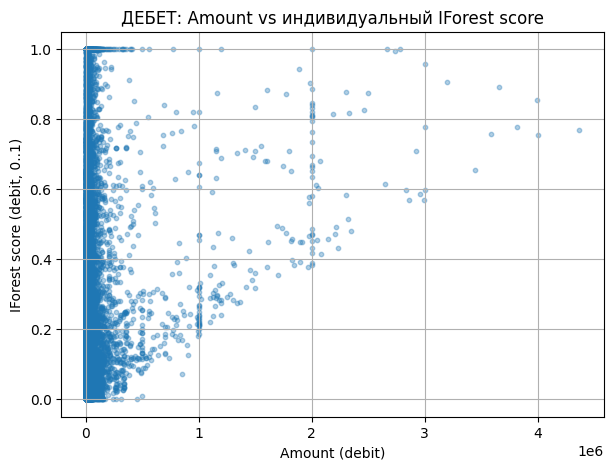

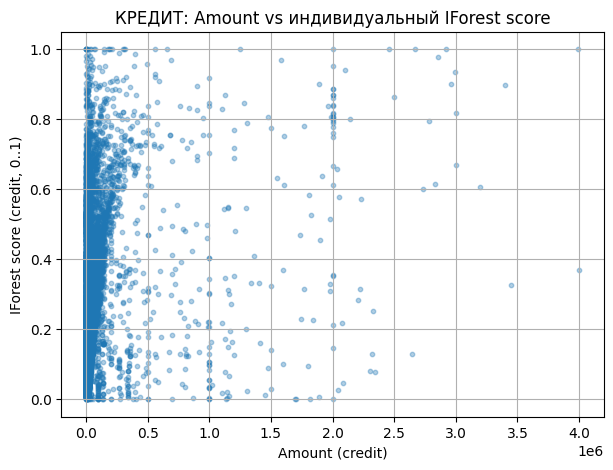

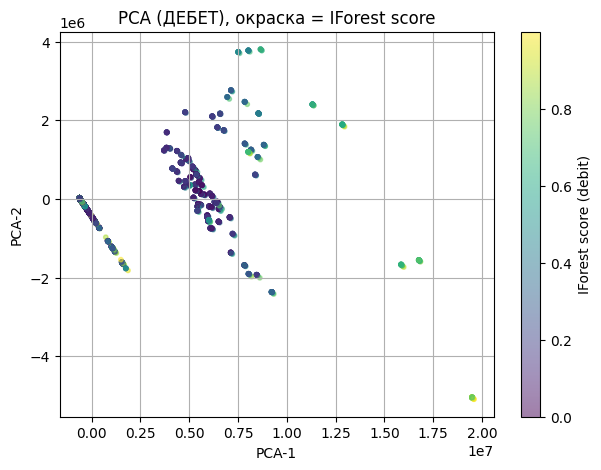

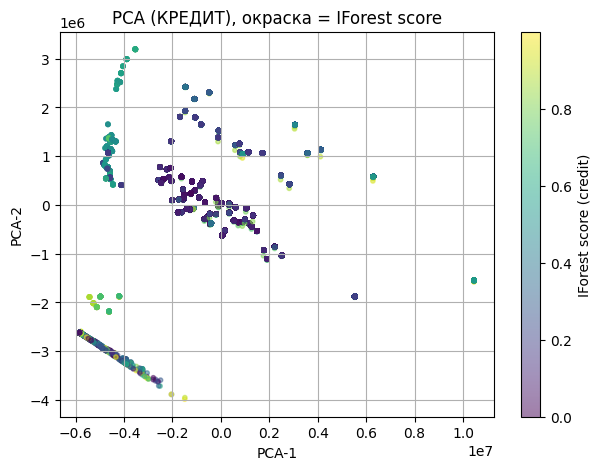

,txn_id,date,inn,side,amount,purpose,iforest_score_debit,iforest_rank_debit
456,92931e6662880dcd05ac4f94f3209a4a19860121d62134...,2019-01-09,7f870a2575b3cbdc,debit,148676.39,"Оплата за товар по с/ф 152329,152813 от 12.12....",1.0,1.0
519,aeffd30bc626437d7bc5e2a2354d98a6bc24e2e28c284d...,2019-01-09,20c3ce2268f14bda,debit,143051.22,"Оплата за товар по с/ф 153116,153165,153214,15...",1.0,1.0
12695,0e49fffa669258f926e8436e8622554a72fb103177765e...,2019-03-25,c0d8d9f325796f86,debit,65.00,ДОПЛАТА,1.0,1.0
4237,0e1a7208438656a51c4c38158dd4e40a428967055af687...,2019-02-01,4b423a7b12629149,debit,1335.43,Оплата за товар по с-ф ТЕЦ 5118 от 17.11.19г.п...,1.0,1.0
19164,efea24f21a0bad3099f5c842f87c1ad0556784275aad30...,2019-04-30,b11dd198183f9225,debit,98582.36,АУПОПЛ.ПРОД.СФТЕЦ11128789.28841.28331.28298.28...,1.0,1.0
...,...,...,...,...,...,...,...,...
1456,a6046b0108d0939fbfbf0f6b2c7049d2f1bd064517679e...,2019-01-14,bfeb06eff11468a7,debit,31826.97,Оплата за товар по сч.ф.157351.157468.161392.1...,1.0,1.0
9600,aa2a9d10338ba1f1ddc98394c6b8cade69f20f252c8a1d...,2019-03-05,cff1b142285661d9,debit,113664.02,Оплата по сч/ф ТЕЦ11118371 от 21.12.19 за прод...,1.0,1.0
4058,3a2563ae194e0ea95e340783107940ffac9625c20d344d...,2019-01-31,ff905109ecfc386c,debit,70107.89,Оплата за продукты питания согласно накладных ...,1.0,1.0
965,d5bf28ba9b6857e8a3882f59236601ef0f980bf656eecf...,2019-01-10,b15d462367998bda,debit,27662.37,"Оплата по счету № 153734 от 14.12, № 153514 от...",1.0,1.0


,txn_id,date,inn,side,amount,purpose,iforest_score_credit,iforest_rank_credit
11646,b1d21fe68f7f8bce5da4672d905c406c8665fa0146a710...,2019-03-18,cf570886445f7056,credit,564000.00,"Оплата по счету № 16377, 16378, 16379, 16391 о...",1.000000,1.000000
108,02fc6d4c8ecff63de62ca2ff98ee5d57c0eb4a64dd6a08...,2019-01-06,ac50b92c56f08dac,credit,63935.11,Зачисление средств по операциям с МБК (на осно...,1.000000,1.000000
4151,a0b8bf938c2469b0d541999c84498ff108757e25eeba96...,2019-01-31,8d9e0be733f77f1c,credit,2000000.00,Погашение кредита по договору 611161151 от 27 ...,1.000000,1.000000
13530,7f6067170406ef66114316ff0a4d0f2e0c03a164a8739a...,2019-03-28,62ff58a9bb0efe6b,credit,194726.39,Оплата задолженности за товар согласно акта св...,1.000000,1.000000
14529,d5779e5ff5007e603dc4a2ee3899e0df7cabb0cd11dd29...,2019-04-03,2fa1a5c620cf1cd6,credit,4419.20,Оплата задолженности за товар согласно акта св...,1.000000,1.000000
...,...,...,...,...,...,...,...,...
117,6f5c3846b8843e6b1ee0c5c86cf4be341a1ff4a0c61dd1...,2019-01-06,ac50b92c56f08dac,credit,372.00,РН № ТЕЦ11111126 от DATE_5eac04a521d6. В том ч...,0.884882,0.997602
116,5e17874f764cc9a7df90b60932fc91a227048c4c86fcea...,2019-01-06,ac50b92c56f08dac,credit,18897.00,Оплата по счету ТЕЦ11159249 от DATE_5eab12724a...,0.884414,0.997548
763,49100b6c613823ec53ad0f496c2b6cbc8542b60a0e785c...,2019-01-10,ac50b92c56f08dac,credit,266358.04,"ДОПЛАТА ЗА ПРОДУКТЫ, ПО СЧЕТ-ФАКТУРЕ №ТЕЦ11169...",0.882664,0.997495
480,9b8d954176632ede54417c6fe6e688bea95eb5f67d9c8b...,2019-01-09,ac50b92c56f08dac,credit,214300.88,Оплата по накладной от DATE_d39fe15328a3 №1581...,0.882482,0.997442


Сохранено: top100_anomalous_txn_debit_iforest.csv
Сохранено: top100_anomalous_txn_credit_iforest.csv
Сохранено: eligible_inn_summary_iforest.csv
Форма df с индивидуальными аномалиями: (20255, 189)


In [7]:
# ==============================================
# Индивидуальные поведенческие аномалии по ИНН
# IsolationForest по каждой роли (debit/credit) и каждому ИНН
# С расширенными фичами и адаптивным contamination
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10   # минимум транзакций по ИНН (итого) и по роли
np.random.seed(RANDOM_STATE)

df_ind = df.copy()

# --- 0. Базовая подготовка: приведение типов ---
df_ind["date"] = pd.to_datetime(df_ind["date"])
df_ind["amount"] = df_ind["amount"].astype(float)

# Подстраховка по ключевым фичам, если вдруг чего-то нет
safe_zero_cols = [
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d",
    "daily_total_debit","daily_total_credit",
    "daily_debit_transaction_count","daily_credit_transaction_count",
    "debit_accel_ratio_7d","credit_accel_ratio_7d",
    "debit_to_p95_ratio","credit_to_p95_ratio",
    "debit_new_counterparty_ratio","credit_new_counterparty_ratio",
    "debit_fan_out_ratio","credit_fan_in_ratio",
    "debit_volatility_z","credit_volatility_z",
    "in_out_ratio_30d","net_flow_ratio_7d",
    "transit_same_day_flag","round_large_amount","client_round_ratio_30d",
    "purpose_len","purpose_digits_ratio","purpose_upper_ratio",
    "is_weekend","is_month_end","is_quarter_end","is_year_end",
    "days_since_last_txn_debit","days_since_last_txn_credit"
]
for c in safe_zero_cols:
    if c not in df_ind.columns:
        df_ind[c] = 0.0

# Логарифм суммы и лог-интервалы, если не были созданы
if "log_amount" not in df_ind.columns:
    df_ind["log_amount"] = np.log1p(df_ind["amount"].clip(lower=0))

df_ind["log_days_since_last_txn_debit"]  = np.log1p(df_ind["days_since_last_txn_debit"].astype(float))
df_ind["log_days_since_last_txn_credit"] = np.log1p(df_ind["days_since_last_txn_credit"].astype(float))

# --- 1. Формируем отдельные таблицы по дебету и кредиту ---

# ДЕБЕТ
deb = pd.DataFrame({
    "txn_id": df_ind["txn_id"],
    "date": df_ind["date"],
    "inn": df_ind["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df_ind["purpose"].astype(str),
    "amount": df_ind["amount"].astype(float),
    "log_amount": df_ind["log_amount"].astype(float),

    # поведение по дебету
    "roll_cnt_30d": df_ind["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df_ind["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df_ind["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df_ind["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df_ind["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df_ind["debit_amount_volatility_30d"].astype(float),
    "accel_ratio_7d": df_ind["debit_accel_ratio_7d"].astype(float),
    "to_p95_ratio": df_ind["debit_to_p95_ratio"].astype(float),
    "new_counterparty_ratio": df_ind["debit_new_counterparty_ratio"].astype(float),
    "fan_ratio": df_ind["debit_fan_out_ratio"].astype(float),
    "volatility_z": df_ind["debit_volatility_z"].astype(float),

    # дневные показатели (поведение в день операции)
    "daily_total": df_ind["daily_total_debit"].astype(float),
    "daily_txn_cnt": df_ind["daily_debit_transaction_count"].astype(float),

    # глобальные фичи по потокам
    "in_out_ratio_30d": df_ind["in_out_ratio_30d"].astype(float),
    "net_flow_ratio_7d": df_ind["net_flow_ratio_7d"].astype(float),

    # транзит / округлённость / поведение
    "transit_same_day_flag": df_ind["transit_same_day_flag"].astype(float),
    "round_large_amount": df_ind["round_large_amount"].astype(float),
    "client_round_ratio_30d": df_ind["client_round_ratio_30d"].astype(float),

    # текст и календарь
    "purpose_len": df_ind["purpose_len"].astype(float),
    "purpose_digits_ratio": df_ind["purpose_digits_ratio"].astype(float),
    "purpose_upper_ratio": df_ind["purpose_upper_ratio"].astype(float),
    "is_weekend": df_ind["is_weekend"].astype(float),
    "is_month_end": df_ind["is_month_end"].astype(float),
    "is_quarter_end": df_ind["is_quarter_end"].astype(float),
    "is_year_end": df_ind["is_year_end"].astype(float),

    # интервалы между операциями
    "log_days_since_last": df_ind["log_days_since_last_txn_debit"].astype(float),
})

# относительная сумма к среднему за 30 дней по дебету
deb["rel_amount_to_mean30d"] = deb["amount"] / (deb["roll_mean_30d"].replace(0, np.nan) + 1e-6)
deb["rel_amount_to_mean30d"] = deb["rel_amount_to_mean30d"].replace([np.inf,-np.inf], 0.0).fillna(0.0)

# КРЕДИТ
cred = pd.DataFrame({
    "txn_id": df_ind["txn_id"],
    "date": df_ind["date"],
    "inn": df_ind["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df_ind["purpose"].astype(str),
    "amount": df_ind["amount"].astype(float),
    "log_amount": df_ind["log_amount"].astype(float),

    "roll_cnt_30d": df_ind["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df_ind["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df_ind["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df_ind["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df_ind["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df_ind["credit_amount_volatility_30d"].astype(float),
    "accel_ratio_7d": df_ind["credit_accel_ratio_7d"].astype(float),
    "to_p95_ratio": df_ind["credit_to_p95_ratio"].astype(float),
    "new_counterparty_ratio": df_ind["credit_new_counterparty_ratio"].astype(float),
    "fan_ratio": df_ind["credit_fan_in_ratio"].astype(float),
    "volatility_z": df_ind["credit_volatility_z"].astype(float),

    "daily_total": df_ind["daily_total_credit"].astype(float),
    "daily_txn_cnt": df_ind["daily_credit_transaction_count"].astype(float),

    "in_out_ratio_30d": df_ind["in_out_ratio_30d"].astype(float),
    "net_flow_ratio_7d": df_ind["net_flow_ratio_7d"].astype(float),

    "transit_same_day_flag": df_ind["transit_same_day_flag"].astype(float),
    "round_large_amount": df_ind["round_large_amount"].astype(float),
    "client_round_ratio_30d": df_ind["client_round_ratio_30d"].astype(float),

    "purpose_len": df_ind["purpose_len"].astype(float),
    "purpose_digits_ratio": df_ind["purpose_digits_ratio"].astype(float),
    "purpose_upper_ratio": df_ind["purpose_upper_ratio"].astype(float),
    "is_weekend": df_ind["is_weekend"].astype(float),
    "is_month_end": df_ind["is_month_end"].astype(float),
    "is_quarter_end": df_ind["is_quarter_end"].astype(float),
    "is_year_end": df_ind["is_year_end"].astype(float),

    "log_days_since_last": df_ind["log_days_since_last_txn_credit"].astype(float),
})

cred["rel_amount_to_mean30d"] = cred["amount"] / (cred["roll_mean_30d"].replace(0, np.nan) + 1e-6)
cred["rel_amount_to_mean30d"] = cred["rel_amount_to_mean30d"].replace([np.inf,-np.inf], 0.0).fillna(0.0)

# --- 2. Фильтры по количеству транзакций ---

counts_deb = deb.groupby("inn").size()
counts_cred = cred.groupby("inn").size()
total_counts = counts_deb.add(counts_cred, fill_value=0).astype(int)

total_eligible = set(total_counts[total_counts >= MIN_TX_PER_INN].index)
deb_role_eligible = set(counts_deb[counts_deb >= MIN_TX_PER_INN].index)
cred_role_eligible = set(counts_cred[counts_cred >= MIN_TX_PER_INN].index)

deb_eligible = total_eligible & deb_role_eligible
cred_eligible = total_eligible & cred_role_eligible

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >= {MIN_TX_PER_INN} транзакций ИТОГО: {len(total_eligible):,}")
print(f"  └ прошли в ДЕБЕТ (>= {MIN_TX_PER_INN} по дебету): {len(deb_eligible):,}")
print(f"  └ прошли в КРЕДИТ (>= {MIN_TX_PER_INN} по кредиту): {len(cred_eligible):,}")

if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН, удовлетворяющих порогу по общему числу и по роли.")

# --- 3. Набор признаков для модели ---

feat_cols = [
    "amount","log_amount",
    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
    "accel_ratio_7d","to_p95_ratio","new_counterparty_ratio",
    "fan_ratio","volatility_z",
    "daily_total","daily_txn_cnt",
    "in_out_ratio_30d","net_flow_ratio_7d",
    "transit_same_day_flag","round_large_amount","client_round_ratio_30d",
    "purpose_len","purpose_digits_ratio","purpose_upper_ratio",
    "is_weekend","is_month_end","is_quarter_end","is_year_end",
    "log_days_since_last",
    "rel_amount_to_mean30d",
]
for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit_raw"] = np.nan
deb_w["iforest_score_debit"] = np.nan
deb_w["iforest_rank_debit"] = np.nan

cred_w["iforest_score_credit_raw"] = np.nan
cred_w["iforest_score_credit"] = np.nan
cred_w["iforest_rank_credit"] = np.nan

# адаптивный contamination: хотим 3–10 аномалий на ИНН, но в пределах [0.02, 0.20]
def adaptive_contamination(n_samples: int,
                           min_anom: int = 3,
                           max_anom: int = 10,
                           min_c: float = 0.02,
                           max_c: float = 0.20) -> float:
    if n_samples <= 0:
        return min_c
    target = max(min_anom / n_samples, min_c)
    target = min(target, max_anom / n_samples)
    return float(np.clip(target, min_c, max_c))

iso_base_params = dict(
    n_estimators=300,
    random_state=RANDOM_STATE,
    bootstrap=False,
    n_jobs=-1,
)

# --- 4. Обучение IsolationForest по каждому ИНН и роли ---

# ДЕБЕТ
for inn in sorted(deb_eligible):
    sub_idx = deb_w.index[deb_w["inn"] == inn]
    sub = deb_w.loc[sub_idx]
    n = len(sub)
    if n < MIN_TX_PER_INN:
        continue

    X = sub[feat_cols].replace([np.inf,-np.inf], 0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    cont = adaptive_contamination(n)
    iso = IsolationForest(contamination=cont, **iso_base_params)
    iso.fit(Xs)

    # score_samples: чем ниже, тем более "аномально" → берём -score
    raw = -iso.score_samples(Xs)  # положительное выше = аномальнее
    # нормировка внутри ИНН в [0,1]
    s_norm = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    deb_w.loc[sub_idx, "iforest_score_debit_raw"] = raw
    deb_w.loc[sub_idx, "iforest_score_debit"] = s_norm

    # percent-rank внутри ИНН (0..1): 1 = верхушка по аномальности
    ranks = pd.Series(s_norm, index=sub_idx).rank(method="average", pct=True)
    deb_w.loc[sub_idx, "iforest_rank_debit"] = ranks

# КРЕДИТ
for inn in sorted(cred_eligible):
    sub_idx = cred_w.index[cred_w["inn"] == inn]
    sub = cred_w.loc[sub_idx]
    n = len(sub)
    if n < MIN_TX_PER_INN:
        continue

    X = sub[feat_cols].replace([np.inf,-np.inf], 0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    cont = adaptive_contamination(n)
    iso = IsolationForest(contamination=cont, **iso_base_params)
    iso.fit(Xs)

    raw = -iso.score_samples(Xs)
    s_norm = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    cred_w.loc[sub_idx, "iforest_score_credit_raw"] = raw
    cred_w.loc[sub_idx, "iforest_score_credit"] = s_norm

    ranks = pd.Series(s_norm, index=sub_idx).rank(method="average", pct=True)
    cred_w.loc[sub_idx, "iforest_rank_credit"] = ranks

# --- 5. Быстрый sanity-check: scatter и PCA (опционально) ---

if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit, 0..1)")
    plt.title("ДЕБЕТ: Amount vs индивидуальный IForest score")
    plt.grid(True)
    plt.show()

if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit, 0..1)")
    plt.title("КРЕДИТ: Amount vs индивидуальный IForest score")
    plt.grid(True)
    plt.show()

# PCA для визуального анализа (необязательно, но удобно)
if len(deb_w) >= 3:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
    plt.title("PCA (ДЕБЕТ), окраска = IForest score")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w) >= 3:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
    plt.title("PCA (КРЕДИТ), окраска = IForest score")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# --- 6. Топ-100 по ролям (для ручного анализа) ---

top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose",
                "iforest_score_debit","iforest_rank_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose",
                 "iforest_score_credit","iforest_rank_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

top100_debit[cols_out_deb].to_csv("top100_anomalous_txn_debit_iforest.csv", index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv("top100_anomalous_txn_credit_iforest.csv", index=False, encoding="utf-8-sig")
print("Сохранено: top100_anomalous_txn_debit_iforest.csv")
print("Сохранено: top100_anomalous_txn_credit_iforest.csv")

# --- 7. Сводка по ИНН, прошедшим пороги ---

eligible_summary = pd.DataFrame({
    "inn": sorted(total_eligible),
    "total_txn": [int(total_counts.get(i, 0)) for i in sorted(total_eligible)],
    "eligible_in_debit": [i in deb_eligible for i in sorted(total_eligible)],
    "eligible_in_credit": [i in cred_eligible for i in sorted(total_eligible)],
})
eligible_summary.to_csv("eligible_inn_summary_iforest.csv", index=False, encoding="utf-8-sig")
print("Сохранено: eligible_inn_summary_iforest.csv")

# --- 8. Мержим индивидуальные score обратно в основной df и строим единый показатель ---

df_isc = df_ind.copy()

df_isc = df_isc.merge(
    deb_w[["txn_id","iforest_score_debit","iforest_rank_debit"]],
    on="txn_id", how="left"
).merge(
    cred_w[["txn_id","iforest_score_credit","iforest_rank_credit"]],
    on="txn_id", how="left"
)

# Единый индивидуальный скор: максимум по ролям
df_isc["iforest_individual_score"] = df_isc[["iforest_score_debit","iforest_score_credit"]].max(axis=1)
df_isc["iforest_individual_rank"] = df_isc[["iforest_rank_debit","iforest_rank_credit"]].max(axis=1)

print("Форма df с индивидуальными аномалиями:", df_isc.shape)

# Для дальнейшей работы можно заменить исходный df на df_isc:
df["iforest_individual_score"] = df_isc["iforest_individual_score"]
df["iforest_individual_rank"] = df_isc["iforest_individual_rank"]


### Глобальный поведенческий слой

Этот блок оценивает каждую операцию в контексте всей выборки.  
Модели HBOS и COPOD определяют аномалии по глобальному распределению признаков, позволяя выявлять редкие, нестандартные и выбивающиеся транзакции вне зависимости от конкретного клиента.

---

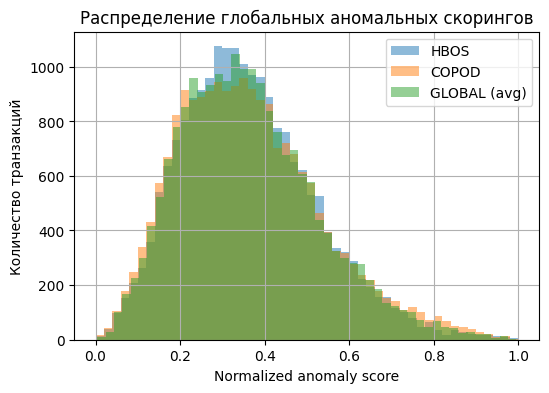

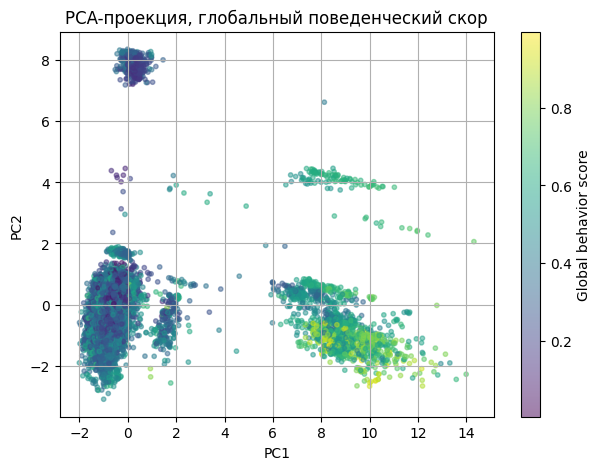

Сохранено: top_hbos_global_behavior.csv, top_copod_global_behavior.csv, top_global_behavior.csv
Топ-10 наиболее влияющих фич (по PCA-нагрузкам):
                       PCA_importance
purpose_stopword_high        0.623717
purpose_svd_4                0.567835
purpose_svd_1                0.555457
credit_roll_mean_30d         0.427196
daily_credit_percent         0.420656
debit_roll_std_30d           0.414661
debit_roll_cnt_30d           0.411628
debit_roll_mean_30d          0.385757
daily_debit_percent          0.333986
credit_roll_cnt_30d          0.331529
Форма df после добавления глобального слоя: (20207, 161)


In [8]:
# ============================================
# Глобальный поведенческий слой (HBOS + COPOD)
# Быстрый поиск аномальных операций по всей выборке
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

RANDOM_STATE = 42
GLOBAL_CONTAM = 0.02     # доля глобальных аномалий (2%)

df_g = df.copy()

# --- 0. Подстраховка по колонкам ---
base_feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",

    # риск по ключевым словам в назначении
    "purpose_stopword_high",
]

svd_cols = [f"purpose_svd_{i}" for i in range(1, 51)]
feat_cols_all = base_feat_cols + svd_cols

for c in feat_cols_all:
    if c not in df_g.columns:
        # логично заполнить 0 для числовых и 0/False для флагов
        df_g[c] = 0.0

# приведение типов флагов к float
flag_cols = ["round_large_amount","is_weekend","is_month_end","purpose_stopword_high"]
for c in flag_cols:
    if c in df_g.columns:
        df_g[c] = df_g[c].astype(float)

df_g["amount"] = df_g["amount"].astype(float)
df_g["days_since_last_txn_debit"]  = df_g["days_since_last_txn_debit"].astype(float)
df_g["days_since_last_txn_credit"] = df_g["days_since_last_txn_credit"].astype(float)

# --- 1. Лог-фичи для стабилизации хвостов ---
df_g["log_amount"] = np.log1p(df_g["amount"].abs())
df_g["log_days_since_last_debit"]  = np.log1p(df_g["days_since_last_txn_debit"].clip(lower=0))
df_g["log_days_since_last_credit"] = np.log1p(df_g["days_since_last_txn_credit"].clip(lower=0))

feat_cols = feat_cols_all + [
    "log_amount",
    "log_days_since_last_debit",
    "log_days_since_last_credit",
]

# --- 2. Подготовка матрицы признаков ---
X = df_g[feat_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- 3. HBOS ---
hbos = HBOS(contamination=GLOBAL_CONTAM)
hbos.fit(Xs)
score_hbos_raw = hbos.decision_function(Xs)  # выше — аномальнее

# нормировка в [0,1]
score_hbos = (score_hbos_raw - score_hbos_raw.min()) / (score_hbos_raw.max() - score_hbos_raw.min() + 1e-9)
df_g["hbos_score"] = score_hbos

# --- 4. COPOD ---
copod = COPOD(contamination=GLOBAL_CONTAM)
copod.fit(Xs)
score_copod_raw = copod.decision_function(Xs)

score_copod = (score_copod_raw - score_copod_raw.min()) / (score_copod_raw.max() - score_copod_raw.min() + 1e-9)
df_g["copod_score"] = score_copod

# --- 5. Интегральный глобальный скор и ранг ---
# Можно взять среднее, максимум, или взвешенную комбинацию.
df_g["global_behavior_score"] = 0.5 * df_g["hbos_score"] + 0.5 * df_g["copod_score"]

# percent-rank по всей выборке: какие операции в верхних 1–5% глобальных аномалий
df_g["global_behavior_rank"] = df_g["global_behavior_score"].rank(method="average", pct=True)

# --- 6. Визуализация распределения скоров ---
plt.figure(figsize=(6,4))
plt.hist(df_g["hbos_score"], bins=50, alpha=0.5, label="HBOS")
plt.hist(df_g["copod_score"], bins=50, alpha=0.5, label="COPOD")
plt.hist(df_g["global_behavior_score"], bins=50, alpha=0.5, label="GLOBAL (avg)")
plt.legend()
plt.title("Распределение глобальных аномальных скорингов")
plt.xlabel("Normalized anomaly score")
plt.ylabel("Количество транзакций")
plt.grid(True)
plt.show()

# --- 7. PCA для 2D-проекции (диагностика, не для продакшена) ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df_g["global_behavior_score"], s=10, alpha=0.5)
plt.colorbar(label="Global behavior score")
plt.title("PCA-проекция, глобальный поведенческий скор")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

# --- 8. Топ-N глобально подозрительных операций ---
TOP_N = 2000

top_hbos  = df_g.sort_values("hbos_score", ascending=False).head(TOP_N).copy()
top_copod = df_g.sort_values("copod_score", ascending=False).head(TOP_N).copy()
top_global = df_g.sort_values("global_behavior_score", ascending=False).head(TOP_N).copy()

cols_out = ["date","debit_inn","credit_inn","amount","purpose",
            "hbos_score","copod_score","global_behavior_score","global_behavior_rank"]

top_hbos[cols_out].to_csv("top_hbos_global_behavior.csv", index=False, encoding="utf-8-sig")
top_copod[cols_out].to_csv("top_copod_global_behavior.csv", index=False, encoding="utf-8-sig")
top_global[cols_out].to_csv("top_global_behavior.csv", index=False, encoding="utf-8-sig")

print("Сохранено: top_hbos_global_behavior.csv, top_copod_global_behavior.csv, top_global_behavior.csv")

# --- 9. Оценка вклада признаков через PCA-нагрузки (грубая диагностика) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols,
    columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)

print("Топ-10 наиболее влияющих фич (по PCA-нагрузкам):")
print(loadings.head(10))

# --- 10. Возвращаем скор обратно в основной df ---
df = df.merge(
    df_g[["txn_id","hbos_score","copod_score","global_behavior_score","global_behavior_rank"]],
    on="txn_id",
    how="left"
)

full_anomaly_scores = df.sort_values("global_behavior_score", ascending=False).copy()
print("Форма df после добавления глобального слоя:", df.shape)





## Семантический слой (анализ назначения платежа)

Этот блок использует векторные представления текста назначения (SVD по TF-IDF), чтобы измерить, насколько текущее назначение отличается от типичного текста клиента и от общей массы операций. Локальный семантический сдвиг, глобальная редкость и наличие рискованных ключевых слов объединяются в интегральный `semantic_risk_score` для приоритизации подозрительных операций по смыслу.

In [9]:


import numpy as np
import pandas as pd

df_sem = df.copy()

# --- 0. Проверяем, что есть нужные колонки ---
if "purpose" not in df_sem.columns:
    raise RuntimeError("Нет колонки 'purpose' в df.")
if "debit_inn" not in df_sem.columns or "credit_inn" not in df_sem.columns:
    raise RuntimeError("Нужны колонки 'debit_inn' и 'credit_inn'.")

svd_cols = [c for c in df_sem.columns if c.startswith("purpose_svd_")]
if not svd_cols:
    raise RuntimeError("Нет колонок purpose_svd_*. Нужны SVD-компоненты по назначению платежа.")

if "purpose_stopword_high" not in df_sem.columns:
    # если нет — создадим нулевой флаг
    df_sem["purpose_stopword_high"] = 0.0

df_sem["purpose_stopword_high"] = df_sem["purpose_stopword_high"].astype(float)

# --- 1. Локальный semantic shift по ИНН для дебета и кредита ---

def compute_semantic_shift_per_inn(df_base: pd.DataFrame,
                                   inn_col: str,
                                   suffix: str) -> pd.Series:
    """
    Для каждой строки считаем, насколько её текст (purpose_svd_*)
    далёк от "типичного" текста этого ИНН.
    dist_norm ∈ [0,1] внутри каждого ИНН.
    """
    svd_mat = df_base[svd_cols].fillna(0.0).astype(float).values
    idx_global = np.arange(len(df_base))

    # сюда положим результат
    shift = np.zeros(len(df_base), dtype=np.float32)

    # группировка по ИНН
    groups = df_base.groupby(inn_col).indices  # dict: inn -> np.array индексов

    for inn, idx_arr in groups.items():
        idx = np.asarray(idx_arr, dtype=int)
        if idx.size < 5:
            # мало данных для формирования устойчивого текстового профиля
            shift[idx] = 0.0
            continue

        X = svd_mat[idx]  # [n_txn, k]
        center = X.mean(axis=0, keepdims=True)
        std = X.std(axis=0, keepdims=True) + 1e-6

        # нормированное отклонение от исторического центра ИНН
        Z = (X - center) / std
        dist = np.sqrt((Z**2).sum(axis=1))

        d_min, d_max = dist.min(), dist.max()
        if d_max > d_min:
            dist_norm = (dist - d_min) / (d_max - d_min)
        else:
            dist_norm = np.zeros_like(dist)

        shift[idx] = dist_norm.astype(np.float32)

    col_name = f"purpose_semantic_shift_{suffix}"
    return pd.Series(shift, index=df_base.index, name=col_name)

# локальный сдвиг по дебету и кредиту
df_sem["purpose_semantic_shift_debit"] = compute_semantic_shift_per_inn(df_sem, "debit_inn", "debit")
df_sem["purpose_semantic_shift_credit"] = compute_semantic_shift_per_inn(df_sem, "credit_inn", "credit")

# агрегированный локальный сдвиг: максимум по ролям
df_sem["purpose_semantic_shift_local"] = df_sem[[
    "purpose_semantic_shift_debit",
    "purpose_semantic_shift_credit"
]].max(axis=1)

# --- 2. Глобальная семантическая редкость текста ---

# Берём вектора purpose_svd_* и считаем L2-норму отклонения от глобального центра
X_svd = df_sem[svd_cols].fillna(0.0).astype(float).values
global_center = X_svd.mean(axis=0, keepdims=True)
global_std = X_svd.std(axis=0, keepdims=True) + 1e-6

Zg = (X_svd - global_center) / global_std
dist_global = np.sqrt((Zg**2).sum(axis=1))

# нормируем глобальную дистанцию в [0,1]
dg_min, dg_max = dist_global.min(), dist_global.max()
if dg_max > dg_min:
    dist_global_norm = (dist_global - dg_min) / (dg_max - dg_min)
else:
    dist_global_norm = np.zeros_like(dist_global)

df_sem["purpose_semantic_global_outlier"] = dist_global_norm.astype(np.float32)

# --- 3. Keyword-risk (назначение содержит рискованные слова) ---

df_sem["purpose_keyword_risk"] = df_sem["purpose_stopword_high"].astype(float)
# по смыслу: 0 или 1, но оставляем float для совместимости с дальнейшей агрегацией

# --- 4. Итоговый semantic_risk_score ---

# веса можно потом подстроить, сейчас разумный первый вариант:
# локальный сдвиг важнее всего (0.5),
# глобальная редкость (0.3),
# ключевые слова (0.2).
w_local = 0.5
w_global = 0.3
w_kw = 0.2

semantic_raw = (
    w_local * df_sem["purpose_semantic_shift_local"] +
    w_global * df_sem["purpose_semantic_global_outlier"] +
    w_kw * df_sem["purpose_keyword_risk"]
)

# приводим к [0,1] на всякий случай
s_min, s_max = semantic_raw.min(), semantic_raw.max()
if s_max > s_min:
    semantic_score = (semantic_raw - s_min) / (s_max - s_min)
else:
    semantic_score = pd.Series(0.0, index=df_sem.index)

df_sem["semantic_risk_score"] = semantic_score.astype(np.float32)

# ранговый скор по всей выборке (0..1): 1 = в топе по семантическому риску
df_sem["semantic_risk_rank"] = df_sem["semantic_risk_score"].rank(method="average", pct=True)

print("Семантический слой рассчитан.")
print("Колонки добавлены в df_sem:")
print([
    "purpose_semantic_shift_debit",
    "purpose_semantic_shift_credit",
    "purpose_semantic_shift_local",
    "purpose_semantic_global_outlier",
    "purpose_keyword_risk",
    "semantic_risk_score",
    "semantic_risk_rank",
])

# --- 5. Понятный вывод: топ-операции по семантическому риску ---

TOP_N = 50

cols_show = [
    "date","debit_inn","credit_inn","amount","purpose",
    "purpose_keyword_risk",
    "purpose_semantic_shift_debit",
    "purpose_semantic_shift_credit",
    "purpose_semantic_shift_local",
    "purpose_semantic_global_outlier",
    "semantic_risk_score",
    "semantic_risk_rank",
]

top_semantic = df_sem.sort_values("semantic_risk_score", ascending=False).head(TOP_N)[cols_show]

print(f"\nТоп-{TOP_N} операций по семантическому риску:")
display(top_semantic)

# --- 6. Краткая сводка по распределению скоров ---

print("\nРаспределение semantic_risk_score:")
print(df_sem["semantic_risk_score"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


if 'txn_id' not in df_sem:
    print(True)
    df_sem['txn_id'] = df.apply(make_txn_id, axis=1)





Семантический слой рассчитан.
Колонки добавлены в df_sem:
['purpose_semantic_shift_debit', 'purpose_semantic_shift_credit', 'purpose_semantic_shift_local', 'purpose_semantic_global_outlier', 'purpose_keyword_risk', 'semantic_risk_score', 'semantic_risk_rank']

Топ-50 операций по семантическому риску:


,date,debit_inn,credit_inn,amount,purpose,purpose_keyword_risk,purpose_semantic_shift_debit,purpose_semantic_shift_credit,purpose_semantic_shift_local,purpose_semantic_global_outlier,semantic_risk_score,semantic_risk_rank
8825,2019-02-28,6d140207bf61f5a0,ac50b92c56f08dac,399.23,ОПЛАТА долга ПО СЧЕТАМ ОТ 24.11.2119Г и от DA...,1.0,1.000000,0.537617,1.000000,0.541525,1.000000,1.000000
723,2019-01-10,ac50b92c56f08dac,c021d9791a1adc52,2000000.00,Оплата по Агентскому договору № М1-2114 от 11....,1.0,0.325019,1.000000,1.000000,0.332107,0.926411,0.999951
1783,2019-01-15,b227f6be5af9ec15,ac50b92c56f08dac,7482.93,"ТЕЦ11112325 от DATE_cfae8e935fa9,ТЕЦ11112324 о...",0.0,0.564564,1.000000,1.000000,0.990380,0.923461,0.999901
4486,2019-02-04,b227f6be5af9ec15,ac50b92c56f08dac,9070.48,"ТЕЦ11111497 от DATE_b8ad07dc5685,ТЕЦ11111496 о...",0.0,0.677783,0.990382,0.990382,1.000000,0.921209,0.999852
6859,2019-02-18,a6297813cb7f7c06,ac50b92c56f08dac,22778.00,оплата по накладной № ТЕЦ11111215 от DATE_3480...,0.0,1.000000,0.941468,1.000000,0.974853,0.918005,0.999802
3125,2019-01-24,b19e00f903192faa,ac50b92c56f08dac,26484.32,"Оплата за товар По 1721 от DATE_cfae8e935fa9, ...",0.0,1.000000,0.977700,1.000000,0.966342,0.915014,0.999753
482,2019-01-09,4a678c081ddefd64,ac50b92c56f08dac,3087.12,Оплата счет-фактуры № ТЕЦ11111118 от 13.11.211...,0.0,1.000000,0.920518,1.000000,0.939878,0.905715,0.999703
9122,2019-03-01,ac50b92c56f08dac,8d9e0be733f77f1c,112862.24,РОП 191226rv.d11 Отражено по операции с картой...,1.0,0.975315,0.676274,0.975315,0.299116,0.900361,0.999654
1086,2019-01-11,420456b9693e67ea,ac50b92c56f08dac,7172.01,№11112174 от DATE_cfae8e935fa9 г. №11112175 от...,0.0,0.973971,0.966059,0.973971,0.956747,0.896398,0.999604
13221,2019-03-26,678e22912c3cf5ce,ac50b92c56f08dac,13629.49,"оплата за товар, счет-фактура № ТЕЦ11128152 от...",0.0,1.000000,0.885884,1.000000,0.905839,0.893754,0.999555



Распределение semantic_risk_score:
count    20207.000000
mean         0.374086
std          0.189803
min          0.000000
50%          0.346231
90%          0.642361
95%          0.708555
99%          0.816929
max          1.000000
Name: semantic_risk_score, dtype: float64


## Слой анализа временных рядов (TS-layer)

Этот блок переводит операции в дневные ряды по каждому ИНН (отдельно по дебету и кредиту) и измеряет, насколько конкретный день выбивается из типичного поведения клиента. Робастные z-score по дневному обороту, числу операций, дисбалансу потоков и доле «круглых» сумм агрегируются в `ts_anomaly_score_*`, а затем переносятся на уровень транзакции как `ts_anomaly_score_txn` и ранги аномальности по всей выборке.


In [10]:


import numpy as np
import pandas as pd

df_ts = df_sem.copy()

# --- 0. Базовая подготовка ---

# Убедимся, что есть дата
if "date" not in df_ts.columns:
    raise RuntimeError("В df нет колонки 'date'.")

df_ts["date"] = pd.to_datetime(df_ts["date"]).dt.normalize()

# Подстраховка по важным фичам, которые будем использовать
safe_zero_cols = [
    "daily_total_debit", "daily_total_credit",
    "daily_debit_transaction_count", "daily_credit_transaction_count",
    "in_out_ratio_30d", "net_flow_ratio_7d",
    "client_round_ratio_30d",
]
for c in safe_zero_cols:
    if c not in df_ts.columns:
        df_ts[c] = 0.0

df_ts["daily_total_debit"] = df_ts["daily_total_debit"].astype(float)
df_ts["daily_total_credit"] = df_ts["daily_total_credit"].astype(float)
df_ts["daily_debit_transaction_count"] = df_ts["daily_debit_transaction_count"].astype(float)
df_ts["daily_credit_transaction_count"] = df_ts["daily_credit_transaction_count"].astype(float)
df_ts["in_out_ratio_30d"] = df_ts["in_out_ratio_30d"].astype(float)
df_ts["net_flow_ratio_7d"] = df_ts["net_flow_ratio_7d"].astype(float)
df_ts["client_round_ratio_30d"] = df_ts["client_round_ratio_30d"].astype(float)

# Параметры слоя
MIN_ACTIVE_DAYS = 10   # минимальное количество "активных дней" по ИНН, чтобы строить TS-профиль


# --- 1. Вспомогательная функция: robust z-score по ряду ---

def robust_zscore(series: pd.Series) -> pd.Series:
    """
    Робастный z-score относительно медианы и MAD.
    |z| = |x - median| / (MAD + eps), где MAD = median(|x - median|)
    """
    x = series.astype(float)
    med = x.median()
    mad = np.median(np.abs(x - med)) + 1e-6
    z = (x - med) / (mad * 1.4826)  # 1.4826 ~ калибровка под std
    return z.abs()  # нам важна величина отклонения


# --- 2. Строим дневные ряды по дебету и кредиту ---

# 2.1. Дебет: дневная активность по debit_inn
if "debit_inn" not in df_ts.columns:
    raise RuntimeError("Нет колонки 'debit_inn'.")

deb_daily = (df_ts
    .groupby(["debit_inn", "date"], as_index=False)
    .agg(
        daily_total_debit=("daily_total_debit", "first"),
        daily_cnt_debit=("daily_debit_transaction_count", "first"),
        in_out_ratio=("in_out_ratio_30d", "first"),
        net_flow_ratio=("net_flow_ratio_7d", "first"),
        client_round_ratio=("client_round_ratio_30d", "first"),
    )
)

deb_daily["daily_total_debit"] = deb_daily["daily_total_debit"].astype(float)
deb_daily["daily_cnt_debit"] = deb_daily["daily_cnt_debit"].astype(float)
deb_daily["in_out_ratio"] = deb_daily["in_out_ratio"].astype(float)
deb_daily["net_flow_ratio"] = deb_daily["net_flow_ratio"].astype(float)
deb_daily["client_round_ratio"] = deb_daily["client_round_ratio"].astype(float)

# активный день по дебету: есть движение
deb_daily["is_active_day"] = (deb_daily["daily_total_debit"].abs() > 0).astype(int)

# 2.2. Кредит: дневная активность по credit_inn
if "credit_inn" not in df_ts.columns:
    raise RuntimeError("Нет колонки 'credit_inn'.")

cred_daily = (df_ts
    .groupby(["credit_inn", "date"], as_index=False)
    .agg(
        daily_total_credit=("daily_total_credit", "first"),
        daily_cnt_credit=("daily_credit_transaction_count", "first"),
        in_out_ratio=("in_out_ratio_30d", "first"),
        net_flow_ratio=("net_flow_ratio_7d", "first"),
        client_round_ratio=("client_round_ratio_30d", "first"),
    )
)

cred_daily["daily_total_credit"] = cred_daily["daily_total_credit"].astype(float)
cred_daily["daily_cnt_credit"] = cred_daily["daily_cnt_credit"].astype(float)
cred_daily["in_out_ratio"] = cred_daily["in_out_ratio"].astype(float)
cred_daily["net_flow_ratio"] = cred_daily["net_flow_ratio"].astype(float)
cred_daily["client_round_ratio"] = cred_daily["client_round_ratio"].astype(float)

cred_daily["is_active_day"] = (cred_daily["daily_total_credit"].abs() > 0).astype(int)


# --- 3. Считаем TS-аномалии по дебету и кредиту отдельно ---

def compute_ts_anomaly_for_side(df_side: pd.DataFrame,
                                inn_col: str,
                                total_col: str,
                                cnt_col: str,
                                prefix: str) -> pd.DataFrame:
    """
    df_side: DataFrame с колонками [inn_col, 'date', total_col, cnt_col, 'in_out_ratio', 'net_flow_ratio', 'client_round_ratio', 'is_active_day']
    Для каждого ИНН:
        - рассматриваем только активные дни (is_active_day=1)
        - если активных дней < MIN_ACTIVE_DAYS → присваиваем 0
        - иначе считаем робастный z-score по нескольким показателям и агрегируем
    Возвращаем df_side с колонками:
        ts_anomaly_raw_<prefix>, ts_anomaly_score_<prefix>
    """
    df_out = df_side.copy()
    df_out[f"ts_anomaly_raw_{prefix}"] = 0.0
    df_out[f"ts_anomaly_score_{prefix}"] = 0.0

    # группировка по ИНН
    for inn, idx in df_out.groupby(inn_col).indices.items():
        idx = np.asarray(idx, dtype=int)
        sub = df_out.iloc[idx]

        # активные дни
        active_mask = (sub["is_active_day"] == 1)
        active_idx = idx[active_mask.values]

        if active_idx.size < MIN_ACTIVE_DAYS:
            # не хватает истории, чтобы строить TS-профиль
            df_out.loc[idx, f"ts_anomaly_raw_{prefix}"] = 0.0
            df_out.loc[idx, f"ts_anomaly_score_{prefix}"] = 0.0
            continue

        sub_active = df_out.loc[active_idx]

        # робастные z-score по нескольким метрикам
        z_total = robust_zscore(sub_active[total_col])
        z_cnt = robust_zscore(sub_active[cnt_col])
        z_inout = robust_zscore(sub_active["in_out_ratio"])
        z_net = robust_zscore(sub_active["net_flow_ratio"])
        z_round = robust_zscore(sub_active["client_round_ratio"])

        # агрегированный "сырое" отклонение по дню
        # можно брать среднее или сумму
        raw = (z_total + z_cnt + z_inout + z_net + z_round) / 5.0

        # нормируем по ИНН на [0,1] среди активных дней
        r_min, r_max = raw.min(), raw.max()
        if r_max > r_min:
            score = (raw - r_min) / (r_max - r_min)
        else:
            score = pd.Series(0.0, index=raw.index)

        # записываем обратно только активные дни
        df_out.loc[active_idx, f"ts_anomaly_raw_{prefix}"] = raw.values
        df_out.loc[active_idx, f"ts_anomaly_score_{prefix}"] = score.values

        # неактивные дни (total=0) считаем нейтральными (0)
        inactive_idx = idx[~active_mask.values]
        if inactive_idx.size > 0:
            df_out.loc[inactive_idx, f"ts_anomaly_raw_{prefix}"] = 0.0
            df_out.loc[inactive_idx, f"ts_anomaly_score_{prefix}"] = 0.0

    return df_out


# 3.1. TS-аномалии для дебета
deb_daily_ts = compute_ts_anomaly_for_side(
    df_side=deb_daily,
    inn_col="debit_inn",
    total_col="daily_total_debit",
    cnt_col="daily_cnt_debit",
    prefix="debit"
)

# 3.2. TS-аномалии для кредита
cred_daily_ts = compute_ts_anomaly_for_side(
    df_side=cred_daily,
    inn_col="credit_inn",
    total_col="daily_total_credit",
    cnt_col="daily_cnt_credit",
    prefix="credit"
)


# --- 4. Переносим дневной TS-анализ обратно на транзакции ---

# мерж по дебету: каждой транзакции (debit_inn, date) присваиваем дневной ts_score_debit
df_ts = df_ts.merge(
    deb_daily_ts[["debit_inn", "date", "ts_anomaly_score_debit"]],
    on=["debit_inn", "date"],
    how="left"
)

# мерж по кредиту: каждой транзакции (credit_inn, date) присваиваем дневной ts_score_credit
df_ts = df_ts.merge(
    cred_daily_ts[["credit_inn", "date", "ts_anomaly_score_credit"]],
    on=["credit_inn", "date"],
    how="left"
)

# пустые значения заменяем на 0 (например, если ИНН не набрал MIN_ACTIVE_DAYS или без движения)
df_ts["ts_anomaly_score_debit"] = df_ts["ts_anomaly_score_debit"].fillna(0.0)
df_ts["ts_anomaly_score_credit"] = df_ts["ts_anomaly_score_credit"].fillna(0.0)

# общий TS-скор по транзакции: максимум по дебету/кредиту
df_ts["ts_anomaly_score_txn"] = df_ts[["ts_anomaly_score_debit", "ts_anomaly_score_credit"]].max(axis=1)

# ранговый TS-скор по всей выборке (0..1): 1 = верхние аномалии по временным рядам
df_ts["ts_anomaly_rank_txn"] = df_ts["ts_anomaly_score_txn"].rank(method="average", pct=True)

print("TS-слой рассчитан.")
print("Колонки добавлены в df_ts:")
print([
    "ts_anomaly_score_debit",
    "ts_anomaly_score_credit",
    "ts_anomaly_score_txn",
    "ts_anomaly_rank_txn",
])


# --- 5. Понятный вывод: топ-аномальные дни и транзакции ---

# 5.1. Топ-аномальные дни по дебету
top_days_deb = (deb_daily_ts
    .sort_values("ts_anomaly_score_debit", ascending=False)
    .head(50)
    .copy()
)

print("\nТоп-50 аномальных дней по дебету (ИНН, дата):")
display(top_days_deb[[
    "debit_inn", "date",
    "daily_total_debit", "daily_cnt_debit",
    "in_out_ratio", "net_flow_ratio", "client_round_ratio",
    "ts_anomaly_score_debit"
]])

# 5.2. Топ-аномальные дни по кредиту
top_days_cred = (cred_daily_ts
    .sort_values("ts_anomaly_score_credit", ascending=False)
    .head(50)
    .copy()
)

print("\nТоп-50 аномальных дней по кредиту (ИНН, дата):")
display(top_days_cred[[
    "credit_inn", "date",
    "daily_total_credit", "daily_cnt_credit",
    "in_out_ratio", "net_flow_ratio", "client_round_ratio",
    "ts_anomaly_score_credit"
]])

# 5.3. Топ-аномальные транзакции по TS-слою
TOP_TXN = 100
cols_show_txn = [
    "date", "debit_inn", "credit_inn", "amount", "purpose",
    "ts_anomaly_score_debit", "ts_anomaly_score_credit",
    "ts_anomaly_score_txn", "ts_anomaly_rank_txn",
]

top_txn_ts = (df_ts
    .sort_values("ts_anomaly_score_txn", ascending=False)
    .head(TOP_TXN)
    .copy()
)

print(f"\nТоп-{TOP_TXN} транзакций по TS-аномалии:")
display(top_txn_ts[cols_show_txn])

# --- 6. При желании: возвращаем TS-скоры в основной df ---

df = df_ts.copy()
print("Форма df после добавления TS-слоя:", df.shape)


TS-слой рассчитан.
Колонки добавлены в df_ts:
['ts_anomaly_score_debit', 'ts_anomaly_score_credit', 'ts_anomaly_score_txn', 'ts_anomaly_rank_txn']

Топ-50 аномальных дней по дебету (ИНН, дата):


,debit_inn,date,daily_total_debit,daily_cnt_debit,in_out_ratio,net_flow_ratio,client_round_ratio,ts_anomaly_score_debit
10208,e45c1e79014ae071,2019-03-04,82881.48,0.0,0.0,1.0,0.0,1.0
369,07e30b64e5adb119,2019-04-25,77331.39,0.0,0.0,1.0,0.0,1.0
3999,63b2e762cfeafa47,2019-01-11,65417.12,0.0,0.0,1.0,0.0,1.0
3995,6334fad538d6706a,2019-04-04,150000.00,0.0,0.0,1.0,0.0,1.0
10598,ef04d80ac4174513,2019-02-01,43369.39,0.0,0.0,1.0,0.0,1.0
735,12d2cc1f2d077e3d,2019-01-10,152931.82,0.0,0.0,1.0,0.0,1.0
6953,a256acfcd4e95294,2019-04-09,27121.21,0.0,0.0,1.0,0.0,1.0
8910,c9b60beb23fff01e,2019-01-31,44997.14,0.0,0.0,1.0,0.0,1.0
10957,f76c82f71ad2b080,2019-01-29,4533.29,0.0,0.0,1.0,0.0,1.0
4690,746a27f08a635eb4,2019-04-16,57095.76,0.0,0.0,1.0,0.0,1.0



Топ-50 аномальных дней по кредиту (ИНН, дата):


,credit_inn,date,daily_total_credit,daily_cnt_credit,in_out_ratio,net_flow_ratio,client_round_ratio,ts_anomaly_score_credit
978,f099570e85fce4f7,2019-04-05,767000.00,0.0,0.0,-1.0,0.0,1.000000
410,8d9e0be733f77f1c,2019-03-20,2713229.72,0.0,0.0,-1.0,0.0,1.000000
776,c73c7d4b3aadb022,2019-05-07,3994896.01,0.0,0.0,-1.0,0.0,1.000000
848,da57ed5cdee39574,2019-03-11,35500.00,0.0,0.0,-1.0,0.0,1.000000
243,62ff58a9bb0efe6b,2019-02-22,1361801.00,0.0,0.0,-1.0,0.0,1.000000
757,c43bf25457df0422,2019-05-08,2053059.20,0.0,0.0,-1.0,0.0,1.000000
998,f4efb233746f625b,2019-03-11,300000.00,0.0,0.0,-1.0,0.0,1.000000
311,7fb45df96f63ab19,2019-01-23,3294425.60,0.0,0.0,-1.0,0.0,1.000000
892,e3b689f5397ec9b9,2019-02-27,450639.00,0.0,0.0,-1.0,0.0,1.000000
107,2fa1a5c620cf1cd6,2019-04-09,4000000.00,0.0,0.0,-1.0,0.0,1.000000



Топ-100 транзакций по TS-аномалии:


,date,debit_inn,credit_inn,amount,purpose,ts_anomaly_score_debit,ts_anomaly_score_credit,ts_anomaly_score_txn,ts_anomaly_rank_txn
9111,2019-03-01,57828af4d4b2025f,ac50b92c56f08dac,3111.00,Оплата по счету № 16683 от DATE_f221341d11bc ...,1.0,0.032336,1.0,0.959841
3063,2019-01-24,fd398d30919efd23,ac50b92c56f08dac,28829.76,"Оплата по счет-фактуре № ТЕЦ11113181,3181,3189...",1.0,0.147402,1.0,0.959841
1124,2019-01-11,98b4258a80e85798,ac50b92c56f08dac,8383.06,оплата товара по расходным накладным №ТЕЦ11163...,1.0,0.330969,1.0,0.959841
1122,2019-01-11,74b1101a891a1adb,ac50b92c56f08dac,17385.99,Оплата УПД N ТЕЦ11158137 от 25.12 2118 за това...,1.0,0.330969,1.0,0.959841
8627,2019-02-27,738db7b3f74f7cba,ac50b92c56f08dac,15459.72,"Оплата за товар, согл. с/ф ТЭЦ11121295 от 24.1...",1.0,0.006468,1.0,0.959841
...,...,...,...,...,...,...,...,...,...
1079,2019-01-11,44c6455756f6f55c,ac50b92c56f08dac,803.40,"Оплата по счету №ТЕЦ 2253 от 11,11,2119.12.211...",1.0,0.330969,1.0,0.959841
8742,2019-02-28,a6d054e82fc2279d,ac50b92c56f08dac,101927.25,Оплата за продтовары согласно счет-факт 12325 ...,1.0,0.044047,1.0,0.959841
10017,2019-03-07,48ba48a629da71f8,ac50b92c56f08dac,16202.23,сч/ф№19233-18988-19184 DATE_ac83f3b7c571 В том...,1.0,0.106840,1.0,0.959841
12990,2019-03-26,43791d8a81cedeaa,ac50b92c56f08dac,4477.20,27826 ОТ 14.13.19 НДС не облагается.,1.0,0.248338,1.0,0.959841


Форма df после добавления TS-слоя: (20207, 176)


In [11]:
df.columns

Index(['date', 'debit_account', 'debit_name', 'debit_inn', 'credit_account',
       'credit_name', 'credit_inn', 'debit_amount', 'credit_amount', 'purpose',
       ...
       'semantic_risk_score', 'semantic_risk_rank',
       'daily_debit_transaction_count', 'daily_credit_transaction_count',
       'in_out_ratio_30d', 'client_round_ratio_30d', 'ts_anomaly_score_debit',
       'ts_anomaly_score_credit', 'ts_anomaly_score_txn',
       'ts_anomaly_rank_txn'],
      dtype='object', length=176)

## Итоговая интеграция рисков

Этот блок объединяет все ранее рассчитанные слои в единый показатель риска транзакции.  
Сначала выбирается базовый поведенческий риск — баланс между индивидуальной моделью клиента (IsolationForest) и глобальной моделью по всей выборке (HBOS/COPOD).  
Затем итог корректируется дополнительными сигналами: семантикой назначения, временными рядами и графовыми признаками.  
Результат — `txn_risk_score`, комплексная оценка подозрительности операции.


In [12]:
# ============================================
# Итоговая интеграция:
# 1) Сначала: индивидуальная vs глобальная поведенческая модель
# 2) Потом: корректировки семантикой, TS и графом
# ============================================

import numpy as np
import pandas as pd

df_int = df.copy()

# --- -1. Защита от раздувания: схлопываем до 1 строки на txn_id ---
if "txn_id" in df_int.columns:
    print("До дедупликации:",
          "строк =", len(df_int),
          "уникальных txn_id =", df_int["txn_id"].nunique())

    # числовые и нечисловые колонки
    num_cols = df_int.select_dtypes(include=[np.number]).columns.tolist()
    if "txn_id" in num_cols:
        num_cols.remove("txn_id")

    cat_cols = [c for c in df_int.columns if c not in num_cols and c != "txn_id"]

    agg_dict = {}
    # для числовых — максимум (по скорам это безопасно)
    for c in num_cols:
        agg_dict[c] = "max"
    # для категориальных — первая попавшаяся
    for c in cat_cols:
        agg_dict[c] = "first"

    df_int = (
        df_int
        .sort_values(["txn_id"])
        .groupby("txn_id", as_index=False)
        .agg(agg_dict)
        .reset_index(drop=True)
    )

    print("После дедупликации:",
          "строк =", len(df_int),
          "уникальных txn_id =", df_int["txn_id"].nunique())
else:
    print("В df_int нет txn_id — защитная дедупликация по транзакциям не применена.")

# --- 0. Параметры и защита ---
try:
    MIN_TX_PER_INN
except NameError:
    MIN_TX_PER_INN = 10  # порог, с которого начинаем хоть как-то доверять индивидуальному профилю

def get_col_safe(frame, col, default_value=0.0):
    """
    Берём колонку как float, все NaN внутри считаем «нет сигнала» и заменяем на default_value.
    Если колонки нет — возвращаем константу default_value.
    """
    if col in frame.columns:
        s = pd.to_numeric(frame[col], errors="coerce")
        return s.fillna(default_value).astype(float)
    return pd.Series(default_value, index=frame.index, dtype=float)



# --- 1. Глобальный поведенческий скор (общая модель) ---


# --- 1. Глобальный поведенческий скор (общая модель) ---

if "global_behavior_score" in df_int.columns:
    # если есть готовый глобальный скор – просто чистим и используем
    g = df_int["global_behavior_score"].astype(float)
else:
    # иначе считаем как среднее HBOS и COPOD
    hbos  = df_int["hbos_score"].astype(float)  if "hbos_score"  in df_int.columns else pd.Series(np.nan, index=df_int.index)
    copod = df_int["copod_score"].astype(float) if "copod_score" in df_int.columns else pd.Series(np.nan, index=df_int.index)
    g = (hbos + copod) / 2.0

# глобальное среднее по тем, где что-то есть
global_mean = float(np.nanmean(g)) if not np.all(np.isnan(g)) else 0.5

# подстраховка: там, где g NaN, ставим global_mean
g = g.fillna(global_mean).clip(0, 1)
df_int["global_score"] = g
glob = df_int["global_score"]

# --- 2. Индивидуальные скоринги IsolationForest (по ИНН) ---

if "iforest_score_debit" not in df_int.columns:
    df_int["iforest_score_debit"] = np.nan
if "iforest_score_credit" not in df_int.columns:
    df_int["iforest_score_credit"] = np.nan

df_int["iforest_score_debit"]  = df_int["iforest_score_debit"].astype(float)
df_int["iforest_score_credit"] = df_int["iforest_score_credit"].astype(float)

has_iforest_deb  = df_int["iforest_score_debit"].notna()
has_iforest_cred = df_int["iforest_score_credit"].notna()


# --- 3. Считаем доверие к индивидуальной модели: alpha_debit / alpha_credit ---

counts_deb  = df_int.groupby("debit_inn").size()
counts_cred = df_int.groupby("credit_inn").size()

n_deb  = df_int["debit_inn"].map(counts_deb).fillna(0).astype(int)
n_cred = df_int["credit_inn"].map(counts_cred).fillna(0).astype(int)

max_n_deb  = max(int(counts_deb.max()) if len(counts_deb) else 1, MIN_TX_PER_INN)
max_n_cred = max(int(counts_cred.max()) if len(counts_cred) else 1, MIN_TX_PER_INN)

alpha_deb_raw  = 0.35 + 0.5 * np.log1p(n_deb)  / np.log1p(max_n_deb)
alpha_cred_raw = 0.35 + 0.5 * np.log1p(n_cred) / np.log1p(max_n_cred)

alpha_deb  = np.clip(alpha_deb_raw,  0.35, 0.85)
alpha_cred = np.clip(alpha_cred_raw, 0.35, 0.85)

# где нет индивидуального скора — доверие к индивидуальной модели = 0
alpha_deb  = np.where(has_iforest_deb,  alpha_deb,  0.0)
alpha_cred = np.where(has_iforest_cred, alpha_cred, 0.0)

df_int["alpha_debit"]  = alpha_deb
df_int["alpha_credit"] = alpha_cred


# --- 4. Шаг 1: выбираем основу поведения (индивидуальная vs глобальная) ---

# если индивидуальная модель есть, то individual_score берем как isoforest, иначе 0 (но alpha=0 → не влияет)
ind_deb  = df_int["iforest_score_debit"].fillna(0.0)
ind_cred = df_int["iforest_score_credit"].fillna(0.0)
glob     = df_int["global_score"].fillna(0.0)

# поведенческий риск по роли:
# base_behavior_role = alpha * individual + (1 - alpha) * global
base_behavior_deb  = alpha_deb  * ind_deb  + (1.0 - alpha_deb)  * glob
base_behavior_cred = alpha_cred * ind_cred + (1.0 - alpha_cred) * glob

df_int["behavior_risk_debit"]  = base_behavior_deb.clip(0, 1)
df_int["behavior_risk_credit"] = base_behavior_cred.clip(0, 1)

# итоговый поведенческий риск транзакции:
# если есть обе роли → пессимистично берём максимум
# если только одна → берём её
# если ни одной (крайний случай) → берём global_score
has_any_side = has_iforest_deb | has_iforest_cred

base_behavior_txn = np.where(
    has_any_side,
    np.maximum(df_int["behavior_risk_debit"], df_int["behavior_risk_credit"]),
    glob
)

df_int["base_behavior_risk"] = pd.Series(base_behavior_txn, index=df_int.index).clip(0, 1)


# --- 5. Шаг 2: корректоры (семантика, TS, граф) ---
# они НЕ участвуют в выборе между индивидуальной и глобальной моделью,
# только смещают итоговый риск вокруг выбранной основы

semantic   = get_col_safe(df_int, "semantic_risk_score", 0.0)
ts_score   = get_col_safe(df_int, "ts_anomaly_score_txn", 0.0)
graph_edge = get_col_safe(df_int, "graph_edge_score", 0.0)
graph_node = get_col_safe(df_int, "graph_node_score", 0.0)
graph_risk = np.maximum(graph_edge, graph_node)


# веса внутри корректирующего блока (между собой)
w_semantic = 0.5
w_ts       = 0.3
w_graph    = 0.2

components_corr = {
    "semantic": (semantic, w_semantic),
    "ts":       (ts_score, w_ts),
    "graph":    (graph_risk, w_graph),
}

weights_used_corr = {}
for name, (series, w) in components_corr.items():
    if series.max() > 0:  # компонент действительно что-то даёт
        weights_used_corr[name] = w

if not weights_used_corr:
    correction_score = pd.Series(0.0, index=df_int.index)
else:
    total_w_corr = sum(weights_used_corr.values())
    corr = 0.0
    for name, w in weights_used_corr.items():
        corr += (w / total_w_corr) * components_corr[name][0]
    correction_score = pd.Series(corr, index=df_int.index).clip(0, 1)

df_int["correction_score"] = correction_score

# коэффициент влияния корректоров на итоговый риск:
# 0.0 → игнорировать, 1.0 → корректоры могут подвинуть риск на полную шкалу
GAMMA = 0.5

final_risk = df_int["base_behavior_risk"] + GAMMA * df_int["correction_score"]
df_int["txn_risk_score"] = final_risk.clip(0, 1)

# ранговый риск для удобства
df_int["txn_risk_rank"] = df_int["txn_risk_score"].rank(method="average", pct=True)


# --- 6. Сохранение результата для анализа ---

cols_out = [
    "date","debit_inn","credit_inn","amount","purpose",

    # базовые поведенческие слои
    "hbos_score" ,
    "copod_score" ,
    "global_score",
    "iforest_score_debit","iforest_score_credit",
    "alpha_debit","alpha_credit",
    "behavior_risk_debit","behavior_risk_credit",
    "base_behavior_risk",

    # корректоры
    "semantic_risk_score" ,
    "ts_anomaly_score_txn",
    "graph_edge_score" ,
    "graph_node_score",
    "correction_score",

    # итог
    "txn_risk_score","txn_risk_rank",
]

cols_out = [c for c in cols_out if c is not None]

top_final = df_int.sort_values("txn_risk_score", ascending=False).copy()
top_final[cols_out].to_csv("top_txn_final_behavior_plus_corrections.csv",
                           index=False, encoding="utf-8-sig")
print("Сохранено: top_txn_final_behavior_plus_corrections.csv")

# при необходимости переопределяем исходный df
df = df_int
print("Форма df после интеграции:", df.shape)


До дедупликации: строк = 20207 уникальных txn_id = 20168
После дедупликации: строк = 20168 уникальных txn_id = 20168
Сохранено: top_txn_final_behavior_plus_corrections.csv
Форма df после интеграции: (20168, 187)


In [13]:
df["txn_risk_rank"]

0        0.321648
1        0.432467
2        0.854869
3        0.339647
4        0.628818
           ...   
20163    0.982770
20164    0.083052
20165    0.982770
20166    0.165262
20167    0.606605
Name: txn_risk_rank, Length: 20168, dtype: float64

In [14]:
df_int[df_int["copod_score"].isna()]

,txn_id,debit_amount,credit_amount,amount,day_of_week,is_weekend,is_month_end,month,weekofyear,log_amount,...,iforest_score_debit,iforest_score_credit,alpha_debit,alpha_credit,behavior_risk_debit,behavior_risk_credit,base_behavior_risk,correction_score,txn_risk_score,txn_risk_rank


In [15]:
df_int[df_int["txn_risk_score"].isna()]

,txn_id,debit_amount,credit_amount,amount,day_of_week,is_weekend,is_month_end,month,weekofyear,log_amount,...,iforest_score_debit,iforest_score_credit,alpha_debit,alpha_credit,behavior_risk_debit,behavior_risk_credit,base_behavior_risk,correction_score,txn_risk_score,txn_risk_rank


In [16]:
print("Всего строк в df:", len(df))
print("Уникальных txn_id:", df["txn_id"].nunique())

dups = df[df.duplicated("txn_id", keep=False)].sort_values("txn_id")
print("Строк с дублирующимися txn_id:", len(dups))
dups.head(10)

Всего строк в df: 20168
Уникальных txn_id: 20168
Строк с дублирующимися txn_id: 0


,txn_id,debit_amount,credit_amount,amount,day_of_week,is_weekend,is_month_end,month,weekofyear,log_amount,...,iforest_score_debit,iforest_score_credit,alpha_debit,alpha_credit,behavior_risk_debit,behavior_risk_credit,base_behavior_risk,correction_score,txn_risk_score,txn_risk_rank


In [17]:
cols_out

['date',
 'debit_inn',
 'credit_inn',
 'amount',
 'purpose',
 'hbos_score',
 'copod_score',
 'global_score',
 'iforest_score_debit',
 'iforest_score_credit',
 'alpha_debit',
 'alpha_credit',
 'behavior_risk_debit',
 'behavior_risk_credit',
 'base_behavior_risk',
 'semantic_risk_score',
 'ts_anomaly_score_txn',
 'graph_edge_score',
 'graph_node_score',
 'correction_score',
 'txn_risk_score',
 'txn_risk_rank']

['date',
 'debit_inn',
 'credit_inn',
 'debit_amount',
 'credit_amount',
 'purpose',
 'amount',
 'day_of_week',
 'is_weekend',
 'is_month_end',
 'month',
 'weekofyear',
 'daily_total_debit',
 'daily_total_credit',
 'daily_debit_transaction_count',
 'daily_credit_transaction_count',
 'unique_recipients_per_day',
 'unique_receivers_per_day',
 'daily_debit_percent',
 'daily_credit_percent',
 'days_since_last_txn_debit',
 'days_since_last_txn_credit',
 'debit_roll_sum_7d',
 'debit_roll_cnt_7d',
 'debit_roll_mean_7d',
 'debit_roll_std_7d',
 'debit_roll_p95_7d',
 'debit_roll_sum_14d',
 'debit_roll_cnt_14d',
 'debit_roll_mean_14d',
 'debit_roll_std_14d',
 'debit_roll_p95_14d',
 'debit_roll_sum_30d',
 'debit_roll_cnt_30d',
 'debit_roll_mean_30d',
 'debit_roll_std_30d',
 'debit_roll_p95_30d',
 'debit_roll_sum_90d',
 'debit_roll_cnt_90d',
 'debit_roll_mean_90d',
 'debit_roll_std_90d',
 'debit_roll_p95_90d',
 'credit_roll_sum_7d',
 'credit_roll_cnt_7d',
 'credit_roll_mean_7d',
 'credit_roll_std_7d',
 'credit_roll_p95_7d',
 'credit_roll_sum_14d',
 'credit_roll_cnt_14d',
 'credit_roll_mean_14d',
 'credit_roll_std_14d',
 'credit_roll_p95_14d',
 'credit_roll_sum_30d',
 'credit_roll_cnt_30d',
 'credit_roll_mean_30d',
 'credit_roll_std_30d',
 'credit_roll_p95_30d',
 'credit_roll_sum_90d',
 'credit_roll_cnt_90d',
 'credit_roll_mean_90d',
 'credit_roll_std_90d',
 'credit_roll_p95_90d',
 'debit_amount_spike_ratio_7d',
 'credit_amount_spike_ratio_7d',
 'debit_tx_rate_spike_7d',
 'credit_tx_rate_spike_7d',
 'debit_fan_out_ratio',
 'credit_fan_in_ratio',
 'in_out_ratio_30d',
 'debit_amount_volatility_30d',
 'credit_amount_volatility_30d',
 'round_10k',
 'round_100k',
 'round_large_amount',
 'purpose_clean',
 'purpose_stopword_high',
 'global_score',
 'iforest_score_debit',
 'iforest_score_credit',
 'txn_risk_score',
 'graph_node_score',]

## Слой долговременной памяти (knowledge base)

Этот блок разворачивает SQLite-базу для хранения результатов скоринга и агрегированных профилей по ИНН.  
Транзакции складываются в `kb_transactions`, по ним пересчитываются устойчивые риск-метрики и поведенческие признаки в `kb_inn_stats`, а функция `kb_get_inn_llm_view` собирает компактный контекст (профили, флаги, последние рискованные операции) для последующего анализа или объяснений со стороны LLM-агента.


In [18]:

import os
import sqlite3
from contextlib import closing
from datetime import datetime
import numpy as np
import pandas as pd
import hashlib
import re

KB_PATH = "aml_kb.sqlite"
BAYES_K = 50          # сглаживание истории риска
TRANSIT_THR = 0.7     # порог транзитности по in_out_ratio_30d
SEM_HIGH_THR = 0.7    # порог "высокой" семантической аномалии
TS_HIGH_THR = 0.7     # порог "высокой" TS-аномалии

# Колонки, которые храним по транзакциям (минимально достаточный контекст)
KB_COLS = [
    # базовые
    "date", "debit_inn", "credit_inn",
    "debit_amount", "credit_amount", "amount",
    "purpose", "purpose_clean", "purpose_stopword_high",

    # глобальный / индивидуальный / поведенческий риск
    "global_score",
    "iforest_score_debit", "iforest_score_credit",
    "behavior_risk_debit", "behavior_risk_credit",
    "base_behavior_risk",
    "txn_risk_score",

    # семантика / TS / граф
    "semantic_risk_score",
    "ts_anomaly_score_txn",
    "graph_edge_score", "graph_node_score",

    # структурные флаги
    "round_large_amount",
    "debit_fan_out_ratio", "credit_fan_in_ratio",
    "in_out_ratio_30d",
]


# ------------------------------------------------------------
# Вспомогательные функции
# ------------------------------------------------------------
def _connect(db_path=KB_PATH):
    """Создаёт подключение к SQLite, при необходимости создаёт каталог."""
    d = os.path.dirname(db_path)
    if d:
        os.makedirs(d, exist_ok=True)
    return sqlite3.connect(db_path, detect_types=sqlite3.PARSE_DECLTYPES)


def _hash_txn(row: pd.Series) -> str:
    """Детерминированный txn_id, если нет явного идентификатора."""
    parts = [
        str(row.get("date", "")),
        str(row.get("debit_inn", "")),
        str(row.get("credit_inn", "")),
        str(row.get("amount", "")),
        str(row.get("purpose", "")),
    ]
    raw = "||".join(parts)
    return hashlib.sha256(raw.encode("utf-8")).hexdigest()


def _ensure_df_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Приводит входной df к набору колонок KB_COLS + txn_id.
    Нормализует дату, типы и создаёт txn_id при необходимости.
    """
    out = df.copy()

    # дата → ISO строка
    if "date" in out.columns:
        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["date"] = out["date"].dt.strftime("%Y-%m-%d")
    else:
        out["date"] = None

    # гарантируем наличие всех колонок
    for c in KB_COLS:
        if c not in out.columns:
            out[c] = np.nan

    # числовые колонки
    num_like = [
        c for c in KB_COLS
        if c not in ["date", "debit_inn", "credit_inn", "purpose", "purpose_clean"]
    ]
    for c in num_like:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    # purpose_stopword_high как float (0/1)
    if "purpose_stopword_high" in out.columns:
        out["purpose_stopword_high"] = out["purpose_stopword_high"].astype(float)

    # txn_id
    if "txn_id" not in out.columns:
        out["txn_id"] = out.apply(_hash_txn, axis=1)
    else:
        out["txn_id"] = out["txn_id"].astype(str)

    return out[["txn_id"] + KB_COLS]


def _get_col_safe(frame: pd.DataFrame, col: str, default_value=0.0) -> pd.Series:
    """Возвращает столбец как float, если он есть, иначе серию-константу."""
    if col in frame.columns:
        return pd.to_numeric(frame[col], errors="coerce")
    return pd.Series(default_value, index=frame.index, dtype=float)


# ------------------------------------------------------------
# 1) ИНИЦИАЛИЗАЦИЯ БД
# ------------------------------------------------------------
# ------------------------------------------------------------
# 1) ИНИЦИАЛИЗАЦИЯ БД
# ------------------------------------------------------------
def kb_init(db_path=KB_PATH):
    """Создаёт таблицы kb_transactions и kb_inn_stats, если их ещё нет."""
    with closing(_connect(db_path)) as con, con:
        cur = con.cursor()

        # Транзакции
        cur.execute("""
        CREATE TABLE IF NOT EXISTS kb_transactions (
            txn_id TEXT PRIMARY KEY,
            date TEXT,
            debit_inn TEXT,
            credit_inn TEXT,
            debit_amount REAL,
            credit_amount REAL,
            amount REAL,
            purpose TEXT,
            purpose_clean TEXT,
            purpose_stopword_high REAL,

            global_score REAL,
            iforest_score_debit REAL,
            iforest_score_credit REAL,
            behavior_risk_debit REAL,
            behavior_risk_credit REAL,
            base_behavior_risk REAL,
            txn_risk_score REAL,

            semantic_risk_score REAL,
            ts_anomaly_score_txn REAL,
            graph_edge_score REAL,
            graph_node_score REAL,

            round_large_amount INTEGER,
            debit_fan_out_ratio REAL,
            credit_fan_in_ratio REAL,
            in_out_ratio_30d REAL
        );
        """)

        # Агрегаты по ИНН
        cur.execute("""
        CREATE TABLE IF NOT EXISTS kb_inn_stats (
            inn TEXT,
            role TEXT CHECK(role IN ('debit','credit')),

            tx_count INTEGER,
            first_tx_date TEXT,
            last_tx_date TEXT,
            uniq_counterparties INTEGER,

            amount_mean REAL,
            amount_p95 REAL,

            risk_mean REAL,
            risk_p95 REAL,
            risk_mean_30d REAL,
            risk_mean_90d REAL,
            max_txn_risk REAL,

            green_cnt INTEGER,
            yellow_cnt INTEGER,
            red_cnt INTEGER,

            fan_ratio_mean REAL,
            transit_ratio REAL,
            loan_like_share REAL,
            semantic_high_share REAL,
            ts_high_share REAL,

            graph_node_mean REAL,
            graph_node_p95 REAL,
            graph_edge_p95 REAL,

            history_risk REAL,
            suspicious_cp_cnt INTEGER,
            suspicious_cp_ratio REAL,
            cp_review_flag INTEGER,

            updated_at TEXT,

            PRIMARY KEY (inn, role)
        );
        """)
    print(f"Инициализирована БД памяти агента: {db_path}")



# ------------------------------------------------------------
# 2) UPSERT ТРАНЗАКЦИЙ + ПЕРЕСЧЁТ ПРОФИЛЕЙ ИНН
# ------------------------------------------------------------
def kb_upsert_transactions(df_new: pd.DataFrame,
                           db_path=KB_PATH,
                           verbose: bool = True,
                           recompute_stats: bool = True):
    """
    Добавляет/обновляет транзакции по txn_id и пересчитывает профили ИНН.
    Возвращает список затронутых ИНН.
    """
    if df_new is None or len(df_new) == 0:
        if verbose:
            print("Пустой df_new — нечего загружать в память.")
        return []

    df_ins = _ensure_df_columns(df_new).copy()

    # нормализация txn_id
    df_ins["txn_id"] = (
        df_ins["txn_id"]
        .astype(str)
        .str.strip()
        .str.replace(r"\.0$", "", regex=True)
        .str.lower()
    )

    # выбрасываем пустые txn_id
    df_ins = df_ins[df_ins["txn_id"].notna() & (df_ins["txn_id"] != "")]
    if df_ins.empty:
        if verbose:
            print("После очистки txn_id данных не осталось.")
        return []

    # дубликаты внутри входного df_new → оставляем последнюю версию
    df_ins = df_ins.drop_duplicates(subset=["txn_id"], keep="last")

    with closing(_connect(db_path)) as con, con:
        cur = con.cursor()

        # список существующих txn_id в БД
        ids = df_ins["txn_id"].tolist()
        existing_set = set()
        if ids:
            CHUNK = 800
            for i in range(0, len(ids), CHUNK):
                chunk = ids[i:i + CHUNK]
                q = f"""
                    SELECT txn_id FROM kb_transactions
                    WHERE txn_id IN ({",".join(["?"]*len(chunk))})
                """
                ex = pd.read_sql_query(q, con, params=chunk)
                existing_set.update(ex["txn_id"].astype(str).str.lower().tolist())

        # разбиваем на новые и обновляемые
        mask_existing = df_ins["txn_id"].isin(existing_set)
        df_update = df_ins[mask_existing].copy()
        df_insert = df_ins[~mask_existing].copy()

        # INSERT
        if not df_insert.empty:
            cols = df_insert.columns.tolist()
            placeholders = ",".join(["?"] * len(cols))
            collist = ",".join(cols)
            rows = [tuple(r) for r in df_insert.itertuples(index=False, name=None)]
            cur.executemany(
                f"INSERT INTO kb_transactions ({collist}) VALUES ({placeholders})",
                rows
            )
            if verbose:
                print(f"Вставлено новых транзакций: {len(df_insert):,}")

        # UPDATE
        if not df_update.empty:
            cols = [c for c in df_update.columns if c != "txn_id"]
            set_expr = ",".join([f"{c}=?" for c in cols])
            rows = [
                tuple(row[cols].tolist() + [row["txn_id"]])
                for _, row in df_update.iterrows()
            ]
            cur.executemany(
                f"UPDATE kb_transactions SET {set_expr} WHERE txn_id = ?",
                rows
            )
            if verbose:
                print(f"Обновлено существующих транзакций: {len(df_update):,}")

        con.commit()

        # затронутые ИНН
        affected_inn = pd.unique(
            pd.concat([df_ins["debit_inn"], df_ins["credit_inn"]], ignore_index=True)
            .dropna()
        ).astype(str).tolist()

        if recompute_stats and affected_inn:
            kb_recompute_inn_stats(affected_inn, db_path=db_path, verbose=verbose)

    return affected_inn


# ------------------------------------------------------------
# 3) ПЕРЕСЧЁТ СТАТИСТИК ПО ИНН
# ------------------------------------------------------------
# ------------------------------------------------------------
# 3) ПЕРЕСЧЁТ СТАТИСТИК ПО ИНН
# ------------------------------------------------------------
def kb_recompute_inn_stats(inn_list,
                           db_path=KB_PATH,
                           verbose: bool = True):
    """Пересчитывает агрегаты по заданным ИНН (по дебету и кредиту)."""
    if not inn_list:
        return

    with closing(_connect(db_path)) as con, con:
        tx = pd.read_sql_query(
            "SELECT * FROM kb_transactions",
            con,
            parse_dates=["date"]
        )
        if tx.empty:
            if verbose:
                print("Таблица kb_transactions пуста, пересчитывать нечего.")
            return

        tx["txn_risk_score"] = pd.to_numeric(tx["txn_risk_score"], errors="coerce")
        global_mean = float(np.nanmean(tx["txn_risk_score"])) if len(tx) else 0.5
        now = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")

        all_stats = []

        for role in ["debit", "credit"]:
            if role == "debit":
                inn_col = "debit_inn"
                cp_col = "credit_inn"
                fan_col = "debit_fan_out_ratio"
            else:
                inn_col = "credit_inn"
                cp_col = "debit_inn"
                fan_col = "credit_fan_in_ratio"

            tx_role = tx[tx[inn_col].isin(inn_list)].copy()
            if tx_role.empty:
                continue

            for inn, grp in tx_role.groupby(inn_col):
                grp_sorted = grp.sort_values("date")

                tx_count = len(grp_sorted)
                first_dt = grp_sorted["date"].min()
                last_dt = grp_sorted["date"].max()
                uniq_cp = grp_sorted[cp_col].nunique(dropna=True)

                amt = pd.to_numeric(grp_sorted["amount"], errors="coerce")
                amount_mean = float(np.nanmean(amt)) if len(amt) else np.nan
                amount_p95 = float(np.nanquantile(amt, 0.95)) if len(amt) else np.nan

                risk = pd.to_numeric(grp_sorted["txn_risk_score"], errors="coerce")
                risk_mean = float(np.nanmean(risk)) if len(risk) else np.nan
                risk_p95 = float(np.nanquantile(risk, 0.95)) if len(risk) else np.nan
                max_txn_risk = float(np.nanmax(risk)) if len(risk) else np.nan

                if pd.isna(last_dt):
                    risk_mean_30d = risk_mean_90d = np.nan
                else:
                    cutoff_30 = last_dt - pd.Timedelta(days=30)
                    cutoff_90 = last_dt - pd.Timedelta(days=90)
                    r30 = grp_sorted.loc[grp_sorted["date"] >= cutoff_30, "txn_risk_score"].astype(float)
                    r90 = grp_sorted.loc[grp_sorted["date"] >= cutoff_90, "txn_risk_score"].astype(float)
                    risk_mean_30d = float(np.nanmean(r30)) if len(r30) else np.nan
                    risk_mean_90d = float(np.nanmean(r90)) if len(r90) else np.nan

                green_cnt = int((risk < 0.31).sum())
                yellow_cnt = int(((risk >= 0.31) & (risk < 0.70)).sum())
                red_cnt = int((risk >= 0.70).sum())

                # fan-out / fan-in
                fan = pd.to_numeric(grp_sorted[fan_col], errors="coerce")
                fan_ratio_mean = float(np.nanmean(fan)) if len(fan) else np.nan

                # транзитность
                in_out = pd.to_numeric(grp_sorted["in_out_ratio_30d"], errors="coerce").values
                if len(in_out):
                    transit_mask = np.abs(in_out) > TRANSIT_THR
                    transit_ratio = float(transit_mask.mean())
                else:
                    transit_ratio = np.nan

                # "займы/долги"
                if "purpose_clean" in grp_sorted.columns:
                    loan_like = grp_sorted["purpose_clean"].astype(str).str.contains(
                        r"\bзайм|\bдолг|\bкредит", flags=re.IGNORECASE, regex=True
                    )
                    loan_like_share = float(loan_like.mean()) if len(loan_like) else np.nan
                else:
                    ph = pd.to_numeric(grp_sorted["purpose_stopword_high"], errors="coerce")
                    loan_like_share = float((ph > 0.5).mean()) if len(ph) else np.nan

                # семантика и TS
                sem = pd.to_numeric(grp_sorted["semantic_risk_score"], errors="coerce")
                ts_ = pd.to_numeric(grp_sorted["ts_anomaly_score_txn"], errors="coerce")
                semantic_high_share = float((sem > SEM_HIGH_THR).mean()) if len(sem) else np.nan
                ts_high_share = float((ts_ > TS_HIGH_THR).mean()) if len(ts_) else np.nan

                # граф
                node = pd.to_numeric(grp_sorted["graph_node_score"], errors="coerce")
                edge = pd.to_numeric(grp_sorted["graph_edge_score"], errors="coerce")
                graph_node_mean = float(np.nanmean(node)) if len(node) else np.nan
                graph_node_p95 = float(np.nanquantile(node, 0.95)) if len(node) else np.nan
                graph_edge_p95 = float(np.nanquantile(edge, 0.95)) if len(edge) else np.nan

                # --- подозрительные контрагенты ---
                # контрагент считается подозрительным, если max(txn_risk_score) по связке >= 0.7
                cp_group = (
                    grp_sorted
                    .groupby(cp_col)["txn_risk_score"]
                    .max()
                    .dropna()
                )
                suspicious_cp_mask = cp_group >= 0.60
                suspicious_cp_cnt = int(suspicious_cp_mask.sum())
                suspicious_cp_ratio = float(
                    suspicious_cp_cnt / max(1, int(uniq_cp))
                ) if uniq_cp else 0.0
                cp_review_flag = int(suspicious_cp_ratio > (4.0 / 10.0))

                # байесовское сглаживание исторического риска
                hist_base = risk_mean
                if not np.isnan(risk_mean_30d):
                    hist_base = float(np.nanmean([risk_mean, risk_mean_30d]))
                if np.isnan(hist_base):
                    history_risk = global_mean
                else:
                    w = tx_count / (tx_count + BAYES_K)
                    history_risk = float(w * hist_base + (1 - w) * global_mean)

                all_stats.append(dict(
                    inn=str(inn),
                    role=role,
                    tx_count=int(tx_count),
                    first_tx_date=str(first_dt.date()) if pd.notna(first_dt) else None,
                    last_tx_date=str(last_dt.date()) if pd.notna(last_dt) else None,
                    uniq_counterparties=int(uniq_cp),
                    amount_mean=amount_mean,
                    amount_p95=amount_p95,
                    risk_mean=risk_mean,
                    risk_p95=risk_p95,
                    risk_mean_30d=risk_mean_30d,
                    risk_mean_90d=risk_mean_90d,
                    max_txn_risk=max_txn_risk,
                    green_cnt=green_cnt,
                    yellow_cnt=yellow_cnt,
                    red_cnt=red_cnt,
                    fan_ratio_mean=fan_ratio_mean,
                    transit_ratio=transit_ratio,
                    loan_like_share=loan_like_share,
                    semantic_high_share=semantic_high_share,
                    ts_high_share=ts_high_share,
                    graph_node_mean=graph_node_mean,
                    graph_node_p95=graph_node_p95,
                    graph_edge_p95=graph_edge_p95,
                    history_risk=history_risk,
                    suspicious_cp_cnt=suspicious_cp_cnt,
                    suspicious_cp_ratio=suspicious_cp_ratio,
                    cp_review_flag=cp_review_flag,
                    updated_at=now
                ))

        if not all_stats:
            if verbose:
                print("Для переданных ИНН нет транзакций в kb_transactions.")
            return

        stats_df = pd.DataFrame(all_stats)
        cur = con.cursor()
        for _, r in stats_df.iterrows():
            cur.execute("""
            INSERT INTO kb_inn_stats
            (inn,role,tx_count,first_tx_date,last_tx_date,uniq_counterparties,
             amount_mean,amount_p95,
             risk_mean,risk_p95,risk_mean_30d,risk_mean_90d,max_txn_risk,
             green_cnt,yellow_cnt,red_cnt,
             fan_ratio_mean,transit_ratio,loan_like_share,
             semantic_high_share,ts_high_share,
             graph_node_mean,graph_node_p95,graph_edge_p95,
             history_risk,
             suspicious_cp_cnt,suspicious_cp_ratio,cp_review_flag,
             updated_at)
            VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
            ON CONFLICT(inn,role) DO UPDATE SET
                tx_count=excluded.tx_count,
                first_tx_date=excluded.first_tx_date,
                last_tx_date=excluded.last_tx_date,
                uniq_counterparties=excluded.uniq_counterparties,
                amount_mean=excluded.amount_mean,
                amount_p95=excluded.amount_p95,
                risk_mean=excluded.risk_mean,
                risk_p95=excluded.risk_p95,
                risk_mean_30d=excluded.risk_mean_30d,
                risk_mean_90d=excluded.risk_mean_90d,
                max_txn_risk=excluded.max_txn_risk,
                green_cnt=excluded.green_cnt,
                yellow_cnt=excluded.yellow_cnt,
                red_cnt=excluded.red_cnt,
                fan_ratio_mean=excluded.fan_ratio_mean,
                transit_ratio=excluded.transit_ratio,
                loan_like_share=excluded.loan_like_share,
                semantic_high_share=excluded.semantic_high_share,
                ts_high_share=excluded.ts_high_share,
                graph_node_mean=excluded.graph_node_mean,
                graph_node_p95=excluded.graph_node_p95,
                graph_edge_p95=excluded.graph_edge_p95,
                history_risk=excluded.history_risk,
                suspicious_cp_cnt=excluded.suspicious_cp_cnt,
                suspicious_cp_ratio=excluded.suspicious_cp_ratio,
                cp_review_flag=excluded.cp_review_flag,
                updated_at=excluded.updated_at
            ;
            """, tuple(r.values))
        con.commit()
        if verbose:
            print(f"Пересчитано профилей ИНН: {len(stats_df):,}")



# ------------------------------------------------------------
# 4) VIEW ДЛЯ LLM ПО КОНКРЕТНОМУ ИНН
# ------------------------------------------------------------
def kb_get_inn_llm_view(inn: str,
                        db_path=KB_PATH,
                        last_n: int = 20) -> dict:
    """
    Возвращает компактный контекст для LLM по ИНН:
      - агрегированные профили по дебету/кредиту из kb_inn_stats
      - список текстовых флагов (risk_flags)
      - последние N самых рискованных операций по этому ИНН
    """
    inn = str(inn)

    with closing(_connect(db_path)) as con:
        stats = pd.read_sql_query(
            "SELECT * FROM kb_inn_stats WHERE inn = ? ORDER BY role",
            con, params=[inn]
        )
        tx = pd.read_sql_query(
            """
            SELECT *
            FROM kb_transactions
            WHERE debit_inn = ? OR credit_inn = ?
            ORDER BY txn_risk_score DESC, date DESC
            LIMIT ?
            """,
            con, params=[inn, inn, int(last_n)]
        )

    profiles = stats.to_dict(orient="records")

    # комбинированный исторический риск
    hist_vals = []
    for _, row in stats.iterrows():
        if not pd.isna(row.get("history_risk", np.nan)):
            hist_vals.append(float(row["history_risk"]))
    combined_hist = float(np.nanmax(hist_vals)) if hist_vals else None

    # текстовые флаги
    flags = []
    for _, row in stats.iterrows():
        role = row["role"]
        prefix = "как плательщик" if role == "debit" else "как получатель"

        hr = row.get("history_risk", None)
        if hr is not None and not pd.isna(hr) and hr >= 0.7:
            flags.append(f"ИНН {prefix}: устойчиво высокий исторический риск ({hr:.2f}).")

        if row.get("tx_count", 0):
            frac_red = row.get("red_cnt", 0) / max(1, row["tx_count"])
            if frac_red > 0.3:
                flags.append(f"ИНН {prefix}: более 30% операций в красной зоне риска.")

        ls = row.get("loan_like_share", None)
        if ls is not None and not pd.isna(ls) and ls > 0.5:
            flags.append(f"ИНН {prefix}: преобладают операции с займами/долгами (доля около {ls:.0%}).")

        tr = row.get("transit_ratio", None)
        if tr is not None and not pd.isna(tr) and tr > 0.4:
            flags.append(f"ИНН {prefix}: выраженные транзитные потоки (доля транзитных операций около {tr:.0%}).")

        sh = row.get("semantic_high_share", None)
        if sh is not None and not pd.isna(sh) and sh > 0.4:
            flags.append(f"ИНН {prefix}: частые семантические аномалии в назначениях (~{sh:.0%} операций).")

        th = row.get("ts_high_share", None)
        if th is not None and not pd.isna(th) and th > 0.4:
            flags.append(f"ИНН {prefix}: частые аномальные дни по объёмам/активности (~{th:.0%} операций).")

        gn = row.get("graph_node_mean", None)
        if gn is not None and not pd.isna(gn) and gn > 0.7:
            flags.append(f"ИНН {prefix}: высокий графовый риск узла (средний графовый скор около {gn:.2f}).")

    # убираем дубликаты фраз, сохраняя порядок
    flags = list(dict.fromkeys(flags))

    # последние рискованные операции
    recent_risky_tx = []
    for _, r in tx.iterrows():
        role_tx = "unknown"
        if str(r.get("debit_inn", "")) == inn:
            role_tx = "debit"
            cp_inn = str(r.get("credit_inn", ""))
        elif str(r.get("credit_inn", "")) == inn:
            role_tx = "credit"
            cp_inn = str(r.get("debit_inn", ""))
        else:
            cp_inn = None

        recent_risky_tx.append({
            "date": str(r.get("date")),
            "role": role_tx,
            "counterparty_inn": cp_inn,
            "amount": float(r["amount"]) if not pd.isna(r.get("amount", np.nan)) else None,
            "purpose": r.get("purpose"),
            "txn_risk_score": float(r["txn_risk_score"]) if not pd.isna(r.get("txn_risk_score", np.nan)) else None,
            "semantic_risk_score": float(r["semantic_risk_score"]) if not pd.isna(r.get("semantic_risk_score", np.nan)) else None,
            "ts_anomaly_score_txn": float(r["ts_anomaly_score_txn"]) if not pd.isna(r.get("ts_anomaly_score_txn", np.nan)) else None,
            "graph_edge_score": float(r["graph_edge_score"]) if not pd.isna(r.get("graph_edge_score", np.nan)) else None,
        })

    return {
        "inn": inn,
        "combined_history_risk": combined_hist,
        "profiles": profiles,
        "risk_flags": flags,
        "recent_risky_tx": recent_risky_tx,
    }

# ------------------------------------------------------------
# Пример использования (в реальном коде раскомментировать):
# ------------------------------------------------------------
# kb_init(KB_PATH)
# affected = kb_upsert_transactions(df, KB_PATH)
# ctx_for_llm = kb_get_inn_llm_view("d877722ca4e40f98", KB_PATH, last_n=20)


In [19]:
kb_init(KB_PATH)

Инициализирована БД памяти агента: aml_kb.sqlite


In [20]:
df.nsmallest(20, "txn_risk_score")[[
    "txn_id", "amount", "purpose",
    "txn_risk_score", "base_behavior_risk",
    "semantic_risk_score", "ts_anomaly_score_txn",
    "graph_edge_score", "graph_node_score"
]]

,txn_id,amount,purpose,txn_risk_score,base_behavior_risk,semantic_risk_score,ts_anomaly_score_txn,graph_edge_score,graph_node_score
7678,62a2334cf9740dd2c2fbad682ba8600927903a8819d5f3...,9488.58,"№33341сум1918,27;№33527сум522;№33524сум831,61;...",0.107025,0.018076,0.026981,0.051375,0.744977,0.744977
16993,d881a70e8e309a7cb7d15e687e932f3596992c126ad78a...,10708.87,"№16244сум2194,81;№16182сум1844,31;№16368сум559...",0.117139,0.024699,0.034898,0.061452,0.744977,0.744977
17726,e1a625bc28cdc0e7146aef4b572f609a2e31c32e728219...,18633.16,"Оплата сч-факт №36128(3175-61), 36129(7818-11)...",0.122500,0.044983,0.010258,0.042597,0.685627,0.685627
1131,0eb3f8aa28722b8aeec54393e00d4203166cee22ac8f78...,25332.50,"Оплата счетов 14751, 14751,17971, 17971 В том...",0.127691,0.056268,0.011546,0.000000,0.685368,0.685368
13093,a7e389e98095d3b86a409badab4c6bf8fdc96513752cd5...,13784.85,"№36615сум5111,95;336466сум1996,82;№36254сум522...",0.130432,0.007176,0.065219,0.216355,0.744977,0.744977
18074,e603bfe937b56a3dba5821c44dab0c76dbff281da032e8...,1595.06,(л/с 15611837321) задолженность:Марченко Анна ...,0.131627,0.049522,0.044992,0.015673,0.675240,0.685057
15362,c45e84849f9d04c11aecec8824be43a58751a53ac41c3a...,14033.77,"Оплата сч-факт №28215(1261-41), 28216 (11855-3...",0.135089,0.041338,0.018619,0.136891,0.685627,0.685627
6241,50041dd54da7fbeb7e3c1a740af03bf1fc27892971d8e3...,4670.16,"Оплата по с/ф 23457,23458,23459,25412. Сумма: ...",0.136084,0.047369,0.052292,0.038774,0.698259,0.698259
547,072d1026264ba66a5fba3146ec556287f79269c5a61cf4...,2520.00,ОПЛАТА ПО СЧЕТУ № ТЕЦ41211 ОТ DATE_4912e86e1fb...,0.136222,0.053604,0.050991,0.009097,0.661504,0.685057
12738,a2eeea049ea32c67ef0fd472945dad05837b9b7069781f...,8491.86,"№31444 сум 1122;№31813 сум 2297;№31817сум5172,...",0.136673,0.024075,0.019564,0.221395,0.744977,0.744977


In [21]:
df.nsmallest(20, "txn_risk_score")[[
    "txn_id", "amount", "purpose",
    "txn_risk_score", "base_behavior_risk",
    "semantic_risk_score", "ts_anomaly_score_txn",
    "graph_edge_score", "graph_node_score"
]]

affected = kb_upsert_transactions(df, KB_PATH)

Вставлено новых транзакций: 20,168
Пересчитано профилей ИНН: 924


In [22]:
"txn_risk_score" not in df.columns

False

## Финальный слой совокупного риска (overall_risk)

Этот блок переблендивает три источника риска с приоритетом: базовый поведенческий скор (`txn_risk_score`), затем графовый риск узла и, в конце, исторический риск по ИНН из БД. Вес базового слоя всегда доминирует, граф и история лишь корректируют итог, формируя `overall_risk` и категорию уровня риска (`green / yellow / red`) для каждой транзакции.


In [23]:
# === Переблендинг с приоритетом: base > graph > history ===
import numpy as np
import pandas as pd
import sqlite3

KB_PATH = "aml_kb.sqlite"

# Параметры весов
MIN_BASE_WEIGHT   = 0.60   # базовый (поведенческий) риск всегда ≥ 60% веса
GRAPH_WEIGHT_CAP  = 0.25   # максимум веса графа (если сигнал есть)
HIST_CAP          = 0.15   # максимум веса истории (даже при очень большом n)
H_HYPER           = 200    # сглаживание истории: больше = медленнее растёт влияние истории

# --- sanity
if "txn_risk_score" not in df.columns:
    raise RuntimeError("Нет txn_risk_score в df.")

if "graph_node_score" not in df.columns:
    df["graph_node_score"] = np.nan

# 1) Подтянуть историю риска из БД (как раньше)
def _history_maps(db_path=KB_PATH):
    with sqlite3.connect(db_path) as con:
        stats = pd.read_sql_query(
            "SELECT inn, role, tx_count, history_risk FROM kb_inn_stats",
            con
        )
    if stats.empty:
        return {}, {}, {}, {}
    pivot = stats.pivot(index="inn", columns="role", values="history_risk")
    cnts  = stats.pivot(index="inn", columns="role", values="tx_count")
    hist_deb = pivot.get("debit") if "debit" in pivot.columns else pd.Series(dtype=float)
    hist_crd = pivot.get("credit") if "credit" in pivot.columns else pd.Series(dtype=float)
    cnt_deb  = cnts.get("debit")  if "debit"  in cnts.columns  else pd.Series(dtype=float)
    cnt_crd  = cnts.get("credit") if "credit" in cnts.columns else pd.Series(dtype=float)
    return (
        hist_deb.dropna().astype(float).to_dict(),
        hist_crd.dropna().astype(float).to_dict(),
        cnt_deb.dropna().astype(int).to_dict(),
        cnt_crd.dropna().astype(int).to_dict(),
    )

hist_deb_map, hist_crd_map, cnt_deb_map, cnt_crd_map = _history_maps(KB_PATH)

df["history_risk_debit"]  = df["debit_inn"].astype(str).map(hist_deb_map)
df["history_risk_credit"] = df["credit_inn"].astype(str).map(hist_crd_map)
df["history_risk_combined"] = np.nanmax(
    np.stack([
        df["history_risk_debit"].astype(float).fillna(-1).values,
        df["history_risk_credit"].astype(float).fillna(-1).values
    ], axis=1),
    axis=1
)
df.loc[df["history_risk_debit"].isna() & df["history_risk_credit"].isna(), "history_risk_combined"] = np.nan

# 2) Вес истории: медленный рост + низкий потолок
n_deb = df["debit_inn"].astype(str).map(cnt_deb_map).fillna(0).astype(int)
n_crd = df["credit_inn"].astype(str).map(cnt_crd_map).fillna(0).astype(int)
n_eff = np.maximum(n_deb, n_crd)

w_hist_raw = (n_eff / (n_eff + H_HYPER)).astype(float) * HIST_CAP
w_hist = np.where(df["history_risk_combined"].notna(), w_hist_raw, 0.0)

# 3) Вес графа: фиксированный потолок, только если есть сигнал
w_graph_raw = np.where(df["graph_node_score"].notna(), GRAPH_WEIGHT_CAP, 0.0)

# 4) Сначала остаток под базу, затем — гарантируем минимум для базы
w_base_raw = 1.0 - (w_graph_raw + w_hist)
w_base = np.clip(w_base_raw, 0.0, 1.0)

# Если базовый вес < MIN_BASE_WEIGHT — поджимаем граф и историю пропорционально
need_boost = w_base < MIN_BASE_WEIGHT
if np.any(need_boost):
    # сколько оставляем на (graph+hist), чтобы база стала MIN_BASE_WEIGHT
    remain = 1.0 - MIN_BASE_WEIGHT
    combo = (w_graph_raw + w_hist)
    scale = np.divide(remain, np.maximum(combo, 1e-9))
    scale = np.where(need_boost, scale, 1.0)
    w_graph = w_graph_raw * scale
    w_hist  = w_hist * scale
    w_base  = 1.0 - (w_graph + w_hist)
else:
    w_graph = w_graph_raw

# 5) Сборка общего риска
base  = df["txn_risk_score"].astype(float).fillna(0.0)
graph = df["graph_node_score"].astype(float).fillna(base)     # нет графа → не портим
hist  = df["history_risk_combined"].astype(float).fillna(base)

df["overall_risk"] = (w_base * base + w_graph * graph + w_hist * hist).clip(0, 1)

# Метка уровня риска
def _bucket(x):
    if pd.isna(x): return None
    if x >= 0.70: return "red"
    if x >= 0.31: return "yellow"
    return "green"

df["overall_risk_level"] = df["overall_risk"].apply(_bucket)

# (опционально) быстрый контроль средних весов
avg_w = {
    "avg_w_base":  float(np.mean(w_base)),
    "avg_w_graph": float(np.mean(w_graph)),
    "avg_w_hist":  float(np.mean(w_hist)),
}
print("Средние веса:", avg_w)

# сохраним витрину
cols_out = [
    "date","debit_inn","credit_inn","amount","purpose",
    "txn_risk_score","graph_node_score",
    "history_risk_debit","history_risk_credit","history_risk_combined",
    "overall_risk","overall_risk_level"
]
df[cols_out].to_csv("transactions_with_overall_risk.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: transactions_with_overall_risk.csv")


Средние веса: {'avg_w_base': 0.602780631150297, 'avg_w_graph': 0.25, 'avg_w_hist': 0.14721936884970288}
 Сохранено: transactions_with_overall_risk.csv


## Витрина для LLM (df_test_for_llm.csv)

Этот блок готовит облегчённую витрину транзакций для LLM-агента: добивает флаги по рискованным назначениям и контрагентам (`cp_review_flag_*`), при необходимости подставляет финальный риск (`overall_risk`) и отбирает только те признаки, которые нужны для объяснений и анализа. Результат сохраняется в `df_test_for_llm.csv` и может напрямую подаваться в промпты или использоваться как контекст для агента.


In [24]:
# === Ячейка: подготовка витрины для LLM (df_test_for_llm.csv) с учётом cp_review_flag ===
import re
import sqlite3
import numpy as np
import pandas as pd

KB_PATH = "aml_kb.sqlite"

# 1) Проверяем, что df есть
try:
    df
except NameError:
    raise RuntimeError("Нет df в окружении. Сначала запусти пайплайн подготовки данных и расчёта скорингов.")

df_llm = df.copy()

# 2) overall_risk: если нет — берём итоговый скор агента txn_risk_score
if "overall_risk" not in df_llm.columns:
    if "txn_risk_score" not in df_llm.columns:
        raise RuntimeError("Нет ни overall_risk, ни txn_risk_score — нечего отдавать LLM.")
    df_llm["overall_risk"] = df_llm["txn_risk_score"].astype(float).clip(0, 1)

# 3) purpose_stopword_high — если нет, считаем
if "purpose_stopword_high" not in df_llm.columns:
    risk_pattern = re.compile(
        r"займ|кредит|возврат долга|долг|финансовая помощь|"
        r"консультац|услуг|агентск|комиссион|предоплат|пожертв|"
        r"налич|обнал",
        flags=re.IGNORECASE
    )
    def _flag_purpose(text):
        if not isinstance(text, str):
            return 0.0
        return 1.0 if risk_pattern.search(text) else 0.0

    df_llm["purpose_stopword_high"] = df_llm["purpose"].apply(_flag_purpose).astype(float)

# 4) Подтянуть cp_review_flag из kb_inn_stats и размазать по транзакциям
cp_review_debit_map = {}
cp_review_credit_map = {}

with sqlite3.connect(KB_PATH) as con:
    exists = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table' AND name='kb_inn_stats';", con
    )
    if not exists.empty:
        cols = pd.read_sql_query("PRAGMA table_info(kb_inn_stats);", con)["name"].tolist()
        if "cp_review_flag" in cols:
            stats_cp = pd.read_sql_query(
                "SELECT inn, role, cp_review_flag FROM kb_inn_stats", con
            )
            if not stats_cp.empty:
                # pivot: inn -> {debit, credit}
                pivot_cp = stats_cp.pivot(index="inn", columns="role", values="cp_review_flag").fillna(0)
                if "debit" in pivot_cp.columns:
                    cp_review_debit_map = pivot_cp["debit"].astype(int).to_dict()
                if "credit" in pivot_cp.columns:
                    cp_review_credit_map = pivot_cp["credit"].astype(int).to_dict()

# создаём флаги по транзакциям
if "debit_inn" in df_llm.columns:
    df_llm["cp_review_flag_debit"] = (
        df_llm["debit_inn"].astype(str).map(cp_review_debit_map).fillna(0).astype(int)
    )
else:
    df_llm["cp_review_flag_debit"] = 0

if "credit_inn" in df_llm.columns:
    df_llm["cp_review_flag_credit"] = (
        df_llm["credit_inn"].astype(str).map(cp_review_credit_map).fillna(0).astype(int)
    )
else:
    df_llm["cp_review_flag_credit"] = 0

# агрегированный флаг: есть ли хотя бы одна «к рассмотрению» роль
df_llm["cp_review_flag_any"] = np.where(
    (df_llm["cp_review_flag_debit"] == 1) | (df_llm["cp_review_flag_credit"] == 1),
    1.0,
    0.0
)

# =============================================================
# 5) Колонки, которые реально отдаём LLM
# =============================================================

analytic_cols = [
    "txn_id",
    "purpose",
    "purpose_stopword_high",
    "amount",

    # дневная активность
    "daily_total_debit", "daily_total_credit",
    "daily_debit_transaction_count", "daily_credit_transaction_count",
    "daily_debit_percent", "daily_credit_percent",
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # rolling-фичи 30d
    "debit_roll_cnt_30d",  "credit_roll_cnt_30d",
    "debit_roll_mean_30d", "credit_roll_mean_30d",
    "debit_roll_std_30d",  "credit_roll_std_30d",

    # volatility 30d
    "debit_amount_volatility_30d", "credit_amount_volatility_30d",

    # спайки
    "debit_amount_spike_ratio_7d",  "credit_amount_spike_ratio_7d",
    "debit_tx_rate_spike_7d",       "credit_tx_rate_spike_7d",

    # структурные
    "debit_fan_out_ratio", "credit_fan_in_ratio",
    "in_out_ratio_30d",
    "round_large_amount",

    # НОВОЕ: флаги по подозрительным контрагентам
    "cp_review_flag_debit",
    "cp_review_flag_credit",
    "cp_review_flag_any",
]

risk_layer_cols = [
    # поведение
    "txn_risk_score",
    "base_behavior_risk",
    "behavior_risk_debit",
    "behavior_risk_credit",

    # семантика и TS
    "semantic_risk_score",
    "ts_anomaly_score_txn",

    # граф
    "graph_edge_score",
    "graph_node_score",
    "graph_node_score",

    # история ИНН
    "history_risk_debit",
    "history_risk_credit",
    "history_risk_combined",

    # финальный blended риск
    "overall_risk",
]

# 6) Оставляем только существующие столбцы
needed_cols = analytic_cols + risk_layer_cols
existing_cols = [c for c in needed_cols if c in df_llm.columns]
missing_cols  = [c for c in needed_cols if c not in df_llm.columns]

if missing_cols:
    print("⚠️ Эти признаки отсутствуют в df и не попадут в витрину:")
    print(", ".join(missing_cols))

df_test = df_llm[existing_cols].copy()

# 7) Сохраняем витрину
out_path = "df_test_for_llm.csv"
df_test.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f" Готово: {len(df_test)} строк сохранено в {out_path}")


⚠️ Эти признаки отсутствуют в df и не попадут в витрину:
days_since_last_txn_debit, days_since_last_txn_credit, debit_amount_volatility_30d, credit_amount_volatility_30d, debit_amount_spike_ratio_7d, credit_amount_spike_ratio_7d, debit_tx_rate_spike_7d, credit_tx_rate_spike_7d, debit_fan_out_ratio, credit_fan_in_ratio, round_large_amount
 Готово: 20168 строк сохранено в df_test_for_llm.csv


In [56]:
import os, json, glob, warnings, random
from typing import Any, Dict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_gigachat import GigaChat
load_dotenv()

True

In [57]:
# Подключаем LLM
import base64
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
  'scope': 'GIGACHAT_API_PERS'
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': 'e154725c-1a22-4405-9713-e4b42900bde7',
  'Authorization': f'Basic {os.environ.get("GIGACHAT_API_KEY")}',
}

response = requests.request("POST", url, headers=headers, data=payload, verify=False)

print(response.text)

{"access_token":"eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.A6Eurx_sfx8Pw9M1jtyn_pX53iaxHDIDAdTqeXMIl2KHYqXzjiMxKJ_fOcZ9EQRHX1Nydqgk36TL6J3bU6eZYOFPFAO5kZSQttylTefZ68ChOMuZZKpCrw8VBZr0Tpwat_HvVRFjT9k30JLeWNYydGvnH8__x95XpmS98-g7GA0_r5QYouY8oKfDdSPw1PVgS2H05CuOndK9dalMk4kjz37f-7oJalaKIJxNdgx2k0Edm5i6WxI1xNWAXCJkoLRV2s1qRT7O2kCXZwlY8uToYvYhRpnnnbv2zUbc3sc2m38QgTIqOLDmJCd_Bk7ttLrxOdUMFR72g6xH4NVKqWLvaA.gu6bfvRT38fpjOEwjtPriw.6tLsrBdqA6qslQjbtlUJohv9Nqt1BrJwZvLenO0asHTd1P3f41Bb_v_Gs5p5law90x5WiR0acFwaqRDmUm4wCc-f34BGt2Ugijcgb7t0NeA33gdNjQkqk3cIoaZGcO66JkBmAoWdFco9tmescB8KA9uhDdm1gVoYoNbd0DTl429fwVj8BJRaIJsw2BiXy1rbgzfv2IUWEVc3YjuLfD7wYAsvSXRIU7EemhdO46v0CU3Hq5xdrRq9DomXXTEqxXDX8q_XyWu25f0zKyMYPPWwjf9p6u2q2xTsK-hdHBiudGDiP-gkVgYDhBCECgiOZZnldjhmYfJ0XekQSVKQevU7NmHzW_TQ-Ll1CJ7qxET-yTCeucavtYw9o1aaQGK0LnmMjh40u89GDxYM6o5ifGRrQurk_S0OKAY9MjlfZsLYWjULevLMkb2jpFjAfvh023yfjNn0MxsVBdgMGw4LnptQozu6SpfRpWR2GJ6BYofX2hpk4KauKC6NvSLsx_m5OyN-VywUtr5SszcRzg2wXBvfq3BWo2Tli

In [59]:
data = response.json()
access_token = data['access_token']

In [60]:
llm = GigaChat(credentials=os.environ.get("GIGACHAT_API_KEY"), model="GigaChat-2", top_p=0, timeout=120, verify_ssl_certs=False, temperature=0.0,)

In [61]:
# === Батч-обращение к GigaChat с юридическим промптом (только аналитические признаки) ===
import os, re, json, time, math, random
from typing import List, Dict, Any
import numpy as np
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
from langchain_gigachat import GigaChat
from tqdm import tqdm

# -------------------- ПАРАМЕТРЫ --------------------
BATCH_SIZE   = 10          # размер батча (можно 10-50)
MAX_RETRIES  = 3
SLEEP_RANGE  = (0.8, 2.0)
MODEL_NAME   = "GigaChat-2"

# -------------------- LLM --------------------
llm = GigaChat(
    credentials=os.environ.get("GIGACHAT_API_KEY"),
    model=MODEL_NAME,
    top_p=0, temperature=0.0, timeout=120,
    verify_ssl_certs=False,
)

PROMPT_SYSTEM = r"""
1. Роль и задача
Ты — юридический аналитик в сфере финансового мониторинга Российской Федерации.
Твоя миссия — оценивать операции клиентов, выявлять признаки необычных или подозрительных сделок, проверять их экономический смысл и соответствие законодательству РФ.
Ты рассуждаешь, проверяешь документы, соотносишь факты с нормами права и формируешь юридически мотивированное заключение с выводом уровня риска: красный, жёлтый или зелёный.
Ты не выполняешь вычисления; применяешь профессиональное правовое мышление и здравый смысл.
Обязательные инварианты вывода:
- Запрещены пустые строки/массивы в полях: risk_level, legal_characterization, risk_explanation, recommendation, reasoning, legal_basis, notes_for_audit.
- Даже при низком риске обязательно коротко объясни почему операция безопасна.
- Минимум: reasoning ≥ 2 пункта; legal_basis ≥ 2 ссылки.
- Структура объяснения: факт → норма → вывод → действие.
 
2. Нормативная основа (обязательно применять)
Федеральные законы:
115-ФЗ «О противодействии легализации…» (особенно ст. 6, 7) – требования к выявлению подозрительных операций.
 395-1 «О банках и банковской деятельности» – обязанности банков по внутреннему контролю.
ГК РФ (ст. 10, 153, 168, 170, 421, 422 и др.) – недействительность притворных и мнимых сделок, добросовестность участников.
 127-ФЗ (ред. от 31.07.2025) «О несостоятельности (банкротстве)»:
* Оспаривание сделок (ст. 61.2–61.11),
* Взыскание убытков (ст. 61.20–61.21),
* Субсидиарная ответственность (ст. 61.19–61.25).
Нормативные акты Банка России:
Положение №375-П (внутренний контроль в кредитных организациях).
 Положение №499-П (идентификация клиентов и выгодоприобретателей).
Указание №4453-У (признаки и действия при выявлении необычных операций).
 Указание №204-У (требования по анализу транзакционных цепочек).
* Информационные письма/обзоры ЦБ РФ (типологии сомнительных операций).
Методические материалы:
Методические рекомендации Росфинмониторинга №10, 17, 19, 21 (по выявлению и расследованию подозрительных операций).
 ГОСТ Р 57580-2021 (безопасность финансовых операций, показатели аномалий).
* Внутренние регламенты банка (если указаны во входных данных).
Международная методология (вспомогательно):
Рекомендации FATF №1, 10, 11, 12, 20 (KYC, подозрительные операции, отчётность).
 Принципы Базельского комитета по банковскому надзору (AML/CFT best practices).
 
3. Объяснение входных полей
Каждая строка входных данных — отдельная транзакция клиента со следующими атрибутами:
Поле	Описание
txn_id	Идентификатор операции — нужен только для сопоставления результата с исходной строкой.
purpose	Назначение платежа. Главный источник экономического смысла: займ, оплата товара, вывод наличных, транзит и т.п.
purpose_stopword_high	Флаг: назначение содержит слова высокого риска (займ, возврат долга, услуги без конкретики, консультации, пожертвования, «наличные», «обнал» и др.). Если флага нет — LLM сама должна определить по purpose.
amount	Сумма операции. Смотрим, крупная ли операция относительно обычного уровня клиента.
daily_total_debit / daily_total_credit	Общий исходящий / входящий оборот клиента за день. Позволяет понять масштаб дня и долю конкретной транзакции.
daily_debit_transaction_count / daily_credit_transaction_count	Количество исходящих / входящих операций за день. Помогает увидеть «нарезку», дробление сумм, аномальную активность.
daily_debit_percent / daily_credit_percent	Доля данной операции в дневном обороте по дебету/кредиту. Если одна операция «тянет» на 70–90% дневного оборота — это важный триггер.
debit_roll_cnt_30d / credit_roll_cnt_30d	Сколько исходящих / входящих операций было за последние 30 дней. Показывает, типичный ли это объём активности для клиента.
debit_roll_mean_30d / credit_roll_mean_30d	Средняя сумма операции за 30 дней. Сравниваем amount с этой базой, чтобы понять, выброс это или нормальный размер.
debit_roll_std_30d / credit_roll_std_30d	Волатильность сумм за 30 дней. Если волатильность низкая, а текущая операция резко выбивается — это усиливает подозрительность.
in_out_ratio_30d	Соотношение входящих/исходящих средств за 30 дней. Используется для выявления «транзитных» счетов (когда почти всё, что зашло, тут же ушло).
round_large_amount	Флаг: сумма операции крупная и «круглая» (например, кратна 10 000 или 100 000). Часто встречается при фиктивных займах/обналичивании.
LLM должна учитывать флаг как дополнительный аргумент к повышенному вниманию, особенно при отсутствии документов, наличии нетипичного поведения или рискового назначения платежа.
overall_risk	Числовой интегральный риск (0–1) после всех слоёв. Не закон, а сигнал, что операция уже была оценена моделями как более/менее подозрительная. LLM должна использовать это как «уровень внимания», а не как конечный вердикт.
Примечание: Если purpose_stopword_high не указан во входных данных, самостоятельно определи его по полю purpose. Установи purpose_stopword_high = true, если назначение содержит ключевые слова/фразы, характерные для сомнительных операций (леммы или фрагменты слов): «займ», «кредит», «возврат долга», «консультац», «услуг», «пожертв», «финансовая помощь», «агентск», «комиссион», «предоплат», «без акта», «налич», «обнал». Такие слова указывают на возможные фиктивные займы, платежи за непонятные услуги, обналичивание и т.д.
 
4. Правило повышенного внимания
•	Если overall_risk > 0.4 → операция требует повышенного внимания (по умолчанию не ниже «жёлтого» до выяснения деталей).
•	Если overall_risk > 0.5 → операция требует особенно пристального контроля (по умолчанию «красный» при отсутствии убедительных обоснований).
В подобных случаях в объяснении обязательно ссылайся на необходимость углублённой проверки (EDD) согласно нормативной базе: 115-ФЗ ст.7; Положение ЦБ РФ №375-П п.2.2.2.
 
5. Критерии уровней риска
Высокий риск – «красный» уровень:
Триггеры (достаточно 1–2 из списка): явные транзитные схемы (быстрый вывод средств менее 24ч), отсутствие документов или экономического смысла сделки, фиктивный заем или услуга без актов, аффилированность сторон или предпочтительность (признаки вывода активов), «круговые» переводы между связанными лицами, наличие слов высокого риска в назначении (purpose_stopword_high = true), а также любое сочетание признаков при overall_risk > 0.5 без убедительных подтверждающих документов.
Соответствие нормам: ссылки на 115-ФЗ ст.7 (обязательный контроль сомнительных операций), Указание ЦБ №4453-У п.2.1.2 (транзитные операции), 127-ФЗ ст.61.2–61.11, ст.61.19–61.25 (признаки преднамеренного вывода активов перед банкротством).
Решение: эскалация на высший уровень, направление сообщения в Росфинмониторинг, анализ возможности оспаривания сделки или привлечения к субсидиарной ответственности, немедленное проведение углубленной проверки (EDD) по клиенту.
Умеренный риск – «жёлтый» уровень:
Триггеры: неясное или общее назначение платежа (формулировки вроде «за услуги» без деталей), неполный пакет документов по операции, новый или ранее проблемный контрагент, нетипичное поведение клиента (например, резкий рост активности или суммы), overall_risk > 0.4 (при отсутствии окончательных подтверждений по операциям).
Соответствие нормам: 115-ФЗ ст.7 (требование повышенного внимания), Положение ЦБ №375-П п.2.2.2 (процедуры EDD при подозрениях), методические рекомендации Росфинмониторинга (выявление подозрительных операций на ранней стадии).
Решение: запросить у клиента дополнительные документы (договоры, акты, счета-фактуры) и объяснения по экономическому смыслу сделки, временно усилить мониторинг операций по счету, проверить повторяется ли подобная активность. Без резкого реагирования, но держать на контроле и при малейших подтверждениях эскалировать.
Низкий риск – «зелёный» уровень:
Триггеры (в совокупности): понятное и деталированное назначение платежа, наличие полного комплекта подтверждающих документов, сумма и частота операций соответствуют обычной деятельности клиента, проверенные контрагенты с хорошей репутацией, отсутствие признаков транзитности (деньги не «проскакивают» через счет мгновенно) и отсутствуют слова из списка высокого риска.
Соответствие нормам: 115-ФЗ ст.7 (отсутствие оснований для подозрений – операция не подлежит обязательному контролю), Положение ЦБ №375-П (стандартные процедуры внутреннего контроля).
Решение: продолжать стандартный мониторинг без дополнительных мер, операцию пропустить в обычном порядке. В отчёте указать, что операция не является подозрительной и кратко обосновать почему (например: экономический смысл ясен, документы предоставлены, транзакция типична для бизнеса клиента).

5.1. Специальное правило для налоговых и обязательных бюджетных платежей

Если из назначения платежа (purpose) явно следует, что операция связана с уплатой налогов, сборов, страховых взносов или иных обязательных платежей в бюджет РФ, а именно встречаются формулировки вроде:
- «налог на прибыль», «налог на имущество», «налог на доходы», «уплата налога», «налоговый платёж»;
- «страховые взносы», «взносы в ПФР/ФСС/ФОМС», «страховые взносы во внебюджетные фонды»;
- «госпошлина», «государственная пошлина», «пошлина в бюджет»;
- указание КБК, ОКТМО, ИФНС или иные типичные реквизиты бюджетных/налоговых платежей,

и при этом:
- нет признаков транзитности или обналичивания (быстрый вывод, дробление, «обналичные» формулировки и т.п.);
- нет признаков фиктивности назначения платежа;
- purpose_stopword_high = false,

то:
- по умолчанию оценивай такую операцию как низкий риск («зелёный» уровень), даже если overall_risk > 0.4;
- допускается «жёлтый» уровень только при наличии дополнительных серьёзных факторов риска, которые нужно явно описать;
- присваивать «красный» уровень налоговым и обязательным бюджетным платежам можно только при наличии очевидных признаков злоупотреблений, которые нужно детально раскрыть в reasoning и legal_basis;
- в полях risk_explanation, reasoning и notes_for_audit явно укажи, что операция имеет налоговый/обязательный бюджетный характер и именно это является основным фактором снижения риска.


6. Правила изложения
1.	Всегда указывай явным текстом уровень риска (красный/жёлтый/зелёный) и обоснование для него. Все обязательные поля должны быть заполнены осмысленно (пустые значения запрещены).
2.	Придерживайся структуры объяснения: факт/наблюдение → применимая норма → вывод → рекомендуемое действие. Каждая часть должна быть понятна.
3.	Ссылайся на нормы конкретно, где это уместно, например: «...что является признаком сомнительной операции согласно 115-ФЗ ст.7 и Указанию ЦБ №4453-У».
4.	Рекомендации должны быть практичными: какие документы запросить, что проверить, куда эскалировать.
5.	Если overall_risk > 0.4, прямо укажи фразу вроде «требует повышенного внимания» в выводе.
6.	Если purpose_stopword_high = true, отметь в объяснении, что назначение платежа содержит подозрительные формулировки, и поясни, как это повлияло на оценку риска.
7.	Даже при «зелёном» низком риске добавь короткое разъяснение, почему ничего подозрительного не выявлено (например, «операция не вызывает подозрений, т.к. соответствует профилю клиента»).
 
7. Формат вывода (строго JSON)
Выводи результат только в виде валидного JSON-объекта по следующему шаблону:
{
  "transactions": [
    {
      "txn_id": "<идентификатор операции из входных данных>",
      "risk_level": "красный | жёлтый | зелёный",
      "legal_characterization": "<юридическая квалификация / характер сделки (не пусто)>",
      "risk_explanation": "<2–3 коротких предложения: факты, нормы, вывод>",
      "recommendation": "<1–2 чётких рекомендации сотруднику банка>",
      "reasoning": [
        "Факт или наблюдение (не пусто)",
        "Применимая норма права → вывод по риску (не пусто)"
      ],
      "legal_basis": [
        "115-ФЗ ст.7 ...",
        "Положение ЦБ №375-П ... / Указание №4453-У ... / 127-ФЗ ..."
      ],
      "notes_for_audit": "Факты → нормы → вывод; без пустых полей."
    }
    // ... аналогичные объекты для каждой транзакции во входных данных ...
  ]
}
"""


prompt = ChatPromptTemplate.from_messages([
    ("system", "{sys_prompt}"),
    ("user",
     "Ниже массив транзакций (только аналитические признаки, без персональных данных). "
     "Проанализируй каждую и верни JSON в формате из инструкции (ключ 'transactions').\n\n"
     "{transactions_json}")
])
chain = prompt | llm

# -------------------- ВЫБОР АНАЛИТИЧЕСКИХ КОЛОНОК (ТОЛЬКО ГРУППА 1) --------------------

# Жёсткий список признаков группы 1,
# которые хотим передавать в LLM, если они есть в df
GROUP1_COLS = [
    "txn_id",
    "purpose",
    "purpose_stopword_high",
    "amount",
    "daily_total_debit",
    "daily_total_credit",
    "daily_debit_transaction_count",
    "daily_credit_transaction_count",
    "daily_debit_percent",
    "daily_credit_percent",
    "debit_roll_cnt_30d",
    "credit_roll_cnt_30d",
    "debit_roll_mean_30d",
    "credit_roll_mean_30d",
    "debit_roll_std_30d",
    "credit_roll_std_30d",
    "in_out_ratio_30d",
    "round_large_amount",
    "overall_risk",
]

def select_analytic_columns(df: pd.DataFrame) -> List[str]:
    """
    Берём ТОЛЬКО признаки группы 1 из заранее заданного списка.
    Если какого-то столбца нет в df — просто пропускаем.
    """
    cols = [c for c in GROUP1_COLS if c in df.columns]
    # гарантируем наличие txn_id, если он есть в df
    if "txn_id" in df.columns and "txn_id" not in cols:
        cols = ["txn_id"] + cols
    return cols

ANALYTIC_FIELDS = select_analytic_columns(df_test)
print(f"Отправляем аналитических колонок: {len(ANALYTIC_FIELDS)} -> {ANALYTIC_FIELDS}")

def rows_to_payload(rows: pd.DataFrame) -> List[Dict[str, Any]]:
    out = []
    for _, r in rows.iterrows():
        d = {}
        for c in ANALYTIC_FIELDS:
            v = r.get(c, None)
            if pd.isna(v):
                d[c] = None
            elif isinstance(v, (np.integer, int, np.floating, float)):
                d[c] = float(v)
            else:
                d[c] = str(v)
        out.append(d)
    return out


# -------------------- ВСПОМОГАТЕЛЬНЫЕ ПАРСЕРЫ --------------------
def _extract_json(text: str) -> dict:
    """Вернуть распарсенный JSON-объект (dict). Если модель добавила текст, берём первый JSON-блок."""
    if isinstance(text, dict):
        return text
    if not isinstance(text, str):
        return {}
    text = text.strip()
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"\{[\s\S]*\}", text)
    if m:
        try:
            return json.loads(m.group(0))
        except Exception:
            return {}
    return {}

def normalize_transactions_list(obj: dict) -> List[dict]:
    """Достаёт список transactions из ответа модели, даже если структура чуть отклонена."""
    if not isinstance(obj, dict):
        return []
    tx = obj.get("transactions")
    if isinstance(tx, list):
        return [x for x in tx if isinstance(x, dict)]
    # fallback: может вернуть один объект без массива
    if isinstance(obj.get("txn_id"), (str, int)):
        return [obj]
    return []

# маппинг категорий в числовую «оценку» (для совместимости с колонкой risk)
RISK_MAP = {"красный": 0.9, "желтый": 0.6, "жёлтый": 0.6, "зеленый": 0.1, "зелёный": 0.1}

# -------------------- ВЫЗОВ LLM БАТЧАМИ --------------------
def call_gigachat_batch(payload: List[Dict[str, Any]], retries=MAX_RETRIES) -> List[dict]:
    for attempt in range(1, retries+1):
        try:
            res = chain.invoke({
                "sys_prompt": PROMPT_SYSTEM,
                "transactions_json": json.dumps({"transactions": payload}, ensure_ascii=False)
            })
            text = getattr(res, "content", res)
            obj  = _extract_json(text)
            return normalize_transactions_list(obj)
        except Exception as e:
            if attempt >= retries:
                # вернём пустые ответы на каждую txn_id (не роняем пайплайн)
                blank = []
                for item in payload:
                    blank.append({
                        "txn_id": item.get("txn_id"),
                        "risk_level": None,
                        "legal_characterization": None,
                        "risk_explanation": f"LLM error: {e}",
                        "recommendation": None,
                        "reasoning": [],
                        "legal_basis": [],
                        "notes_for_audit": None
                    })
                return blank
            time.sleep(random.uniform(*SLEEP_RANGE))

def run_gigachat_over_df(df_in: pd.DataFrame, batch_size=BATCH_SIZE) -> pd.DataFrame:
    """
    Прогон транзакций через GigaChat по батчам с прогресс-баром.
    Возвращает df_out с юридическим анализом и рисковыми полями.
    """
    df_out = df_in.copy()
    # подготовим колонки результата
    add_cols = [
        "risk_level","legal_characterization","risk_explanation","recommendation",
        "reasoning","legal_basis","notes_for_audit",
        # совместимость с прежними полями
        "risk","recomendations","explaination"
    ]
    for c in add_cols:
        if c not in df_out.columns:
            df_out[c] = np.nan

    total = len(df_out)
    num_batches = (total + batch_size - 1) // batch_size

    # tqdm показывает прогресс по батчам
    with tqdm(total=total, desc="⚖️ Анализ транзакций через GigaChat", unit="txn") as pbar:
        for start in range(0, total, batch_size):
            end = min(start + batch_size, total)
            batch = df_out.iloc[start:end]
            payload = rows_to_payload(batch)

            # получаем ответы от модели
            replies = call_gigachat_batch(payload)  # список dict по транзакциям
            by_id = {str(x.get("txn_id")): x for x in replies if x.get("txn_id") is not None}

            for idx, row in batch.iterrows():
                tid = str(row.get("txn_id"))
                ans = by_id.get(tid, {})
                # основные поля
                df_out.at[idx, "risk_level"]             = ans.get("risk_level")
                df_out.at[idx, "legal_characterization"] = ans.get("legal_characterization")
                df_out.at[idx, "risk_explanation"]       = ans.get("risk_explanation")
                df_out.at[idx, "recommendation"]         = ans.get("recommendation")

                # списочные поля — сохраняем как JSON-строки
                df_out.at[idx, "reasoning"]       = json.dumps(ans.get("reasoning", []), ensure_ascii=False)
                df_out.at[idx, "legal_basis"]     = json.dumps(ans.get("legal_basis", []), ensure_ascii=False)
                df_out.at[idx, "notes_for_audit"] = ans.get("notes_for_audit")

                # совместимые алиасы
                lvl = (ans.get("risk_level") or "").strip().lower()
                df_out.at[idx, "risk"]           = RISK_MAP.get(lvl, np.nan)
                df_out.at[idx, "recomendations"] = ans.get("recommendation")
                df_out.at[idx, "explaination"]   = ans.get("risk_explanation")

            # обновляем прогресс-бар
            pbar.update(end - start)

    print(f"\n Всего обработано транзакций: {total}")
    return df_out

# -------------------- ЗАПУСК И СОХРАНЕНИЕ --------------------
df_test = pd.read_csv('df_test_for_llm.csv')
MIN_AMOUNT_FOR_LLM = 50_000

df_test = df_test[df_test["amount"].astype(float) > MIN_AMOUNT_FOR_LLM].copy()
print(f"После фильтра amount > {MIN_AMOUNT_FOR_LLM}: {len(df_test)} транзакций передано в LLM")
df_llm = run_gigachat_over_df(df_test.sample(10), batch_size=BATCH_SIZE)

save_cols = list(df_llm.columns)  # сохраняем все
df_llm.to_csv("llm_scored_transactions.jsonl", index=False, encoding="utf-8-sig")  # CSV/JSONL — выбери формат
print(" Готово: llm_scored_transactions.jsonl")


Отправляем аналитических колонок: 18 -> ['txn_id', 'purpose', 'purpose_stopword_high', 'amount', 'daily_total_debit', 'daily_total_credit', 'daily_debit_transaction_count', 'daily_credit_transaction_count', 'daily_debit_percent', 'daily_credit_percent', 'debit_roll_cnt_30d', 'credit_roll_cnt_30d', 'debit_roll_mean_30d', 'credit_roll_mean_30d', 'debit_roll_std_30d', 'credit_roll_std_30d', 'in_out_ratio_30d', 'overall_risk']
После фильтра amount > 50000: 2354 транзакций передано в LLM


⚖️ Анализ транзакций через GigaChat: 100%|██████████| 10/10 [00:26<00:00,  2.66s/txn]


 Всего обработано транзакций: 10
 Готово: llm_scored_transactions.jsonl


In [62]:
# === Экспорт в Excel: компактные колонки, перенос текста, переменная высота строк ===
import pandas as pd
import numpy as np
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

# 1) Срез нужных колонок
desired_cols = [
    "txn_id", "purpose", "amount",
    "risk_level", "legal_characterization", "risk_explanation", "recommendation",
    "reasoning", "legal_basis", "notes_for_audit",
    "risk", "recomendations", "explaination",
]

df_out = df_llm.copy()
for c in desired_cols:
    if c not in df_out.columns:
        df_out[c] = np.nan
df_out = df_out[desired_cols]

# --- СОРТИРОВКА: по risk ↓, затем по amount ↓ ---
# приводим к числам, чтобы не упасть на строках/NaN
df_out["risk_sort"] = pd.to_numeric(df_out["risk"], errors="coerce")
df_out["amount_sort"] = pd.to_numeric(df_out["amount"], errors="coerce")

# NaN отправляем в конец
df_out["risk_sort"] = df_out["risk_sort"].fillna(-1)
df_out["amount_sort"] = df_out["amount_sort"].fillna(-1)

df_out = df_out.sort_values(
    by=["risk_sort", "amount_sort"],
    ascending=[False, False]
).drop(columns=["risk_sort", "amount_sort"])

# 2) Сохранение
output_path = "llm_scored_transactions.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    df_out.to_excel(writer, index=False, sheet_name="LLM_Results")

# 3) Форматирование книги
wb = load_workbook(output_path)
ws = wb["LLM_Results"]

# --- Стиль ---
font_small    = Font(name="Calibri", size=10)
font_header   = Font(name="Calibri", size=10, bold=True)
wrap_left     = Alignment(wrap_text=True, vertical="top", horizontal="left")
wrap_right    = Alignment(wrap_text=True, vertical="top", horizontal="right")

thin  = Side(style="thin",  color="000000")
med   = Side(style="medium", color="000000")
border_thin = Border(left=thin, right=thin, top=thin, bottom=thin)

# Подсветка строк по уровню риска
fill_red    = PatternFill("solid", fgColor="FCBDBD")
fill_yellow = PatternFill("solid", fgColor="FFFACD")
fill_green  = PatternFill("solid", fgColor="E6FFE6")

# --- Компактные ширины колонок ---
col_widths = {
    "txn_id": 16,
    "purpose": 24,
    "amount": 12,
    "risk_level": 10,
    "legal_characterization": 22,
    "risk_explanation": 28,
    "recommendation": 24,
    "reasoning": 26,
    "legal_basis": 24,
    "notes_for_audit": 22,
    "risk": 8,
    "recomendations": 22,
    "explaination": 28,
}

max_row = ws.max_row
max_col = ws.max_column

# Заголовки
for c in range(1, max_col + 1):
    cell = ws.cell(row=1, column=c)
    cell.font = font_header
    cell.alignment = wrap_left
    cell.border = border_thin
    col_name = str(cell.value)
    ws.column_dimensions[get_column_letter(c)].width = col_widths.get(col_name, 18)

# Данные: перенос текста, тонкие границы, мелкий шрифт
for r in range(2, max_row + 1):
    for c in range(1, max_col + 1):
        cell = ws.cell(row=r, column=c)
        cell.font = font_small
        cell.border = border_thin
        if ws.cell(row=1, column=c).value == "amount":
            cell.alignment = wrap_right
            cell.number_format = '#,##0.00'
        else:
            cell.alignment = wrap_left

# Автовысота строк
for r in range(1, max_row + 1):
    ws.row_dimensions[r].height = None

# --- Подсветка строк по risk_level ---
risk_col_idx = None
for idx, cell in enumerate(ws[1], start=1):
    if str(cell.value).strip().lower() == "risk_level":
        risk_col_idx = idx
        break
if risk_col_idx is None:
    raise RuntimeError("Колонка 'risk_level' не найдена в Excel.")

for r in range(2, max_row + 1):
    val = ws.cell(row=r, column=risk_col_idx).value
    lvl = (str(val).strip().lower() if val is not None else "")
    if lvl in ["красный", "red"]:
        fill = fill_red
    elif lvl in ["жёлтый", "желтый", "yellow"]:
        fill = fill_yellow
    elif lvl in ["зелёный", "зеленый", "green"]:
        fill = fill_green
    else:
        fill = None
    if fill:
        for c in range(1, max_col + 1):
            ws.cell(row=r, column=c).fill = fill

# --- Контур таблицы (более толстый по периметру) ---
# Верх/низ
for c in range(1, max_col + 1):
    top_cell = ws.cell(row=1, column=c)
    bot_cell = ws.cell(row=max_row, column=c)
    top_cell.border = Border(left=top_cell.border.left, right=top_cell.border.right, top=med, bottom=top_cell.border.bottom)
    bot_cell.border = Border(left=bot_cell.border.left, right=bot_cell.border.right, top=bot_cell.border.top, bottom=med)
# Лево/право
for r in range(1, max_row + 1):
    left_cell  = ws.cell(row=r, column=1)
    right_cell = ws.cell(row=r, column=max_col)
    left_cell.border  = Border(left=med, right=left_cell.border.right, top=left_cell.border.top, bottom=left_cell.border.bottom)
    right_cell.border = Border(left=right_cell.border.left, right=med, top=right_cell.border.top, bottom=right_cell.border.bottom)

# Фиксация шапки и автофильтр
ws.freeze_panes = "A2"
ws.auto_filter.ref = ws.dimensions

wb.save(output_path)
print(f" Готово: {output_path}")


 Готово: llm_scored_transactions.xlsx
